In [1]:

%load_ext autoreload
%autoreload 2

import tensorflow as tf
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from Training import GetDatasets
from Nets_original  import GetNeuralNetworkModel
from Stats import WeightQuantization, ActivationStats, CheckAccuracyAndLoss, QuantizationEffect, GetReadAndWrites
from Simulation import buffer_simulation, save_obj, load_obj


tf.random.set_seed(1234)
np.random.seed(1234)

a) Get Dataset

In [2]:
train_batch_size = test_batch_size = 10

train_set,valid_set,test_set = GetDatasets('colorectal_histology',(80,5,15),(227,227), 8, train_batch_size, test_batch_size)

a) Get Model

In [7]:
import tensorflow_datasets as tfds
tfds.load('colorectal_histology')

{'train': <PrefetchDataset shapes: {filename: (), image: (150, 150, 3), label: ()}, types: {filename: tf.string, image: tf.uint8, label: tf.int64}>}

Se crea la red, sin activar la cuantización ni el efecto de envejecimiento
Las dimensiones de entrada de la imagen (227,227), el número de clases (8) y el tamaño de los batches

In [9]:
activation_aging = np.array([False]*11)
AlexNet   = GetNeuralNetworkModel('AlexNet',(227,227,3),8, quantization = False, aging_active=False)
loss      = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
AlexNet.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

Base


 b) Load/Save Weigths

In [10]:
cwd = os.getcwd()
wgt_dir = os.path.join(cwd, 'Data')
wgt_dir = os.path.join(wgt_dir, 'Trained Weights')
wgt_dir = os.path.join(wgt_dir, 'AlexNet')
wgt_dir = os.path.join(wgt_dir, 'Colorectal Dataset')
wgt_dir = os.path.join(wgt_dir, 'Weights') 
AlexNet.load_weights(wgt_dir)

OpError: NewRandomAccessFile failed to Create/Open: C:\Users\usuario\Desktop\CNN_Gating\Data\Trained Weights\AlexNet\Colorectal Dataset\Weights.data-00000-of-00001 : El sistema no puede encontrar el archivo especificado.
; No such file or directory

Evaluación del accuracy y loss de la red

In [11]:
(OrigLoss,OrigAcc) = AlexNet.evaluate(test_set)
print(test_set)

75/75 [==============================] - 13s 168ms/step - loss: 2.0814 - accuracy: 0.1160
<BatchDataset shapes: ((None, 227, 227, 3), (None, 8)), types: (tf.float32, tf.float32)>


2) Stats

 Write/Read Stats¶

Se identifican (manualmente) las capas procesadadas(Convoluciones, Full conectadas y Pooling) junto a las capas que contienen los resultados que se escribiran en el buffer (capas luego de la funcion de activacion y/o Normalizacion)

In [8]:
for index,layer in enumerate(AlexNet.layers):
    print(index,layer.name)
print('Las capas 0,3,9,11,17,19,25,31,37,40,45 y 50  contienen la informacion para su procesamiento en MMU')
print('Las capas 2,8,10,16,18,24,30,36,38,44,49 y 53 contienen las activaciones que son escritas en memoria')

0 input_1
1 lambda
2 lambda_1
3 Conv1
4 lambda_2
5 re_lu
6 batch_normalization
7 lambda_3
8 lambda_4
9 max_pooling2d
10 lambda_5
11 Conv2
12 lambda_6
13 re_lu_1
14 batch_normalization_1
15 lambda_7
16 lambda_8
17 max_pooling2d_1
18 lambda_9
19 Conv3
20 lambda_10
21 re_lu_2
22 batch_normalization_2
23 lambda_11
24 lambda_12
25 Conv4
26 lambda_13
27 re_lu_3
28 batch_normalization_3
29 lambda_14
30 lambda_15
31 Conv5
32 lambda_16
33 re_lu_4
34 batch_normalization_4
35 lambda_17
36 lambda_18
37 max_pooling2d_2
38 lambda_19
39 flatten
40 dense
41 lambda_20
42 re_lu_5
43 dropout
44 lambda_21
45 dense_1
46 lambda_22
47 re_lu_6
48 dropout_1
49 lambda_23
50 dense_2
51 lambda_24
52 tf.compat.v1.nn.softmax
53 lambda_25
Las capas 0,3,9,11,17,19,25,31,37,40,45 y 50  contienen la informacion para su procesamiento en MMU
Las capas 2,8,10,16,18,24,30,36,38,44,49 y 53 contienen las activaciones que son escritas en memoria


In [93]:
tf.keras.layers.ReLU

tensorflow.python.keras.layers.advanced_activations.ReLU

Con el siguiente bloque obtenemos el número de lecturas y escrituras por posición de memoria tanto usando la estrategia de CNN Gating o sin usarla

In [9]:
num_address  = 290400
Indices      = [0,3,9,11,17,19,25,31,37,40,45,50]
samples      = 2
# Sin Power Gating:
Data         = GetReadAndWrites(AlexNet,Indices,num_address,samples,CNN_gating=False)
stats        = {'Lecturas': Data['Reads'],'Escrituras': Data['Writes']}
Baseline_Acceses   = pd.DataFrame(stats).reset_index(drop=False)
# Con Power Gating
Data     = GetReadAndWrites(AlexNet,Indices,num_address,samples,CNN_gating=True)
stats    = {'Lecturas': Data['Reads'],'Escrituras': Data['Writes']}
CNN_gating_Acceses = pd.DataFrame(stats).reset_index(drop=False)
#save_obj(Data,'Data/Acceses/AlexNet/Colorectal_Dataset/Baseline')
#save_obj(stats,'Data/Acceses/AlexNet/Colorectal_Dataset/CNN_gating_Adj')

Analizar la posibilidad de usar menos bits

In [10]:
CheckAccuracyAndLoss('AlexNet', test_set, wgt_dir, act_frac_size = 11, act_int_size = 4, wgt_frac_size = 11, wgt_int_size = 4, 
                    input_shape = (227,227,3), output_shape = 8, batch_size = test_batch_size);

24/24 [==============================] - 11s 432ms/step - loss: 0.3125 - accuracy: 0.8907


 c) Activation Stats

Para la configuración anterior, se observa el valor medio,maximo,minimo y el ratio de saturación tanto de las activaciones procesadas dentro de la unidad matricial de multiplicacion como de las almacenadas en el buffer. Nota: el ultimo parametro indica el numero de iteraciones que se deben realizar hasta agotar el dataset, se obtiene como numero de imagenes del dataset dividido en el batch size.

In [11]:
ActivationStats(AlexNet,test_set,11,4,24)

mean value (MMU): -0.18011768
mean value (Buffer): 0.13878344
maximum (MMU): 45.118935
minimum (MMU): -76.98705
maximum (Buffer): 44.172142
minimum (Buffer): -3.4607625
saturation ratio (MMU): 0.002840600757529724
saturation ratio (Buffer): 7.009283344612763e-06


3) Buffer Simulation

 a) Baseline

Ahora para el Baseline simularemos el comportamiento de 1 buffer durante la inferencia de 3 imagenes (solo 3 como ejemplo), la red se crea ahora activando la cuantizacion pero no el envejecimiento. LI y AI son los definidos en el item 2) Stats

......estos ficheros ya están , solo cargar e interpretarlos

Sin inyectar errores original

In [13]:
# from copy import deepcopy
from Stats import CheckAccuracyAndLoss
from Simulation import save_obj, load_obj
from datetime import datetime
import itertools
from Training import GetDatasets
import numpy as np
import os

cwd = os.getcwd()
wgt_dir = os.path.join(cwd, 'Data')
wgt_dir = os.path.join(wgt_dir, 'Trained Weights')
wgt_dir = os.path.join(wgt_dir, 'AlexNet')
wgt_dir = os.path.join(wgt_dir, 'Colorectal Dataset')
wgt_dir = os.path.join(wgt_dir,'Weights')
    

trainBatchSize = testBatchSize = 16
_,_,test_dataset = GetDatasets('colorectal_histology',(80,5,15),(227,227), 8, trainBatchSize, testBatchSize)


Accs_x= []



network_size   = 290400*16   # Tamaño del buffer (en bits)
num_of_samples = 1       # Numero de muestras de distintas configuraciones de fallos a testear por cada valor de Accs/Loss
    
n_bits_total = np.ceil(network_size).astype(int)    #numero de bits totales
    
buffer = np.array(['x']*(network_size))
print(buffer)
for index in range(0,num_of_samples):
        
    loss,acc_x   = CheckAccuracyAndLoss('AlexNet', test_dataset, wgt_dir, output_shape=8, input_shape = (227,227,3),
                                            act_frac_size = 11, act_int_size = 4, wgt_frac_size = 11, wgt_int_size = 4,
                                            batch_size=testBatchSize, verbose = 0, aging_active = True, weights_faults = False)
       
        
    print(acc_x)
                
    Accs_x.append(acc_x)
    Acc=pd.DataFrame(Accs_x)
        
print(str(n_bits_total)+' completada: ', datetime.now().strftime("%H:%M:%S"))
#save_obj(Accs_x,'Data/Errors/AlexNet/Colorectal Dataset/Accs_x')
#save_obj(Loss,'Data/Errors/AlexNet/Colorectal Dataset/Loss')

['x' 'x' 'x' ... 'x' 'x' 'x']
valor de aging_active True
36
np.isnan input [False False False ... False False False]
np.isnan output [False False False ... False False False]
           inp    out
0        False  False
1        False  False
2        False  False
3        False  False
4        False  False
...        ...    ...
1038331  False  False
1038332  False  False
1038333  False  False
1038334  False  False
1038335  False  False

[1038336 rows x 2 columns]
inp    0
out    0
dtype: int64
0.890666663646698
4646400 completada:  13:03:58


# Analizando el fichero en su estado original

In [3]:
## from copy import deepcopy
from Stats import CheckAccuracyAndLoss
from Simulation import save_obj, load_obj
from FileAnalize import analize_file, analize_file_uno,analize_file_uno_ceros, save_file, load_file
from funciones import buffer_vectores
import collections
from datetime import datetime
import itertools
from Training import GetDatasets
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import pandas as pd

import os, sys

 
cwd = os.getcwd()
wgt_dir = os.path.join(cwd, 'Data')
wgt_dir = os.path.join(wgt_dir, 'Trained Weights')
wgt_dir = os.path.join(wgt_dir, 'AlexNet')
wgt_dir = os.path.join(wgt_dir, 'Colorectal Dataset')
wgt_dir = os.path.join(wgt_dir,'Weights')
    

trainBatchSize = testBatchSize = 16
_,_,test_dataset = GetDatasets('colorectal_histology',(80,5,15),(227,227), 8, trainBatchSize, testBatchSize)


Accs = []
Accs_w = []
Accs_a_w = []
activation_aging = np.array([False]*11)



buffer_size= 16777216



       
ruta_bin = 'Data\Fault Characterization\VC707\RawData'
#ruta_bin = 'Data/Fault Characterization/KC705_B/RowData/'
directorio = pathlib.Path(ruta_bin)
num_of_samples = 1

variantes= [analize_file, analize_file_uno, analize_file_uno_ceros]
ficheros = [fichero.name for fichero in directorio.iterdir()]
ficheros.sort()

for index in range(0,num_of_samples):
    
    for i, j in enumerate(ficheros):
        print(ficheros)
        
        directorio= os.path.join(ruta_bin, j)
        print(directorio)
        
        buffer= (analize_file(directorio, buffer_size))
        print(type(buffer))
        #plt.plot(buffer)
        #plt.show
        #error_mask, locs = (buffer_vectores(buffer))
        #print(type(error_mask))
        #print(error_mask)
        #print(locs)
        #error_mask=error_mask*0
        #print(error_mask)
    
   # loss,acc   = CheckAccuracyAndLoss('AlexNet', test_dataset, wgt_dir, output_shape=8, input_shape = (227,227,3),
   #                                         act_frac_size = 11, act_int_size = 4, wgt_frac_size = 11, wgt_int_size = 4,
   #                                         batch_size=testBatchSize, verbose = 0, aging_active = True, weights_faults = False,
   #                                         faulty_addresses = locs, masked_faults = error_mask)
    
    #loss,acc_w   = CheckAccuracyAndLoss('AlexNet', test_dataset, wgt_dir, output_shape=8, input_shape = (227,227,3),
    #                                    act_frac_size = 11, act_int_size = 4, wgt_frac_size = 11, wgt_int_size = 4,
    #                                    batch_size=testBatchSize, verbose = 0, aging_active = False, weights_faults = True,
    #                                    faulty_addresses = locs, masked_faults = error_mask)
   #
    #loss,acc_a_w   = CheckAccuracyAndLoss('AlexNet', test_dataset, wgt_dir, output_shape=8, input_shape = (227,227,3),
                                        #act_frac_size = 11, act_int_size = 4, wgt_frac_size = 11, wgt_int_size = 4,
                                        #batch_size=testBatchSize, verbose = 0, aging_active = activation_aging, weights_faults = True,
                                        #faulty_addresses = locs, masked_faults = error_mask)
    
    
    
    #Accs.append(acc_a_w)
    #Accs_w.append(acc_w)
    #Accs_a_w.append(acc_a_w)                                      
    #print(Accs)
    #print(loss)
#arqui=pd.DataFrame(ficheros)
#Acc=pd.DataFrame(Accs)

#Acc_w =pd.DataFrame(Accs_w)
#Acc_a_w =pd.DataFrame(Accs_w)                                         
#buf_cero = pd.concat([arqui,Acc,Acc_w, Acc_a_w], axis=1, join='outer')
#buf_cero.columns =['arqui','Acc_cero', 'A_w_cero', 'Acc_a_w_cero'] 
#buf_cero.to_excel('resultado.xlsx', sheet_name='ceros_707', index=False)
#


    
   



    
        
    

print(str()+' operación completada: ', datetime.now().strftime("%H:%M:%S"))
#lsave_file(Accs,'Data/Fault Characterization/Accs')

#save_obj(Loss,'Data/Errors/AlexNet/Colorectal Dataset/Loss')

['VC707-0.54.bin', 'VC707-0.55.bin', 'VC707-0.56.bin', 'VC707-0.57.bin', 'VC707-0.58.bin', 'VC707-0.59.bin', 'VC707-0.60.bin']
Data\Fault Characterization\VC707\RawData\VC707-0.54.bin
<class 'numpy.ndarray'>
['VC707-0.54.bin', 'VC707-0.55.bin', 'VC707-0.56.bin', 'VC707-0.57.bin', 'VC707-0.58.bin', 'VC707-0.59.bin', 'VC707-0.60.bin']
Data\Fault Characterization\VC707\RawData\VC707-0.55.bin
<class 'numpy.ndarray'>
['VC707-0.54.bin', 'VC707-0.55.bin', 'VC707-0.56.bin', 'VC707-0.57.bin', 'VC707-0.58.bin', 'VC707-0.59.bin', 'VC707-0.60.bin']
Data\Fault Characterization\VC707\RawData\VC707-0.56.bin
<class 'numpy.ndarray'>
['VC707-0.54.bin', 'VC707-0.55.bin', 'VC707-0.56.bin', 'VC707-0.57.bin', 'VC707-0.58.bin', 'VC707-0.59.bin', 'VC707-0.60.bin']
Data\Fault Characterization\VC707\RawData\VC707-0.57.bin
<class 'numpy.ndarray'>
['VC707-0.54.bin', 'VC707-0.55.bin', 'VC707-0.56.bin', 'VC707-0.57.bin', 'VC707-0.58.bin', 'VC707-0.59.bin', 'VC707-0.60.bin']
Data\Fault Characterization\VC707\RawData

KeyboardInterrupt: 

In [18]:
## from copy import deepcopy
from Stats import CheckAccuracyAndLoss
from Simulation import save_obj, load_obj
from FileAnalize import analize_file, analize_file_uno,analize_file_uno_ceros, save_file, load_file
from funciones import buffer_vectores
import collections
from datetime import datetime
import itertools
from Training import GetDatasets
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import pandas as pd

import os, sys

 
cwd = os.getcwd()
wgt_dir = os.path.join(cwd, 'Data')
wgt_dir = os.path.join(wgt_dir, 'Trained Weights')
wgt_dir = os.path.join(wgt_dir, 'AlexNet')
wgt_dir = os.path.join(wgt_dir, 'Colorectal Dataset')
wgt_dir = os.path.join(wgt_dir,'Weights')
    

trainBatchSize = testBatchSize = 16
_,_,test_dataset = GetDatasets('colorectal_histology',(80,5,15),(227,227), 8, trainBatchSize, testBatchSize)


Accs = []
Accs_w = []
Accs_a_w = []
activation_aging = np.array([True]*11)



buffer_size= 16777216



       
locs  = load_obj('Data/Fault Characterization/locs_0_54')
error_mask = load_obj('Data/Fault Characterization/error_mask_0_54')
   # loss,acc   = CheckAccuracyAndLoss('AlexNet', test_dataset, wgt_dir, output_shape=8, input_shape = (227,227,3),
   #                                         act_frac_size = 11, act_int_size = 4, wgt_frac_size = 11, wgt_int_size = 4,
   #                                         batch_size=testBatchSize, verbose = 0, aging_active = True, weights_faults = False,
   #                                         faulty_addresses = locs, masked_faults = error_mask)
    
    #loss,acc_w   = CheckAccuracyAndLoss('AlexNet', test_dataset, wgt_dir, output_shape=8, input_shape = (227,227,3),
    #                                    act_frac_size = 11, act_int_size = 4, wgt_frac_size = 11, wgt_int_size = 4,
    #                                    batch_size=testBatchSize, verbose = 0, aging_active = False, weights_faults = True,
    #                                    faulty_addresses = locs, masked_faults = error_mask)
   #
loss,acc_a_w   = CheckAccuracyAndLoss('AlexNet', test_dataset, wgt_dir, output_shape=8, input_shape = (227,227,3),
                                        act_frac_size = 11, act_int_size = 4, wgt_frac_size = 11, wgt_int_size = 4,
                                        batch_size=testBatchSize, verbose = 0, aging_active = activation_aging, weights_faults = False,
                                        faulty_addresses = locs, masked_faults = error_mask)
    
    
    
Accs.append(acc_a_w)
    #Accs_w.append(acc_w)
    #Accs_a_w.append(acc_a_w)                                      
print(Accs)
print(loss)
arqui=pd.DataFrame(ficheros)
Acc=pd.DataFrame(Accs)

#Acc_w =pd.DataFrame(Accs_w)
#Acc_a_w =pd.DataFrame(Accs_w)                                         
#buf_cero = pd.concat([arqui,Acc,Acc_w, Acc_a_w], axis=1, join='outer')
#buf_cero.columns =['arqui','Acc_cero', 'A_w_cero', 'Acc_a_w_cero'] 
#buf_cero.to_excel('resultado.xlsx', sheet_name='ceros_707', index=False)
#


    
   



    
        
    

print(str()+' operación completada: ', datetime.now().strftime("%H:%M:%S"))
#lsave_file(Accs,'Data/Fault Characterization/Accs')

#save_obj(Loss,'Data/Errors/AlexNet/Colorectal Dataset/Loss')

estoy en GetNeuralNetworkModel
aging_active en GetNeuralNetworkModel [ True  True  True  True  True  True  True  True  True  True  True]
aging_active dentro de addcustomLayer True
include_aging True
8448
tamaño de indexl list 8448
aging_active dentro de addcustomLayer []
include_aging False
aging_active dentro de addcustomLayer True
include_aging True
17552
tamaño de indexl list 17552
aging_active dentro de addcustomLayer True
include_aging True
1696
tamaño de indexl list 1696
aging_active dentro de addcustomLayer []
include_aging False
aging_active dentro de addcustomLayer True
include_aging True
11888
tamaño de indexl list 11888
aging_active dentro de addcustomLayer True
include_aging True
1280
tamaño de indexl list 1280
aging_active dentro de addcustomLayer []
include_aging False
aging_active dentro de addcustomLayer True
include_aging True
1600
tamaño de indexl list 1600
aging_active dentro de addcustomLayer []
include_aging False
aging_active dentro de addcustomLayer True
include_

Traceback (most recent call last):
  File "C:\Users\usuario\anaconda3\envs\env_first\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\usuario\AppData\Local\Temp\ipykernel_15084\3900309940.py", line 54, in <cell line: 54>
    loss,acc_a_w   = CheckAccuracyAndLoss('AlexNet', test_dataset, wgt_dir, output_shape=8, input_shape = (227,227,3),
  File "C:\Users\usuario\Desktop\CNN_Gating\Stats.py", line 156, in CheckAccuracyAndLoss
    loss,acc  = qNet.evaluate(test_dataset,verbose=verbose)
  File "C:\Users\usuario\anaconda3\envs\env_first\lib\site-packages\tensorflow\python\keras\engine\training.py", line 1489, in evaluate
    tmp_logs = self.test_function(iterator)
  File "C:\Users\usuario\anaconda3\envs\env_first\lib\site-packages\tensorflow\python\eager\def_function.py", line 889, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\usuario\anaconda3\envs\env_first\lib\site-pac

In [17]:
print(type(error_mask))

<class 'list'>


# Inyectando errores en 1

In [2]:
from Stats import CheckAccuracyAndLoss
from Simulation import save_obj, load_obj
from FileAnalize import analize_file, analize_file_uno,analize_file_uno_ceros, save_file, load_file
from funciones import buffer_vectores
import collections
from datetime import datetime
import itertools
from Training import GetDatasets
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import pandas as pd
import os, sys

trainBatchSize = testBatchSize = 16
_,_,test_dataset = GetDatasets('colorectal_histology',(80,5,15),(227,227), 8, trainBatchSize, testBatchSize)


    

cwd = os.getcwd()
wgt_dir = os.path.join(cwd, 'Data')
wgt_dir = os.path.join(wgt_dir, 'Trained Weights')
wgt_dir = os.path.join(wgt_dir, 'AlexNet')
wgt_dir = os.path.join(wgt_dir, 'Colorectal Dataset')
wgt_dir = os.path.join(wgt_dir,'Weights')
    

Accs_1 = []
Accs_w_1 = []
Accs_a_w_1 = []

buffer_size= 16777216

      
ruta_bin = 'Data\Fault Characterization\VC707\RawData'
#ruta_bin = 'Data/Fault Characterization/KC705_B/RowData/'
directorio = pathlib.Path(ruta_bin)

variantes= [analize_file, analize_file_uno, analize_file_uno_ceros]
ficheros = [fichero.name for fichero in directorio.iterdir()]
print(directorio)



for i, j in enumerate(ficheros):
        
    directorio= os.path.join(ruta_bin, j)
    buffer= (analize_file_uno(directorio, buffer_size))
    error_mask, locs = (buffer_vectores(buffer))
        #print(directorio)
        #print(error_mask)
        
        #loss,acc_1   = CheckAccuracyAndLoss('AlexNet', test_dataset, wgt_dir, output_shape=8, input_shape = (227,227,3),
        #                                        act_frac_size = 11, act_int_size = 4, wgt_frac_size = 11, wgt_int_size = 4,
        #                                        batch_size=testBatchSize, verbose = 0, aging_active = True, weights_faults = False,
        #                                        faulty_addresses = locs, masked_faults = error_mask)
        #
       # loss,acc_w_1   = CheckAccuracyAndLoss('AlexNet', test_dataset, wgt_dir, output_shape=8, input_shape = (227,227,3),
       #                                         act_frac_size = 11, act_int_size = 4, wgt_frac_size = 11, wgt_int_size = 4,
       #                                         batch_size=testBatchSize, verbose = 0, aging_active = False, weights_faults = True,
       #                                         faulty_addresses = locs, masked_faults = error_mask)
       # 
       # loss,acc_a_w_1   = CheckAccuracyAndLoss('AlexNet', test_dataset, wgt_dir, output_shape=8, input_shape = (227,227,3),
       #                                         act_frac_size = 11, act_int_size = 4, wgt_frac_size = 11, wgt_int_size = 4,
       #                                         batch_size=testBatchSize, verbose = 0, aging_active = True, weights_faults = True,
       #                                         faulty_addresses = locs, masked_faults = error_mask)
       # 
        
       # Accs_1.append(acc_1)
        #Accs_w_1.append(acc_w_1)
        #Accs_a_w_1.append(acc_a_w_1)                                      


#Acc_1=pd.DataFrame(Accs_1)
#Acc_w_1 =pd.DataFrame(Accs_w_1)
#Acc_a_w_1 =pd.DataFrame(Accs_w_1)                                         
#buf_cero = pd.concat([Acc_1,Acc_w_1, Acc_a_w_1], axis=1, join='outer')
#buf_cero.columns =['Acc_uno', 'A_w_uno', 'Acc_a_w_uno'] 
#buf_cero.to_excel('resultado.xlsx', sheet_name='unos_707', index=False)

#buf_cero = pd.concat([Acc,Acc_w, Acc_a_w], axis=1, join='outer')
#buf_cero.columns =['Acc_cero', 'A_w_cero', 'Acc_a_w_cero'] 
#buf_cero.to_excel('resultado.xlsx', sheet_name='ceros_707', index=False)




    
   



    
        
    

print(str()+' operación completada: ', datetime.now().strftime("%H:%M:%S"))
save_file(Accs_1,'Data/Fault Characterization/Accs')

#save_obj(Loss,'Data/Errors/AlexNet/Colorectal Dataset/Loss')

Data\Fault Characterization\VC707\RawData
Cantidad de errores de todo el fihero: 23706
Cantidad de elementos por tipo : Counter({'x': 16766856, '1': 10360})
numeros fallos 10360
soy el buffer dentro de funciones 16777216
 dentro de funciones Cantidad de elementos por tipo : Counter({'x': 16766856, '1': 10360})
Cantidad de errores de todo el fihero: 7520
Cantidad de elementos por tipo : Counter({'x': 16773858, '1': 3358})
numeros fallos 3358
soy el buffer dentro de funciones 16777216
 dentro de funciones Cantidad de elementos por tipo : Counter({'x': 16773858, '1': 3358})
Cantidad de errores de todo el fihero: 2732
Cantidad de elementos por tipo : Counter({'x': 16776066, '1': 1150})
numeros fallos 1150
soy el buffer dentro de funciones 16777216
 dentro de funciones Cantidad de elementos por tipo : Counter({'x': 16776066, '1': 1150})
Cantidad de errores de todo el fihero: 772


KeyboardInterrupt: 

In [60]:
print(len(error_mask))

1315


In [280]:
def error_word(error_mask):
    repeticiones = [0] * 16
    for vector in error_mask:
        for i,j in enumerate(vector):
            if j=='1':
                repeticiones[i]+=1
                
    print(repeticiones)
    print(sum(repeticiones))
    return repeticiones

# Analizando los errores VC-707 "Cantidad de errores por posiciones"

In [274]:
from Stats import CheckAccuracyAndLoss
from Simulation import save_obj, load_obj
from FileAnalize import analize_file_full,analize_file, analize_file_uno,analize_file_uno_ceros, save_file, load_file
#from funciones import buffer_vectores,error_word
from funciones import *
import collections
from datetime import datetime
import itertools
from Training import GetDatasets
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import pandas as pd
import os, sys

trainBatchSize = testBatchSize = 16
_,_,test_dataset = GetDatasets('colorectal_histology',(80,5,15),(227,227), 8, trainBatchSize, testBatchSize)


    

cwd = os.getcwd()
wgt_dir = os.path.join(cwd, 'Data')
wgt_dir = os.path.join(wgt_dir, 'Trained Weights')
wgt_dir = os.path.join(wgt_dir, 'AlexNet')
wgt_dir = os.path.join(wgt_dir, 'Colorectal Dataset')
wgt_dir = os.path.join(wgt_dir,'Weights')
    







#ruta_bin = 'Data\Fault Characterization\VC707\RawData'       
#ruta_bin = 'Data\Fault Characterization\VC707\RawData\VC707-0.54.bin'
ruta_bin = 'Data/Fault Characterization/KC705_B/RowData'
directorio = pathlib.Path(ruta_bin)


#variantes= [analize_file, analize_file_uno, analize_file_uno_ceros]
ficheros = [fichero.name for fichero in directorio.iterdir()]


repeticiones = [0] * 16
for i, j in enumerate(ficheros):
    directorio= os.path.join(ruta_bin, j)
    print(directorio)
    buffer= (analize_file_full(directorio))
    #error_mask, locs = (buffer_vectores(buffer))
    #error_word(error_mask)
    #print('tamaño máscara error',len(error_mask))
    
#print(error_mask)
 
        
    

print(str()+' operación completada: ', datetime.now().strftime("%H:%M:%S"))
#save_file(Accs_1,'Data/Fault Characterization/Accs')

#save_obj(Loss,'Data/Errors/AlexNet/Colorectal Dataset/Loss')

Data/Fault Characterization/KC705_B/RowData\KC705B-0.53.bin
Cantidad de errores de todo el fihero: 2274
Tamaño de todo el fihero: 14581760
tamaño de vin_arr: 14581760
Cantidad de elementos por tipo : Counter({'x': 14579486, '1': 2274})
tamaño de buffer: 14581760
numeros fallos 2274
Data/Fault Characterization/KC705_B/RowData\KC705B-0.54.bin
Cantidad de errores de todo el fihero: 690
Tamaño de todo el fihero: 14581760
tamaño de vin_arr: 14581760
Cantidad de elementos por tipo : Counter({'x': 14581070, '1': 690})
tamaño de buffer: 14581760
numeros fallos 690
Data/Fault Characterization/KC705_B/RowData\KC705B-0.55.bin
Cantidad de errores de todo el fihero: 252
Tamaño de todo el fihero: 14581760
tamaño de vin_arr: 14581760
Cantidad de elementos por tipo : Counter({'x': 14581508, '1': 252})
tamaño de buffer: 14581760
numeros fallos 252
Data/Fault Characterization/KC705_B/RowData\KC705B-0.56.bin
Cantidad de errores de todo el fihero: 62
Tamaño de todo el fihero: 14581760
tamaño de vin_arr: 1

# Cantidad de errores por tipo de error

In [7]:
from Stats import CheckAccuracyAndLoss
from Simulation import save_obj, load_obj
from FileAnalize import analize_file_full,analize_file, analize_file_uno,analize_file_uno_ceros, save_file, load_file
#from funciones import buffer_vectores,error_word
from funciones import buffer_vectores
from funciones import *
import collections
from datetime import datetime
import itertools
from Training import GetDatasets
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import pandas as pd
import os, sys
from collections import Counter
from numpy import array


ruta_bin = 'Data\Fault Characterization\VC707\RawData'       
#ruta_bin = 'Data\Fault Characterization\VC707\RawData\VC707-0.54.bin'
#ruta_bin = 'Data/Fault Characterization/KC705_B/RowData'
directorio = pathlib.Path(ruta_bin)


#variantes= [analize_file, analize_file_uno, analize_file_uno_ceros]
ficheros = [fichero.name for fichero in directorio.iterdir()]

buffer_size = 16777216
repeticiones = [0] * 16
for i, j in enumerate(ficheros):
    directorio= os.path.join(ruta_bin, j)
    print(directorio)
    buffer= (analize_file_uno_ceros(directorio, buffer_size))
    error_mask, locs = (buffer_vectores(buffer))
    frec=collections.Counter(error_mask)
    print(frec)
    
    
    

Data\Fault Characterization\VC707\RawData\VC707-0.54.bin
Cantidad de errores de todo el fihero: 23706
Cantidad de elementos por tipo : Counter({'x': 16766856, '0': 5196, '1': 5164})
soy el buffer dentro de funciones 2


TypeError: unhashable type: 'numpy.ndarray'

## Solo tiene en cuenta 2 megas 

In [24]:
import numpy as np
import pandas as pd
from collections import Counter



ruta_bin = 'Data\Fault Characterization\VC707\RawData'       
#ruta_bin = 'Data\Fault Characterization\VC707\RawData\VC707-0.54.bin'
#ruta_bin = 'Data/Fault Characterization/KC705_B/RowData'
directorio = pathlib.Path(ruta_bin)


#variantes= [analize_file, analize_file_uno, analize_file_uno_ceros]
ficheros = [fichero.name for fichero in directorio.iterdir()]


repeticiones = [0] * 16
for i, j in enumerate(ficheros):
    directorio= os.path.join(ruta_bin, j)
    print(directorio)
    buffer= (analize_file_uno(directorio, buffer_size))
    error_mask, locs = (buffer_vectores(buffer))
    frec=collections.Counter(error_mask)
    df = pd.DataFrame([[key, frec[key]] for key in frec.keys()], columns=['vecto_type', 'amount'])
    print(df)
print(str()+' operación completada: ', datetime.now().strftime("%H:%M:%S"))    

Data\Fault Characterization\VC707\RawData\VC707-0.54.bin
cantidad de elemtos de todo el fichero 33751040
Cantidad de errores de todo el fihero: 23706
Cantidad de elementos por tipo : Counter({'x': 16766856, '1': 10360})
          vecto_type  amount
0   x1xxxxxxx1xxxxxx     597
1   xxxxxx1xxxxxxx1x     417
2   1xxxxxxx1xxxxxxx     373
3   xxxxx11xxxxxx11x       4
4   xxx1xxxxxxx1xxxx     612
5   xxxx1xxxxxxx1xxx     377
6   xx1xxxxxxx1xxxxx     721
7   xxxxxxx1xxxxxxx1     656
8   xxxxx1xxxxxxx1xx     640
9   xxx11xxxxxx11xxx      66
10  xxx111xxxxx111xx       7
11  xxx1111xxxx1111x       4
12  xxx11x1xxxx11x1x       5
13  xxx1x1xxxxx1x1xx       9
14  xxx1xx1xxxx1xx1x       9
15  xxxxx1x1xxxxx1x1       2
16  xxxx11xxxxxx11xx       4
17  xx1xx1xxxx1xx1xx      17
18  1x1xxxxx1x1xxxxx       1
19  1x1x1xxx1x1x1xxx       1
20  xx1xxx1xxx1xxx1x      14
21  xx1x1xxxxx1x1xxx      15
22  xx1xxxx1xx1xxxx1       3
23  xx1x1xx1xx1x1xx1       2
24  xxxx1xx1xxxx1xx1       4
25  x1x1xxxxx1x1xxxx      

## Analizando errores por tipo cambiar tamaño del fichero 

In [10]:
from FileAnalize import analize_file, analize_file_uno,analize_file_uno_ceros, save_file, load_file
from funciones import *
from datetime import datetime
import numpy as np
import pandas as pd
from collections import Counter
import pathlib
import numpy as np


#ruta_bin = 'Data\Fault Characterization\VC707\RawData'       
#ruta_bin = 'Data\Fault Characterization\VC707\RawData\VC707-0.54.bin'
#ruta_bin = 'Data/Fault Characterization/KC705_B/RowData/KC705B-0.59.bin'
ruta_bin = 'Data\Fault Characterization\VC707\Alterado\VC707-0.54.bin'
directorio = pathlib.Path(ruta_bin)


#variantes= [analize_file, analize_file_uno, analize_file_uno_ceros]
#ficheros = [fichero.name for fichero in directorio.iterdir()]

#buffer_size=33751040
buffer_size= 16777216
repeticiones = [0] * 16
df= pd.DataFrame()
#for i, j in enumerate(ficheros):
    #directorio= os.path.join(ruta_bin, j)
   # print(directorio)
buffer= (analize_file_uno_ceros(directorio, buffer_size))
error_mask, locs = (buffer_vectores(buffer))
frec=collections.Counter(error_mask)
df_cant_error_tipo = pd.DataFrame([[key, frec[key]] for key in frec.keys()], columns=['vecto_type', 'amount'])
df_error_type=pd.concat([df_cant_error_tipo], axis=1, join='outer')
print(df_cant_error_tipo)
   
    #df_diff=pd.DataFrame(diff_list)
with pd.ExcelWriter('Analizando_fichero_detalle/Alterado_fichero/errores _x_tipo/errores _x_tipo_0.54.xlsx') as writer:
        df_cant_error_tipo.to_excel(writer, sheet_name='tipo _error_707_54vol.xlsx', index=False)    

    #print(df)
print(str()+' operación completada: ', datetime.now().strftime("%H:%M:%S"))    

Cantidad de errores de todo el fihero: 23706
Cantidad de elementos por tipo : Counter({'x': 16766856, '0': 5196, '1': 5164})
soy el buffer dentro de funciones 16777216
 dentro de funciones Cantidad de elementos por tipo : Counter({'x': 16766856, '0': 5196, '1': 5164})
           vecto_type  amount
0    xxxxxxxxx0xxxxxx     289
1    x0xxxxxxxxxxxxxx     311
2    xxxxxxxxx1xxxxxx     306
3    x1xxxxxxxxxxxxxx     282
4    xxxxxxxxxxxxxx1x     213
..                ...     ...
333  xxxxxxxxxx1xxx11       1
334  xx1xxx10xxxxxxxx       1
335  xx1xxxx1xxxxxxxx       1
336  xxxxxxxxxx1xxx10       1
337  xx1xxx00xxxxxxxx       1

[338 rows x 2 columns]
 operación completada:  21:13:32


# Cantidad de errores por palabras
## Histograma : frecuencia de los valores dentro de los datos , representación aproximada de la distribución de los datos 


In [3]:
import matplotlib.pyplot as pltNew
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib


def graficar(bit, frec,j):
    fig= plt.figure(figsize=(20,5), dpi= 100)
    plt.rcParams.update({'font.size': 10})
    fig, ax = plt.subplots()
    
    
    a= ax.bar(x=bit, height = frec,color='g')
    #ax.set_title('Number of errors by words')
    ax.set_xlabel('Bits')
    ax.set_ylabel('Frequency')
    plt.grid(color = 'gray', linestyle = 'dashed')
    ax.bar_label(ax.containers[0])
    
    #pdfFile=PdfPages("Number_errors_words_" +str(j)+".pdf")
    #pdfFile.savefig(fig, transparent = True, bbox_inches = 'tight', pad_inches = 0)
    #pdfFile.close()
    
    
    
    plt.tight_layout()
    

## se gráfican y guardan en pdf a través d ela función de arriba la cantidad de palabras por tipo de error para cada voltaje.
### Tiene un fallo porque me esta sobrescribiendo las gráficas 

Data\Fault Characterization\VC707\RawData\VC707-0.54.bin
Cantidad de errores de todo el fihero: 23706
Tamaño de todo el fihero: 33751040
tamaño de vin_arr: 33751040
Cantidad de elementos por tipo : Counter({'x': 33727334, '1': 23706})
tamaño de buffer: 33751040
numeros fallos 23706
soy el buffer dentro de funciones 33751040
 dentro de funciones Cantidad de elementos por tipo : Counter({'x': 33727334, '1': 23706})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h C

None
Data\Fault Characterization\VC707\RawData\VC707-0.55.bin
Cantidad de errores de todo el fihero: 7520
Tamaño de todo el fihero: 33751040
tamaño de vin_arr: 33751040
Cantidad de elementos por tipo : Counter({'x': 33743520, '1': 7520})
tamaño de buffer: 33751040
numeros fallos 7520
soy el buffer dentro de funciones 33751040
 dentro de funciones Cantidad de elementos por tipo : Counter({'x': 33743520, '1': 7520})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h 

Cantidad de errores de todo el fihero: 2732
Tamaño de todo el fihero: 33751040
tamaño de vin_arr: 33751040
Cantidad de elementos por tipo : Counter({'x': 33748308, '1': 2732})
tamaño de buffer: 33751040
numeros fallos 2732
soy el buffer dentro de funciones 33751040
 dentro de funciones Cantidad de elementos por tipo : Counter({'x': 33748308, '1': 2732})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 12, '1': 4})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Coun

Cantidad de errores de todo el fihero: 772
Tamaño de todo el fihero: 33751040
tamaño de vin_arr: 33751040
Cantidad de elementos por tipo : Counter({'x': 33750268, '1': 772})
tamaño de buffer: 33751040
numeros fallos 772
soy el buffer dentro de funciones 33751040
 dentro de funciones Cantidad de elementos por tipo : Counter({'x': 33750268, '1': 772})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 12, '1': 4})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter(

Cantidad de errores de todo el fihero: 146
Tamaño de todo el fihero: 33751040
tamaño de vin_arr: 33751040
Cantidad de elementos por tipo : Counter({'x': 33750894, '1': 146})
tamaño de buffer: 33751040
numeros fallos 146
soy el buffer dentro de funciones 33751040
 dentro de funciones Cantidad de elementos por tipo : Counter({'x': 33750894, '1': 146})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter({'x': 14, '1': 2})
h Counter(

<Figure size 2000x500 with 0 Axes>

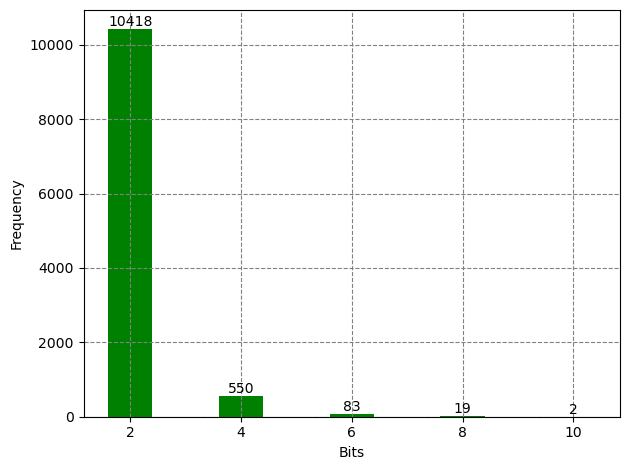

<Figure size 2000x500 with 0 Axes>

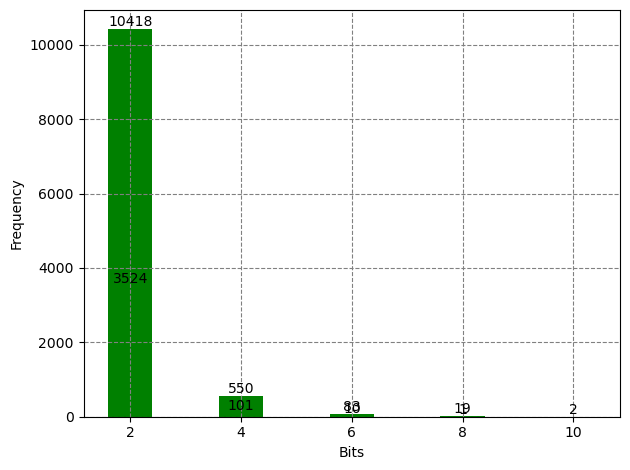

<Figure size 2000x500 with 0 Axes>

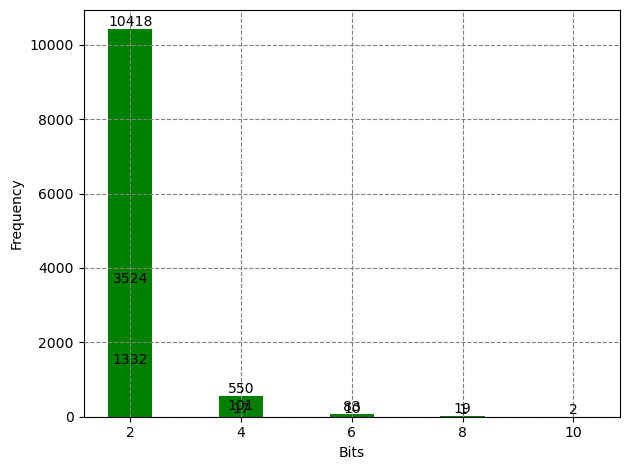

<Figure size 2000x500 with 0 Axes>

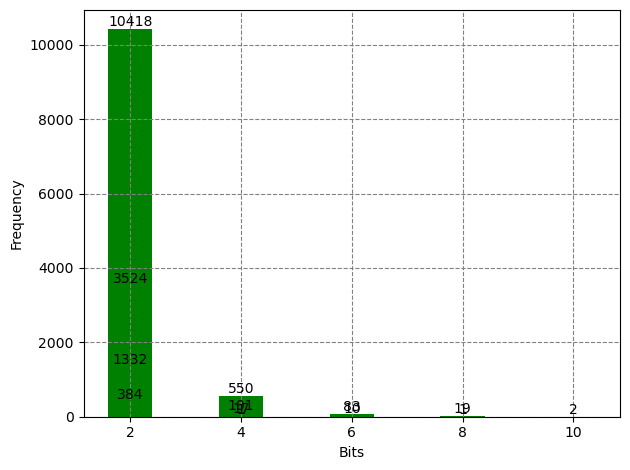

<Figure size 2000x500 with 0 Axes>

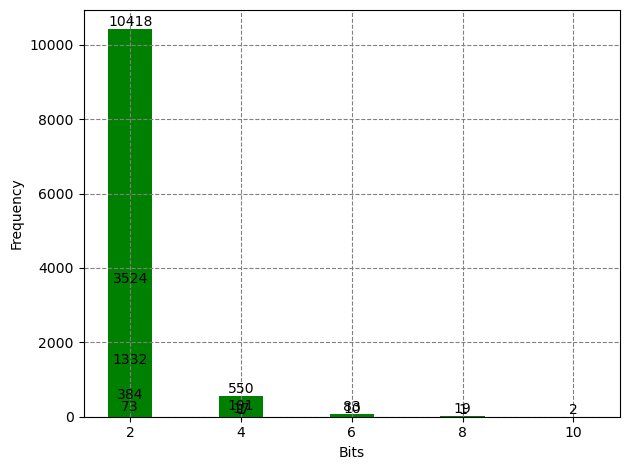

<Figure size 2000x500 with 0 Axes>

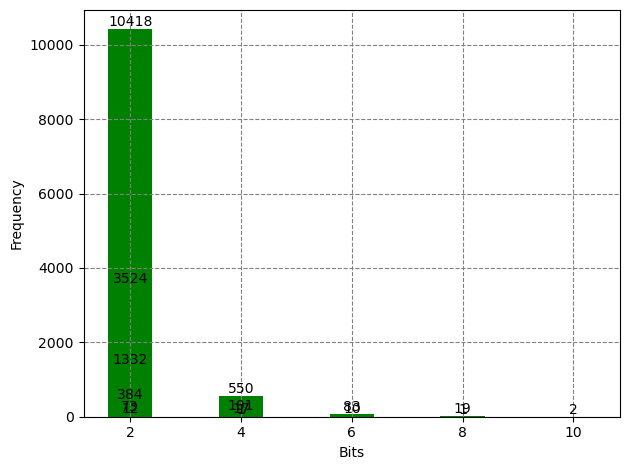

<Figure size 2000x500 with 0 Axes>

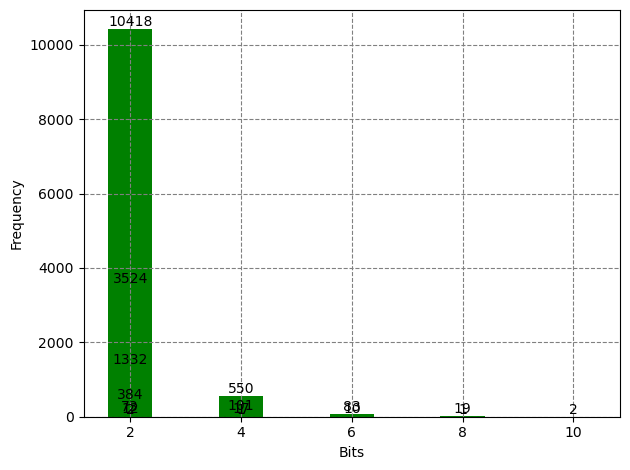

In [5]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plot
from FileAnalize import analize_file, analize_file_uno,analize_file_uno_ceros, save_file, load_file
from funciones import *
from datetime import datetime
import numpy as np
import pandas as pd
from collections import Counter
import pathlib
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages, PdfFile


ruta_bin = 'Data\Fault Characterization\VC707\RawData'       
#ruta_bin = 'Data\Fault Characterization\VC707\RawData\VC707-0.54.bin'
#ruta_bin = 'Data/Fault Characterization/KC705_B/RowData'
directorio = pathlib.Path(ruta_bin)


#variantes= [analize_file, analize_file_uno, analize_file_uno_ceros]
ficheros = [fichero.name for fichero in directorio.iterdir()]

buffer_size=33751040
#buffer_size=29163520

#repeticiones = [0] * len(error_mask)
c=[]
bit=[]
frec=[]
count=0
for i, j in enumerate(ficheros):
    c=[]
    directorio= os.path.join(ruta_bin, j)
    print(directorio)
    buffer= (analize_file_uno(directorio, buffer_size))
    error_mask, locs = (buffer_vectores(buffer))
    for vector in error_mask:
        h=collections.Counter(vector)
        print('h',h) 
        c.append(h['1'])
        #count= count+1
        #if count==num_fallos
    print('c',c)
    print(len(c))
    print(len(error_mask))
    
    # los elementos que mas se repiten 
    print('los elementos que mas se repiten',h.most_common(3))

    a=Counter(c)
    print(a)
    for i in a:
        bit.append(i)
        frec.append(a[i])


    print('bit',bit)
    print('frec',frec)
    print(graficar(bit,frec,j))
    del c
    
print(str()+' operación completada: ', datetime.now().strftime("%H:%M:%S"))  

In [15]:
print(type(c))

<class 'list'>


### La distribición es exponencial: conforme se disminuye el voltaje la frecuencia d elos valores van disminuyendo:  conocer la  esto sirve para la creación d ediferentes modelos, puesto que algunos modelos asumen que los datos tienen una distribución normal, gaussiana, en ese caso hay que hacer un tratamiento especializado para crear modelos efectivos , para detectar datos atipicos que afecten la creación d elos modelos de aprendizaje o las conclusiones que obtenemos d elos datos. Cuando hay datos anomalo , el promedio no es representativo por tanto en el modelo pueden haber sesgos, por este dato atípico 

# Obtengo el buffer para el fichero completo con errores en 1

In [1]:
from Stats import CheckAccuracyAndLoss
from Simulation import save_obj, load_obj
from FileAnalize import analize_file, analize_file_uno,analize_file_uno_ceros, save_file, load_file
from funciones import buffer_vectores
import collections
from datetime import datetime
import itertools
from Training import GetDatasets
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import pandas as pd
import os, sys




#ruta_bin = 'Data\Fault Characterization\VC707\RawData\VC707-0.59.bin'       
ruta_bin = 'Data/Fault Characterization/KC705_B/RowData/KC705B-0.59.bin'
#ruta_bin = 'Data/Fault Characterization/KC705_B/RowData'
directorio = pathlib.Path(ruta_bin)

#buffer_size=33751040
buffer_size=14581760
#variantes= [analize_file, analize_file_uno, analize_file_uno_ceros]
#ficheros = [fichero.name for fichero in directorio.iterdir()]

buffer= (analize_file_uno(directorio, buffer_size))
error_mask, locs = (buffer_vectores(buffer))
repeticiones = [0] * len(error_mask)
c=[]
for vector in error_mask:
    h=collections.Counter(vector)
    #print(h) 
    c.append(h['1'])

    
print(c)
print(len(c))
print(len(error_mask))
# los elementos que mas se repiten 
print(h.most_common(3))
#save_obj(c,'Analizando_fichero_detalle/errores _x_tipo/VC_707_0_59')  
save_obj(c,'Analizando_fichero_detalle/errores _x_tipoprueba') 

    
    #for i,j in enumerate(vector):
        #if j=='1':
            #h=collections.Counter(j)
            #repeticiones[i]=c+1
              
print(str()+' operación completada: ', datetime.now().strftime("%H:%M:%S"))        
   
    

Cantidad de errores de todo el fihero: 2
Tamaño de todo el fihero: 14581760
tamaño de vin_arr: 14581760
Cantidad de elementos por tipo : Counter({'x': 14581758, '1': 2})
tamaño de buffer: 14581760
numeros fallos 2
soy el buffer dentro de funciones 14581760
 dentro de funciones Cantidad de elementos por tipo : Counter({'x': 14581758, '1': 2})
[2]
1
1
[('x', 14), ('1', 2)]
 operación completada:  18:17:55


## Hago un truco para que las barras del diagrama me queden en el centro

Counter({2: 4})
[2]
[4]


<Figure size 2000x500 with 0 Axes>

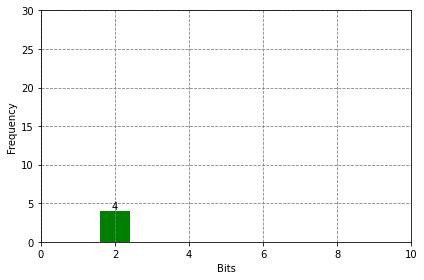

In [309]:
import collections
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
bit=[]
frec=[]
a=Counter(c)
print(a)
for i in a:
    bit.append(i)
    frec.append(a[i])


print(bit)
print(frec)
#print(list_elemento)


#fig = plt.figure(figsize=(20,5), dpi=100)
#plt.rcParams.update({'font.size': 15})
#fig1, ax1 = plt.subplots()
#ax1= fig.add_subplot(1,3,1)



fig= plt.figure(figsize=(20,5), dpi= 100)
plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots()



ax.set_xlim(0,10)
ax.set_ylim(0,30)


a= ax.bar(x=bit, height = frec,color='g')

#ax.set_title('Number of errors by words')
ax.set_xlabel('Bits')
ax.set_ylabel('Frequency')
plt.grid(color = 'gray', linestyle = 'dashed')
ax.bar_label(ax.containers[0])

#pdfFile=PdfPages('Analizando_fichero_detalle/amount_error_word/Number_errors_words_0.60.pdf')
pdfFile=PdfPages('Analizando_fichero_detalle/amount_error_word/705_Number_errors_words_0.58.pdf')
pdfFile.savefig(fig, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()


plt.tight_layout()
    




## Hago un truco para que las barras del diagrama me queden en el cnetro y hago el gráfico

## con seaborn

Counter({2: 4})
[2]
[4]


<Figure size 2000x500 with 0 Axes>

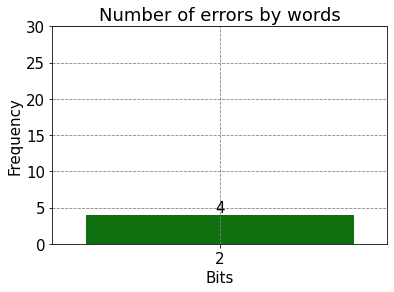

In [14]:
import collections
import os 
import matplotlib.pyplot as plot
import matplotlib.pyplot as pltNew
import seaborn as sns
import numpy as np

bit=[]
frec=[]
a=Counter(c)
print(a)
for i in a:
    bit.append(i)
    frec.append(a[i])


print(bit)
print(frec)



fig= plt.figure(figsize=(20,5), dpi= 100)
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots()
ax.set_xlim(0,10)
ax.set_ylim(0,30)

ax= sns.barplot(x=bit, y = frec,color='g', errwidth=0)
ax.set_title('Number of errors by words')
ax.set_ylabel('Frequency')
ax.set_xlabel('Bits')
plt.grid(color = 'gray', linestyle = 'dashed')
ax.bar_label(ax.containers[0])

pass
    


## método hist pero no queda centrado

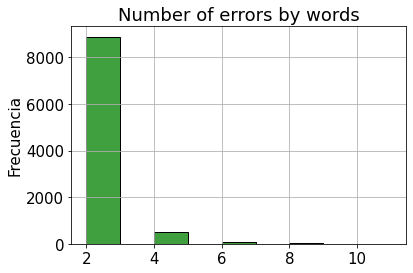

In [171]:
import os 
import matplotlib.pyplot as plot
import seaborn as sns
import numpy as np
inicio = min(c)
fin = max(c)
ancho = 0.3
intervalos = range(min(c), max(c) + 2)
#div=np.linspace(inicio, fin, round(1+(fin-inicio)/ancho))
#print(range(min(c), max(c) ))
#plot.hist(c, bins=intervalos, kde=True, color='g')
sns.histplot(c,bins=intervalos, color='g')
plt.grid()

plot.title('Number of errors by words')
plot.xlabel('Bits')
plot.ylabel('Frecuencia')

plot.show() #dibujamos el histograma

# Analizar la distancia de un fallo hasta el siguiente para todo el fichero
##### En dependencia de que se quiera analizar se cambia :
#####  el tamaño del buffer  y la dirección del fichero , los errores que se desena inyectar
##### por si se quiere hacer para el fichero alterado
#### mejorar este experimento para que guarde ambas resultados en una misma hoja de excel

In [3]:
from FileAnalize import analize_file, analize_file_uno,analize_file_uno_ceros, save_file, load_file
from pandas import ExcelWriter
from datetime import datetime
import numpy as np
import pandas as pd
index=[]
###Direcciones fichero original
obj_dir='Data\Fault Characterization\VC707\Alterado\VC707-0.54.bin'
#obj_dir = 'Data\Fault Characterization\KC705_B\RowData\KC705B-0.59.bin'

####Dirección fichero alterado

#obj_dir='Data\Fault Characterization\VC707\Alterado\VC707-0.54.bin'

#buffer de pesos
#buffer_size=33751040

##fuffer de activaciones
buffer_size= 16777216


buffer=analize_file_uno_ceros(obj_dir, buffer_size)
#print(buffer)


for i,j in enumerate(buffer):
    #print(i)
    if '1' in j or '0' in j:
        index.append(i)
#print(index)
p = np.asarray(index)
diff_list = np.diff(p)
print('El tamaño de buffer es:', len(buffer))
print(np.max(diff_list))
df_diff=pd.DataFrame({'dist':(diff_list)})
df_posi=pd.DataFrame({'error_posic':(p)})




   
buf_diff_posicion = pd.concat([df_diff,df_posi], axis=1, join='outer')
buf_diff_posicion.columns =['df_diff','df_posi']
 
with ExcelWriter('Analizando_fichero_detalle/Alterado_fichero/distanc_fallos/dif_posi_error_0.54.xlsx') as writer:
    buf_diff_posicion.to_excel(writer, sheet_name='0.54', index=False) 
    
    #df_diff.to_excel(writer, 'diff')
    #df_posi.to_excel(writer, 'posi')
    

#df_diff.to_excel('Analizando_fichero_detalle/Alterado_fichero/distanc_fallos/dif_posi_error.xlsx'', index=False)
#df_posi.to_excel('Analizando_fichero_detalle/distac_fallos/dif_posición _error_707_0.60.xlsx', index=False)
#writer = pd.ExcelWriter('Analizando_fichero_detalle/distac_fallos/dif_posi _error.xlsx')
#df_diff.to_excel(writer, sheet_name='fichero_707_0.55', index=False)
#del df_diff
#del df_posi
#print ("difference list: ", str(diff_list)) 

#writer.save()
#writer.close(8
print(str()+' operación completada: ', datetime.now().strftime("%H:%M:%S")) 


#dist=np.where(buffer == '1')

#dist_ = np.asarray(dist)






Cantidad de errores de todo el fihero: 23706
Cantidad de elementos por tipo : Counter({'x': 16766856, '0': 5196, '1': 5164})
El tamaño de buffer es: 16777216
166341
 operación completada:  13:36:25


# guardar las direcciónes con error

In [36]:
from FileAnalize import analize_file, analize_file_uno,analize_file_uno_ceros, save_file, load_file
#ruta_bin = 'Data\Fault Characterization\VC707\RawData'       
#ruta_bin = 'Data\Fault Characterization\VC707\RawData\VC707-0.54.bin'
#ruta_bin = 'Data/Fault Characterization/KC705_B/RowData'
directorio = pathlib.Path(ruta_bin)
buffer_size=33751040
index=[]

#variantes= [analize_file, analize_file_uno, analize_file_uno_ceros]
ficheros = [fichero.name for fichero in directorio.iterdir()]


for i, j in enumerate(ficheros):
    directorio= os.path.join(ruta_bin, j)
    print(directorio)
    buffer= (analize_file_uno_cero(directorio, buffer_size))
    for k,l in enumerate(buffer):
        if '1' in j or '0' in j:
            index.append(i)
    p = np.asarray(index)
    diff_list = np.diff(p)
    print('El tamaño de buffer es:', len(buffer))
    #print('np.max',np.max(diff_list))
    #df_diff=pd.DataFrame(diff_list)
    df_diff=pd.DataFrame({'dist':(diff_list)})
    df_posi=pd.DataFrame({'error_posic':(p)})
    #for i,j in enumerate(ficheros):
        
    df_diff.to_excel('Analizando_fichero_detalleAlterado_fichero\distanc_fallos\dif_posi_error.xlsx', sheet_name=ficheros[i], index=False)
    #ficheros[i]+=1
   
    print ("difference list: ", str(diff_list))
print(str()+' operación completada: ', datetime.now().strftime("%H:%M:%S"))      



#dist=np.where(buffer == '1')

#dist_ = np.asarray(dist)


Data\Fault Characterization\VC707\RawData\VC707-0.54.bin
Cantidad de errores de todo el fihero: 23706
Tamaño de todo el fihero: 33751040
tamaño de vin_arr: 33751040
Cantidad de elementos por tipo : Counter({'x': 33727334, '1': 23706})
tamaño de buffer: 33751040
numeros fallos 23706
El tamaño de buffer es: 33751040
difference list:  []
Data\Fault Characterization\VC707\RawData\VC707-0.55.bin
Cantidad de errores de todo el fihero: 7520
Tamaño de todo el fihero: 33751040
tamaño de vin_arr: 33751040
Cantidad de elementos por tipo : Counter({'x': 33743520, '1': 7520})
tamaño de buffer: 33751040
numeros fallos 7520
El tamaño de buffer es: 33751040
difference list:  []
Data\Fault Characterization\VC707\RawData\VC707-0.56.bin
Cantidad de errores de todo el fihero: 2732
Tamaño de todo el fihero: 33751040
tamaño de vin_arr: 33751040
Cantidad de elementos por tipo : Counter({'x': 33748308, '1': 2732})
tamaño de buffer: 33751040
numeros fallos 2732
El tamaño de buffer es: 33751040
difference list:

# Analisis de las activaciones 
## activaciones con valores muy altos o muy bajos como afecta al output


In [ ]:

for index in range(0,len(outputs1)):
    print('Capa',index,Net1.layers[index].__class__.__name__)
    print('valores maximos por capas: ',np.max(np.abs(outputs1[index])
    print('valores maximos por capas: ',np.min(np.abs(outputs1[index])                                           
                                               
                                                                                           

# Buffer 2 fichero 0.55

In [5]:
from Stats import CheckAccuracyAndLoss
from Simulation import save_obj, load_obj
from FileAnalizeWgt import analize_file_w, analize_file_uno_w,analize_file_uno_ceros_w
from funciones import buffer_vectores
import collections
from datetime import datetime
import itertools
from Training import GetDatasets
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import pandas as pd
import os, sys

trainBatchSize = testBatchSize = 16
_,_,test_dataset = GetDatasets('colorectal_histology',(80,5,15),(227,227), 8, trainBatchSize, testBatchSize)


    

cwd = os.getcwd()
wgt_dir = os.path.join(cwd, 'Data')
wgt_dir = os.path.join(wgt_dir, 'Trained Weights')
wgt_dir = os.path.join(wgt_dir, 'AlexNet')
wgt_dir = os.path.join(wgt_dir, 'Colorectal Dataset')
wgt_dir = os.path.join(wgt_dir,'Weights')
    

Accs_1 = []
Accs_w_1 = []
Accs_a_w_1 = []





df = pd.DataFrame(columns=['Accs', 'Acc_w'])
buffer_size= 16777216*2

num_of_samples = 1


       
ruta_bin = 'Data\Fault Characterization\VC707\RawData\VC707-0.55.bin'
#ruta_bin = 'Data/Fault Characterization/KC705_B/RowData/VC707-0.54.bin''
directorio = pathlib.Path(ruta_bin)
print(ruta_bin)

#variantes= [analize_file, analize_file_uno, analize_file_uno_ceros]
#ficheros = [fichero.name for fichero in directorio.iterdir()]
#print(directorio)

#for index in range(0,num_of_samples):
   # for i, j in enumerate(ficheros):
        #directorio= os.path.join(ruta_bin, j)
buffer= (analize_file_uno_w(directorio, buffer_size))
error_mask, locs = (buffer_vectores(buffer))
        #print(directorio)
#print(error_mask[0])
print(error_mask[0])
#print(error_mask)
print(locs[0])
        
 
        
    

print(str()+' operación completada: ', datetime.now().strftime("%H:%M:%S"))
#save_file(Accs_1,'Data/Fault Characterization/Accs')

#save_obj(Loss,'Data/Errors/AlexNet/Colorectal Dataset/Loss')


Data\Fault Characterization\VC707\RawData\VC707-0.55.bin
cantidad de elemento d etodo el fichero 33751040
Cantidad de errores de todo el fihero: 7520
Cantidad de elementos por tipo : Counter({'x': 16773092, '1': 4124})
soy el buffer dentro de funciones 16777216
 dentro de funciones Cantidad de elementos por tipo : Counter({'x': 16773092, '1': 4124})
xxxxxx1xxxxxxx1x
671
 operación completada:  12:32:03


# Inyectando errores en ceros y unos buffer 1

## Obtener error _mask y locs  tener en cuenta el tipo de errore que s equieren inyectar y en qué buffer Activaciones o pesos

In [3]:
from Stats import CheckAccuracyAndLoss
from Simulation import save_obj, load_obj
from FileAnalize import analize_file, analize_file_uno,analize_file_uno_ceros, save_file, load_file
from FileAnalize import analize_file, analize_file_uno,analize_file_uno_ceros
from funciones import buffer_vectores
import collections
from datetime import datetime
import itertools
from Training import GetDatasets
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import pandas as pd
import os, sys

trainBatchSize = testBatchSize = 16
_,_,test_dataset = GetDatasets('colorectal_histology',(80,5,15),(227,227), 8, trainBatchSize, testBatchSize)


    

cwd = os.getcwd()
wgt_dir = os.path.join(cwd, 'Data')
wgt_dir = os.path.join(wgt_dir, 'Trained Weights')
wgt_dir = os.path.join(wgt_dir, 'AlexNet')
wgt_dir = os.path.join(wgt_dir, 'Colorectal Dataset')
wgt_dir = os.path.join(wgt_dir,'Weights')
    

Accs_1 = []
Accs_w_1 = []
Accs_a_w_1 = []





df = pd.DataFrame(columns=['Accs', 'Acc_w'])
buffer_size= 16777216

num_of_samples = 1


       
ruta_bin = 'Data\Fault Characterization\VC707\RawData\VC707-0.54.bin'
#ruta_bin = 'Data/Fault Characterization/KC705_B/RowData/KC705B-0.5.bin'
directorio = pathlib.Path(ruta_bin)

#variantes= [analize_file, analize_file_uno, analize_file_uno_ceros]
#ficheros = [fichero.name for fichero in directorio.iterdir()]
#print(directorio)

#for index in range(0,num_of_samples):
   # for i, j in enumerate(ficheros):
        #directorio= os.path.join(ruta_bin, j)
buffer= (analize_file_uno_ceros(directorio, buffer_size))
error_mask, locs = (buffer_vectores(buffer))
        #print(directorio)
#print(locs)
print(len(locs))
print(len(error_mask))
#plt.plot(error_mask)
#plt.show
        
  
        
 

print(str()+' operación completada: ', datetime.now().strftime("%H:%M:%S"))
#save_obj(locs,'Data/Fault Characterization/error_mask y locs_buffer_act_vc-707/locs_707_0_54')
#save_obj(error_mask,'Data/Fault Characterization/error_mask y locs_buffer_act_vc-707/error_mask_707_0_54')

C:\Users\usuario\anaconda3\envs\env_first\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


Cantidad de errores de todo el fihero: 23706
Cantidad de elementos por tipo : Counter({'x': 16766856, '0': 5196, '1': 5164})
soy el buffer dentro de funciones 16777216
 dentro de funciones Cantidad de elementos por tipo : Counter({'x': 16766856, '0': 5196, '1': 5164})
4738
4738
 operación completada:  12:39:02


# Fichero original alterado con FF delante y quitando las ultimas 2 letras

## Obtener error _mask y locs tener en cuenta el tipo de errore que s equieren inyectar y en qué buffer Activaciones o pesos

In [14]:
from Stats import CheckAccuracyAndLoss
from Simulation import save_obj, load_obj
from FileAnalize import analize_file, analize_file_uno,analize_file_uno_ceros, save_file, load_file
from FileAnalize import analize_file, analize_file_uno,analize_file_uno_ceros
from funciones import buffer_vectores
import collections
from datetime import datetime
import itertools
from Training import GetDatasets
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import pandas as pd
import os, sys

trainBatchSize = testBatchSize = 16
_,_,test_dataset = GetDatasets('colorectal_histology',(80,5,15),(227,227), 8, trainBatchSize, testBatchSize)


    

cwd = os.getcwd()
wgt_dir = os.path.join(cwd, 'Data')
wgt_dir = os.path.join(wgt_dir, 'Trained Weights')
wgt_dir = os.path.join(wgt_dir, 'AlexNet')
wgt_dir = os.path.join(wgt_dir, 'Colorectal Dataset')
wgt_dir = os.path.join(wgt_dir,'Weights')
    

Accs_1 = []
Accs_w_1 = []
Accs_a_w_1 = []





df = pd.DataFrame(columns=['Accs', 'Acc_w'])
buffer_size= 16777216

num_of_samples = 1


       
ruta_bin = 'Data\Fault Characterization\VC707\Pruebas_Alterado\VC707-0.60.bin'
#ruta_bin = 'Data/Fault Characterization/KC705_B/RowData/KC705B-0.5.bin'
directorio = pathlib.Path(ruta_bin)

#variantes= [analize_file, analize_file_uno, analize_file_uno_ceros]
#ficheros = [fichero.name for fichero in directorio.iterdir()]
#print(directorio)

#for index in range(0,num_of_samples):
   # for i, j in enumerate(ficheros):
        #directorio= os.path.join(ruta_bin, j)
buffer= (analize_file_uno_ceros(directorio, buffer_size))
error_mask, locs = (buffer_vectores(buffer))
        #print(directorio)
#print(locs)
print(len(locs))
print(len(error_mask))
#plt.plot(error_mask)
#plt.show
        
  
        
    

print(str()+' operación completada: ', datetime.now().strftime("%H:%M:%S"))
save_obj(locs,'Data/locs_060')
save_obj(error_mask,'Data/error_mask_060')

C:\Users\usuario\anaconda3\envs\env_first\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


Cantidad de errores de todo el fihero: 4
Cantidad de elementos por tipo : Counter({'x': 16777214, '0': 2})
soy el buffer dentro de funciones 16777216
 dentro de funciones Cantidad de elementos por tipo : Counter({'x': 16777214, '0': 2})
2
2
 operación completada:  15:02:41


In [6]:
vol=54
error_mask=load_obj('Data/error_mask_0'+str(vol))
locs=load_obj('Data/locs_0'+str(vol))
print((error_mask))

['x0xxxxxxx0xxxxxx', 'x0xxxxxxx0xxxxxx', 'x0xxxxxxx0xxxxxx', 'x0xxxxxxx0xxxxxx', 'x1xxxxxxx0xxxxxx', 'x0xxxxxxx1xxxxxx', 'xxxxxx1xxxxxxx1x', 'x1xxxxxxx1xxxxxx', 'x1xxxxxxx1xxxxxx', 'x0xxxxxxx0xxxxxx', 'x1xxxxxxx1xxxxxx', 'x0xxxxxxx1xxxxxx', 'x1xxxxxxx0xxxxxx', 'x1xxxxxxx1xxxxxx', 'x1xxxxxxx0xxxxxx', 'x1xxxxxxx1xxxxxx', 'x1xxxxxxx1xxxxxx', 'x1xxxxxxx1xxxxxx', 'x0xxxxxxx1xxxxxx', 'x0xxxxxxx0xxxxxx', '0xxxxxxx0xxxxxxx', '0xxxxxxx1xxxxxxx', 'xxxxx10xxxxxx00x', 'x1xxxxxxx0xxxxxx', 'xxx0xxxxxxx1xxxx', 'xxx1xxxxxxx1xxxx', 'xxx0xxxxxxx0xxxx', 'xxxx1xxxxxxx0xxx', 'x0xxxxxxx1xxxxxx', 'x1xxxxxxx0xxxxxx', 'x1xxxxxxx1xxxxxx', 'x1xxxxxxx1xxxxxx', 'x1xxxxxxx0xxxxxx', 'x1xxxxxxx1xxxxxx', 'x0xxxxxxx0xxxxxx', 'x1xxxxxxx1xxxxxx', 'xx1xxxxxxx0xxxxx', 'xxxx1xxxxxxx0xxx', 'xxxx1xxxxxxx0xxx', 'xxxx0xxxxxxx1xxx', '0xxxxxxx1xxxxxxx', 'xx0xxxxxxx1xxxxx', 'xx1xxxxxxx1xxxxx', 'xx0xxxxxxx0xxxxx', 'xx1xxxxxxx0xxxxx', 'xx1xxxxxxx0xxxxx', 'xx1xxxxxxx1xxxxx', 'xx0xxxxxxx0xxxxx', 'xx0xxxxxxx1xxxxx', 'xx1xxxxxxx1xxxxx',

# Inyectando errores en ceros y unos buffer 2

In [4]:
from Stats import CheckAccuracyAndLoss
from Simulation import save_obj, load_obj
from FileAnalizeWgt import analize_file_w, analize_file_uno_w,analize_file_uno_ceros_w
from funciones import buffer_vectores
import collections
from datetime import datetime
import itertools
from Training import GetDatasets
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import pandas as pd
import os, sys

trainBatchSize = testBatchSize = 16
_,_,test_dataset = GetDatasets('colorectal_histology',(80,5,15),(227,227), 8, trainBatchSize, testBatchSize)


    

cwd = os.getcwd()
wgt_dir = os.path.join(cwd, 'Data')
wgt_dir = os.path.join(wgt_dir, 'Trained Weights')
wgt_dir = os.path.join(wgt_dir, 'AlexNet')
wgt_dir = os.path.join(wgt_dir, 'Colorectal Dataset')
wgt_dir = os.path.join(wgt_dir,'Weights')
    

Accs_1 = []
Accs_w_1 = []
Accs_a_w_1 = []





df = pd.DataFrame(columns=['Accs', 'Acc_w'])
buffer_size= 16777216*2

num_of_samples = 1


       
ruta_bin = 'Data\Fault Characterization\VC707\RawData\VC707-0.54.bin'
#ruta_bin = 'Data/Fault Characterization/KC705_B/RowData/VC707-0.54.bin''
directorio = pathlib.Path(ruta_bin)

#variantes= [analize_file, analize_file_uno, analize_file_uno_ceros]
#ficheros = [fichero.name for fichero in directorio.iterdir()]
#print(directorio)

#for index in range(0,num_of_samples):
   # for i, j in enumerate(ficheros):
        #directorio= os.path.join(ruta_bin, j)
buffer= (analize_file_uno_ceros_w(directorio, buffer_size))
error_mask, locs = (buffer_vectores(buffer))
        #print(directorio)
print(len(locs))
print(len(error_mask))


print(str()+' operación completada: ', datetime.now().strftime("%H:%M:%S"))
save_obj(locs,'Data/Fault Characterization/error_mask y locs_buffer_act_vc-705/locs_0_54_buffer_pesos')
save_obj(error_mask,'Data/Fault Characterization/error_mask y locs_buffer_act_vc-705/error_mask_0_54_buffer_pesos')

C:\Users\usuario\anaconda3\envs\env_first\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


cantidad de elemento d etodo el fichero 33751040
Cantidad de errores de todo el fihero: 23706
Cantidad de elementos por tipo : Counter({'x': 16764012, '0': 6629, '1': 6575})
soy el buffer dentro de funciones 16777216
 dentro de funciones Cantidad de elementos por tipo : Counter({'x': 16764012, '0': 6629, '1': 6575})
6265
6265
 operación completada:  12:00:36


# Función graficar

# Gráficas 

# AlexNet Activaciones  Buffer 1

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.ticker as ticker
from pylab import *
from IPython.display import display,HTML
import cufflinks as cf
import plotly.offline as py



datos  = pd.read_excel("analisis_ficheros.xlsx",sheet_name='fichero_707')
df= datos.set_index("Voltajes")

df  = pd.read_excel("analisis_ficheros.xlsx",sheet_name='fichero_707', usecols=["Acc_cero","Acc_uno","Acc_uno_cero","Normalize","mask_0"])/0.8906
#df= df.dropna()
datos_f2_=pd.read_excel("analisis_ficheros.xlsx", sheet_name='fichero_705', usecols=["Acc_cero","Acc_uno","Acc_uno_cero","Normalize","mask_0"])/0.89066

#cf.set_config_file(sharing='public',theme='white',offline=True) # write cf.getThemes() to find all themes available




In [36]:
df 
datos_f2_

Acc_cero   Acc_uno  Acc_uno_cero  Normalize    mask_0
0  1.003001  0.779946      0.835336   1.000007  1.004499
1  1.001505  0.904198      0.998510   1.000007  1.001505
2  1.000007  1.000007      1.000007   1.000007  1.001505
3  1.000007  1.000007      1.000007   1.000007  1.001505
4  1.000007  1.001505      1.001505   1.000007  1.000007
5  1.000007  0.998510      1.003001   1.000007  1.000007
6  1.000007  1.000007      1.000007   1.000007  1.000007
7  1.000007  1.000007      1.000007   1.000007  1.000007

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 2000x500 with 0 Axes>

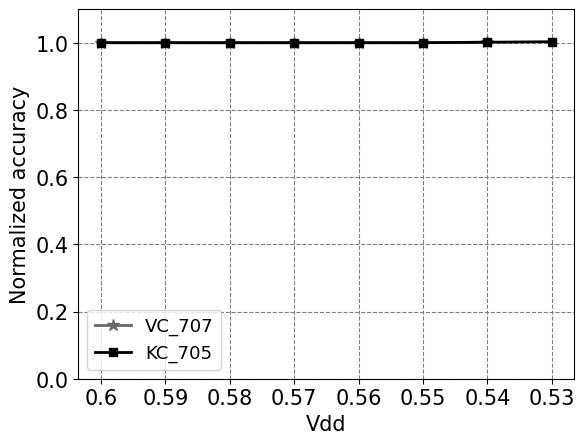

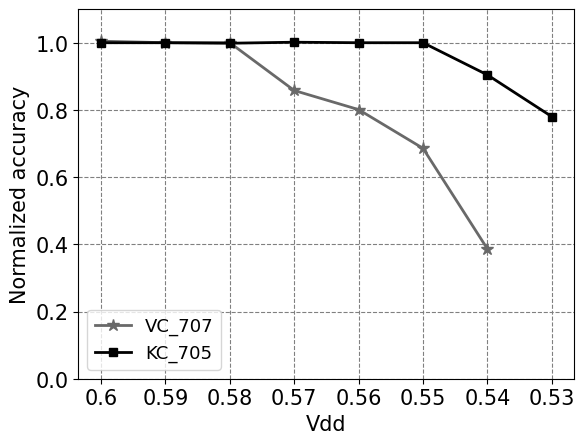

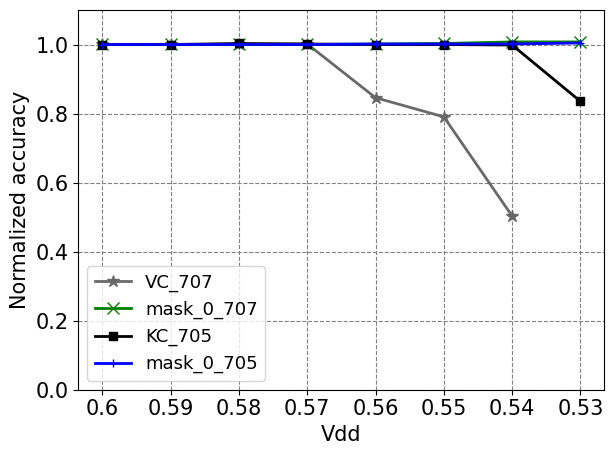

In [37]:
from matplotlib.backends.backend_pdf import PdfPages, PdfFile

x=datos["Voltajes"]
fig = plt.figure(figsize=(20,5), dpi=100)
plt.rcParams.update({'font.size': 15})
fig1, ax1 = plt.subplots()
#ax1= fig.add_subplot(1,3,1)
x_values = range(len(x))

plt.xlabel('Vdd', fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)

plt.xticks(x_values, x)
fig2, ax2 = plt.subplots()
#ax2= fig.add_subplot(1,3,2)
x_values = range(len(x))

plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)

plt.xticks(x_values, x)
fig3, ax3 = plt.subplots()
#ax3= fig.add_subplot(1,3,3)

x_values = range(len(x))
plt.xticks(x_values, x)

plt.xlabel('Vdd', fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)
ax1.set_ylim(0,1.1)
#ax1.set_title("AlexNet errores en 0 en activaciones")
ax1.invert_xaxis()

ax2.set_ylim(0,1.1)
#ax2.set_title("AlexNet errores en 1 en activaciones")
ax2.invert_xaxis()

ax3.set_ylim(0,1.1)
#ax3.set_title("AlexNet errores en 1 y 0 en activaciones")
ax3.invert_xaxis()

ax1.plot(df["Acc_cero"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize=9)
#ax1.plot(df["Normalize"], color='dimgray', ls='-', lw='2', marker='D', markersize='6')
ax1.plot(datos_f2_["Acc_cero"], label='KC_705', color="k", ls='-', lw='2', marker='s', markersize=6)
ax1.grid( color = 'gray', linestyle = 'dashed')
ax1.legend(fontsize=13)



ax2.plot(df["Acc_uno"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize=9)
#ax2.plot(df["Normalize"],  color='dimgray', ls='-', lw='2', marker='D', markersize='6')
ax2.plot(datos_f2_["Acc_uno"], label='KC_705', color="k", ls='-', lw='2', marker='s', markersize=6)
ax2.grid( color = 'gray', linestyle = 'dashed')
ax2.legend(fontsize=13)


ax3.plot(df["Acc_uno_cero"],label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize=9)
ax3.plot(df["mask_0"],label='mask_0_707', color='g', ls='-', lw='2', marker='x', markersize=9)
#ax3.plot(df["Normalize"],  color='dimgray', ls='-', lw='2', marker='D', markersize='6')
ax3.plot(datos_f2_["Acc_uno_cero"], label='KC_705', color="k", ls='-', lw='2', marker='s', markersize=6)
ax3.plot(datos_f2_["mask_0"], label='mask_0_705', color="b", ls='-', lw='2', marker='+', markersize=6)
ax3.grid( color = 'gray', linestyle = 'dashed')
ax3.legend(fontsize=13)




#pdfFile=PdfPages("Alexnet_act_0.pdf")
#pdfFile.savefig(fig1, transparent = True, bbox_inches = 'tight', pad_inches = 0)
#pdfFile.close()
#pdfFile=PdfPages("Alexnet_act_1.pdf")
#pdfFile.savefig(fig2,transparent = True, bbox_inches = 'tight', pad_inches = 0)
#pdfFile.close()
#pdfFile=PdfPages("Alexnet_act_0_1.pdf")
#pdfFile.savefig(fig3, transparent = True, bbox_inches = 'tight', pad_inches = 0)
#pdfFile.close()
#
plt.tight_layout()



plt.show



# AlexNet Pesos  Buffer1

In [631]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.ticker as ticker
from pylab import *
from IPython.display import display,HTML
import cufflinks as cf
import plotly.offline as py
from matplotlib.backends.backend_pdf import PdfPages, PdfFile



datos  = pd.read_excel("analisis_ficheros.xlsx")
datos= datos.set_index("Voltajes")

AlexNet_p_b1_707  = pd.read_excel("analisis_ficheros.xlsx", usecols=["A_w_cero","A_w_uno","A_w_uno_cero","Normalize"])/0.8906
#df= df.dropna()
AlexNet_p_b1_705=pd.read_excel("analisis_ficheros.xlsx", sheet_name='fichero_705', usecols=["A_w_cero","A_w_uno","A_w_uno_cero","Normalize"])/0.89066

#cf.set_config_file(sharing='public',theme='white',offline=True) # write cf.getThemes() to find all themes available


In [639]:
#datos
#AlexNet_p_b1_707
AlexNet_p_b1_705



A_w_cero   A_w_uno  A_w_uno_cero  Normalize
0  1.000007  1.001505      1.001505   1.000007
1  1.000007  1.004499      1.005996   1.000007
2  1.000007  1.000007      1.000007   1.000007
3  1.000007  1.000007      1.000007   1.000007
4  1.000007  1.000007      1.000007   1.000007
5  1.000007  1.001505      1.000007   1.000007
6  1.000007  1.000007      1.000007   1.000007
7       NaN       NaN           NaN   1.000007

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 2000x500 with 0 Axes>

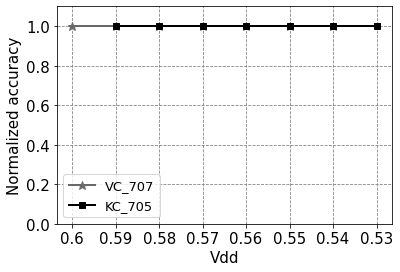

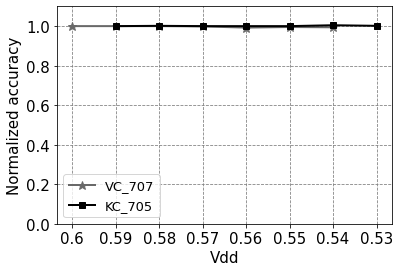

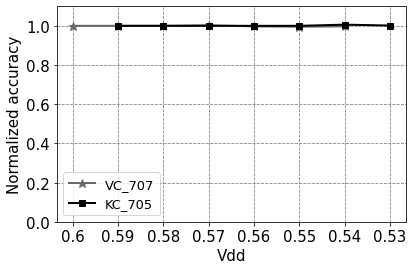

In [638]:
x=datos["Voltajes"]
fig = plt.figure(figsize=(20,5), dpi=100)
plt.rcParams.update({'font.size': 15})

fig1, ax1 = plt.subplots()
#ax1= fig.add_subplot(1,3,1)
x_values = range(len(x))
plt.xlabel('Vdd', fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)


plt.xticks(x_values, x)
fig2, ax2 = plt.subplots()
#ax2= fig.add_subplot(1,3,2)
x_values = range(len(x))
plt.xlabel('Vdd', fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)

plt.xticks(x_values, x)
fig3, ax3 = plt.subplots()
#ax3= fig.add_subplot(1,3,3)

x_values = range(len(x))
plt.xticks(x_values, x)
plt.xlabel('Vdd', fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)
ax1.set_ylim(0,1.1)
#ax1.set_title("AlexNet errores en 0 en Pesos")
ax1.invert_xaxis()

ax2.set_ylim(0,1.1)
#ax2.set_title("AlexNet errores en 1 en Pesos")
ax2.invert_xaxis()

ax3.set_ylim(0,1.1)
#ax3.set_title("AlexNet errores en 0 y 1 en Pesos")
ax3.invert_xaxis()



ax1.plot( AlexNet_p_b1_707["A_w_cero"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax1.plot(AlexNet_p_b1_707["Normalize"], color='grey', ls='-', lw='2', marker='D', markersize='5')
ax1.plot(AlexNet_p_b1_705["A_w_cero"], label='KC_705', color='black', ls='-', lw='2', marker='s', markersize='6')
ax1.grid( color = 'gray', linestyle = 'dashed')
ax1.legend(fontsize=13)


ax2.plot(AlexNet_p_b1_707["A_w_uno"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax2.plot(AlexNet_p_b1_707["Normalize"], color='grey', ls='-', lw='2', marker='D', markersize='5')
ax2.plot(AlexNet_p_b1_705["A_w_uno"], label='KC_705', color='black', ls='-', lw='2', marker='s', markersize='6')
ax2.grid( color = 'gray', linestyle = 'dashed')
ax2.legend(fontsize=13)

ax3.plot(AlexNet_p_b1_707["A_w_uno_cero"],label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax3.plot(AlexNet_p_b1_707["Normalize"], color='grey', ls='-', lw='2', marker='D', markersize='5')
ax3.plot(AlexNet_p_b1_705["A_w_uno_cero"], label='KC_705', color='black', ls='-', lw='2', marker='s', markersize='6')
ax3.grid( color = 'gray', linestyle = 'dashed')
ax3.legend(fontsize=13)

pdfFile=PdfPages("Alexnet_pe_buffer1_0.pdf")
pdfFile.savefig(fig1, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("Alexnet_pe_buffer1_1.pdf")
pdfFile.savefig(fig2,transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("Alexnet_pe_buffer1_0_1.pdf")
pdfFile.savefig(fig3, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()

plt.tight_layout()



plt.show

# AlexNet Activaciones Buffer 2

In [179]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.ticker as ticker
from pylab import *

Alexnet_a_b2  = pd.read_excel("analisis_ficheros.xlsx", sheet_name='fichero_707_2parte_buffer')
Alexnet_act_a_b2= Alexnet_a_b2.set_index("Voltajes")

Alexnet_a_b2_707  = pd.read_excel("analisis_ficheros.xlsx", sheet_name='fichero_707_2parte_buffer', usecols=["Acc_cero","Acc_uno","Acc_uno_cero", "Normalize"])/0.8907
Alexnet_a_b2_705=pd.read_excel("analisis_ficheros.xlsx", sheet_name='fichero_705', usecols=["Acc_cero","Acc_uno","Acc_uno_cero", "Normalize"])/0.8907


In [180]:

#Alexnet_act_a_b2
Alexnet_a_b2_707
#Alexnet_a_b2_705

Acc_cero   Acc_uno  Acc_uno_cero  Normalize
0       NaN       NaN           NaN   0.999963
1  0.990981  0.335317      0.407170   0.999963
2  0.998466  0.564350      0.694585   0.999963
3  1.001460  0.793383      0.845777   0.999963
4  1.001460  0.979005      1.008944   0.999963
5  1.001460  1.001460      1.001460   0.999963
6  1.001460  1.001460      1.001460   0.999963
7  0.999963  0.999963      0.999963   0.999963

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 2000x500 with 0 Axes>

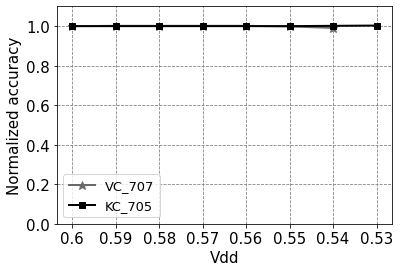

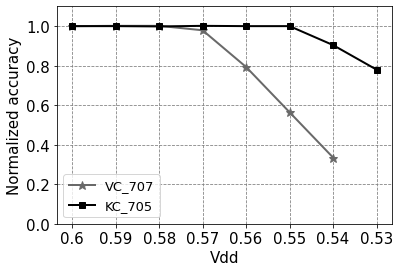

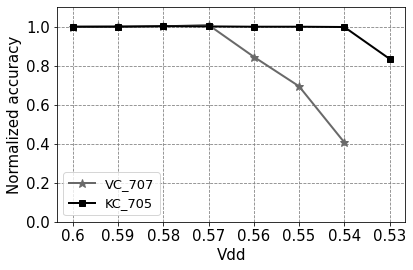

In [182]:
from matplotlib.backends.backend_pdf import PdfPages, PdfFile

x=Alexnet_a_b2["Voltajes"]
fig = plt.figure(figsize=(20,5), dpi=100)
plt.rcParams.update({'font.size': 15})
fig1, ax1 = plt.subplots()
#ax1= fig.add_subplot(1,3,1)
x_values = range(len(x))

plt.xlabel('Vdd', fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)

plt.xticks(x_values, x)
fig2, ax2 = plt.subplots()
#ax2= fig.add_subplot(1,3,2)
x_values = range(len(x))

plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)

plt.xticks(x_values, x)
fig3, ax3 = plt.subplots()
#ax3= fig.add_subplot(1,3,3)

x_values = range(len(x))
plt.xticks(x_values, x)

plt.xlabel('Vdd', fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)
ax1.set_ylim(0,1.1)
#ax1.set_title("AlexNet errores en 0 en activaciones")
ax1.invert_xaxis()

ax2.set_ylim(0,1.1)
#ax2.set_title("AlexNet errores en 1 en activaciones")
ax2.invert_xaxis()

ax3.set_ylim(0,1.1)
#ax3.set_title("AlexNet errores en 1 y 0 en activaciones")
ax3.invert_xaxis()

ax1.plot(Alexnet_a_b2_707["Acc_cero"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize=9)
#ax1.plot(Alexnet_a_b2_707["Normalize"], color='dimgray', ls='-', lw='2', marker='D', markersize='6')
ax1.plot(Alexnet_a_b2_705["Acc_cero"], label='KC_705', color="k", ls='-', lw='2', marker='s', markersize=6)
ax1.grid( color = 'gray', linestyle = 'dashed')
ax1.legend(fontsize=13)



ax2.plot(Alexnet_a_b2_707["Acc_uno"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize=9)
#ax2.plot(Alexnet_a_b2_707["Normalize"],  color='dimgray', ls='-', lw='2', marker='D', markersize='6')
ax2.plot(Alexnet_a_b2_705["Acc_uno"], label='KC_705', color="k", ls='-', lw='2', marker='s', markersize=6)
ax2.grid( color = 'gray', linestyle = 'dashed')
ax2.legend(fontsize=13)


ax3.plot(Alexnet_a_b2_707["Acc_uno_cero"],label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize=9)
#ax3.plot(Alexnet_a_b2_707["Normalize"],  color='dimgray', ls='-', lw='2', marker='D', markersize='6')
ax3.plot(Alexnet_a_b2_705["Acc_uno_cero"], label='KC_705', color="k", ls='-', lw='2', marker='s', markersize=6)
ax3.grid( color = 'gray', linestyle = 'dashed')
ax3.legend(fontsize=13)




pdfFile=PdfPages("Alexnet_act_buffer2_0.pdf")
pdfFile.savefig(fig1, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("Alexnet_act_buffer2_1.pdf")
pdfFile.savefig(fig2,transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("Alexnet_act_buffer2_0_1.pdf")
pdfFile.savefig(fig3, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()

plt.tight_layout()



plt.show

# AlexNet Activaciones pesos 5 bit Buffer 2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.ticker as ticker
from pylab import *

Alexnet_a_b2_5bit  = pd.read_excel("analisis_ficheros.xlsx", sheet_name='fichero_707_weights_5bit')
Alexnet_act_b2_5bit= Alexnet_a_b2_5bit.set_index("Voltajes")

Alexnet_a_b2_5bit_707  = pd.read_excel("analisis_ficheros.xlsx", sheet_name='fichero_707_weights_5bit', usecols=["Acc_cero","Acc_uno","Acc_uno_cero", "Normalize"])/0.8907
Alexnet_a_b2_705=pd.read_excel("analisis_ficheros.xlsx", sheet_name='fichero_705', usecols=["Acc_cero","Acc_uno","Acc_uno_cero", "Normalize"])/0.8907


In [3]:
#Alexnet_a_b2_5bit
Alexnet_a_b2_5bit_707

Acc_cero   Acc_uno  Acc_uno_cero  Normalize
0       NaN       NaN           NaN   0.999963
1  0.987987  0.354777      0.408667   0.999963
2  0.992478  0.541896      0.666143   0.999963
3  0.995472  0.775420      0.829310   0.999963
4  0.998466  0.872722      0.999963   0.999963
5  0.999963  0.995472      0.999963   0.999963
6  0.999963  0.998466      0.999963   0.999963
7  0.999963  0.999963      0.999963   0.999963

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 2000x500 with 0 Axes>

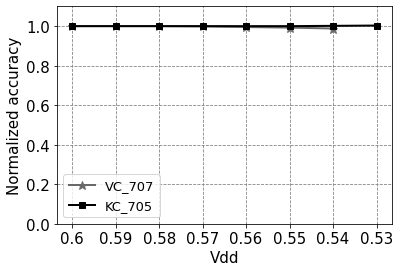

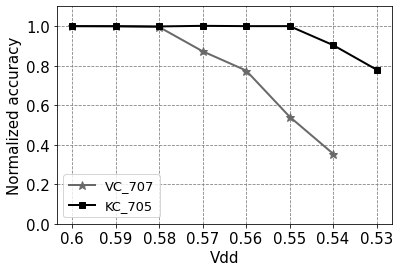

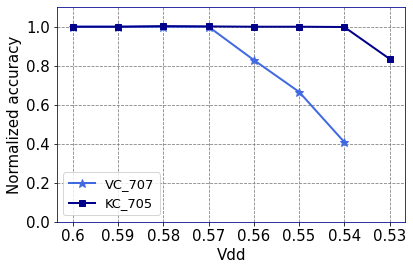

In [32]:
from matplotlib.backends.backend_pdf import PdfPages, PdfFile

x=Alexnet_a_b2_5bit["Voltajes"]
fig = plt.figure(figsize=(20,5), dpi=100)
plt.rcParams.update({'font.size': 15})
fig1, ax1 = plt.subplots()
#ax1= fig.add_subplot(1,3,1)
x_values = range(len(x))

plt.xlabel('Vdd', fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)

plt.xticks(x_values, x)
fig2, ax2 = plt.subplots()
#ax2= fig.add_subplot(1,3,2)
x_values = range(len(x))

plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)

plt.xticks(x_values, x)
fig3, ax3 = plt.subplots()
#ax3= fig.add_subplot(1,3,3)

x_values = range(len(x))
plt.xticks(x_values, x)
#plt.xticks(color='royalblue')
#plt.yticks(color='royalblue')


plt.xlabel('Vdd', fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)
ax1.set_ylim(0,1.1)
#ax1.set_title("AlexNet errores en 0 en activaciones")
ax1.invert_xaxis()

ax2.set_ylim(0,1.1)
#ax2.set_title("AlexNet errores en 1 en activaciones")
ax2.invert_xaxis()

ax3.set_ylim(0,1.1)
#ax3.set_title("AlexNet errores en 1 y 0 en activaciones")
ax3.invert_xaxis()

ax1.plot(Alexnet_a_b2_5bit_707["Acc_cero"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize=9)
#ax1.plot(Alexnet_a_b2_707["Normalize"], color='dimgray', ls='-', lw='2', marker='D', markersize='6')
ax1.plot(Alexnet_a_b2_705["Acc_cero"], label='KC_705', color="k", ls='-', lw='2', marker='s', markersize=6)
ax1.grid( color = 'gray', linestyle = 'dashed')
ax1.legend(fontsize=13)



ax2.plot(Alexnet_a_b2_5bit_707["Acc_uno"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize=9)
#ax2.plot(Alexnet_a_b2_707["Normalize"],  color='dimgray', ls='-', lw='2', marker='D', markersize='6')
ax2.plot(Alexnet_a_b2_705["Acc_uno"], label='KC_705', color="k", ls='-', lw='2', marker='s', markersize=6)
ax2.grid( color = 'gray', linestyle = 'dashed')
ax2.legend(fontsize=13)


ax3.plot(Alexnet_a_b2_5bit_707["Acc_uno_cero"],label='VC_707', color='royalblue', ls='-', lw='2', marker='*', markersize=9)
#ax3.plot(Alexnet_a_b2_707["Normalize"],  color='dimgray', ls='-', lw='2', marker='D', markersize='6')
ax3.plot(Alexnet_a_b2_705["Acc_uno_cero"], label='KC_705', color="darkblue", ls='-', lw='2', marker='s', markersize=6)
ax3.grid( color = 'gray', linestyle = 'dashed')
ax3.legend(fontsize=13)
ax3.spines['top'].set_color('darkblue')
ax3.spines['left'].set_color('darkblue')
ax3.spines['right'].set_color('darkblue')
ax3.spines['bottom'].set_color('darkblue')





pdfFile=PdfPages("Alexnet_act_5bit_buffer2_0.pdf")
pdfFile.savefig(fig1, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("Alexnet_act_5bit_buffer2_1.pdf")
pdfFile.savefig(fig2,transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("Alexnet_act_5bit_buffer2_0_1.pdf")
pdfFile.savefig(fig3, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()

plt.tight_layout()



plt.show

# AlexNet Pesos   Buffer2

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.ticker as ticker
from pylab import *

datos_b2  = pd.read_excel("analisis_ficheros.xlsx", sheet_name='fichero_707_2parte_buffer')
datos_b2_= datos_b2.set_index("Voltajes")

datos_707_P_2  = pd.read_excel("analisis_ficheros.xlsx", sheet_name='fichero_707_2parte_buffer', usecols=["A_w_cero","A_w_uno","A_w_uno_cero", "Normalize"])/0.8907
datos_f2_P=pd.read_excel("analisis_ficheros.xlsx", sheet_name='fichero_705', usecols=["A_w_cero","A_w_uno","A_w_uno_cero", "Normalize"])/0.8907


In [116]:
#datos_b2
datos_707_P_2
#datos_f2_P

A_w_cero   A_w_uno  A_w_uno_cero  Normalize
0       NaN       NaN           NaN   0.999963
1  0.131732  0.131732      0.131732   0.999963
2  0.999963  1.001460      1.001460   0.999963
3  0.999963  0.999963      0.999963   0.999963
4  0.999963  1.001460      1.001460   0.999963
5  0.999963  0.999963      0.999963   0.999963
6  0.999963  0.999963      0.999963   0.999963
7  0.999963  0.999963      0.999963   0.999963

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 2000x500 with 0 Axes>

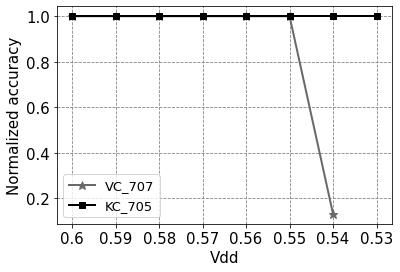

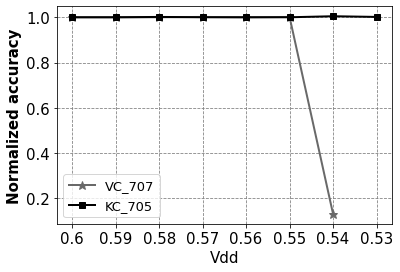

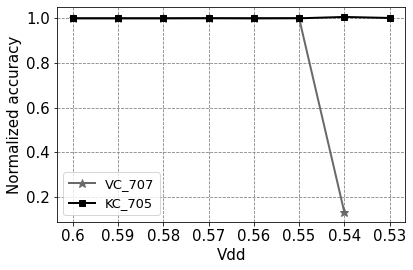

In [117]:

x=datos_b2["Voltajes"]
fig = plt.figure(figsize=(20,5), dpi=100)
plt.rcParams.update({'font.size': 15})

fig1, ax1 = plt.subplots()
#ax1= fig.add_subplot(1,3,1)
x_values = range(len(x))
plt.xlabel('Vdd', fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)


plt.xticks(x_values, x)
fig2, ax2 = plt.subplots()
#ax2= fig.add_subplot(1,3,2)
x_values = range(len(x))
plt.xlabel('Vdd', fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15 ,fontweight="bold")

plt.xticks(x_values, x)
fig3, ax3 = plt.subplots()
#ax3= fig.add_subplot(1,3,3)

x_values = range(len(x))
plt.xticks(x_values, x)
plt.xlabel('Vdd', fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)
ax1.set_ylim(0,1.1)
#ax1.set_title("AlexNet errores en 0 en Pesos")
ax1.invert_xaxis()

ax2.set_ylim(0,1.1)
#ax2.set_title("AlexNet errores en 1 en Pesos")
ax2.invert_xaxis()

ax3.set_ylim(0,1.1)
#ax3.set_title("AlexNet errores en 0 y 1 en Pesos")
ax3.invert_xaxis()



ax1.plot( datos_707_P_2["A_w_cero"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax1.plot(datos_707_P_2["Normalize"], color='grey', ls='-', lw='2', marker='D', markersize='5')
ax1.plot(datos_f2_P["A_w_cero"], label='KC_705', color='black', ls='-', lw='2', marker='s', markersize='6')
ax1.grid( color = 'gray', linestyle = 'dashed')
ax1.legend(fontsize=13)


ax2.plot(datos_707_P_2["A_w_uno"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax2.plot(datos_707_P_2["Normalize"], color='grey', ls='-', lw='2', marker='D', markersize='5')
ax2.plot(datos_f2_P["A_w_uno"], label='KC_705', color='black', ls='-', lw='2', marker='s', markersize='6')
ax2.grid( color = 'gray', linestyle = 'dashed')
ax2.legend(fontsize=13)

ax3.plot(datos_707_P_2["A_w_uno_cero"],label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax3.plot(datos_707_P_2["Normalize"], color='grey', ls='-', lw='2', marker='D', markersize='5')
ax3.plot(datos_f2_P["A_w_uno_cero"], label='KC_705', color='black', ls='-', lw='2', marker='s', markersize='6')
ax3.grid( color = 'gray', linestyle = 'dashed')
ax3.legend(fontsize=13)

pdfFile=PdfPages("Alexnet_pe_buffer2_0.pdf")
pdfFile.savefig(fig1, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("Alexnet_pe_buffer2_1.pdf")
pdfFile.savefig(fig2,transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("Alexnet_pe_buffer2_0_1.pdf")
pdfFile.savefig(fig3, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()

plt.tight_layout()



plt.show

# AlexNet Pesos con 5 bit   Buffer2 

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.ticker as ticker
from pylab import *

datos_b2_p5bit  = pd.read_excel("analisis_ficheros.xlsx", sheet_name='fichero_707_weights_5bit')
datos_b2_p5bit_= datos_b2_p5bit.set_index("Voltajes")

datos_b2_p5bit_707  = pd.read_excel("analisis_ficheros.xlsx", sheet_name='fichero_707_weights_5bit', usecols=["A_w_cero","A_w_uno","A_w_uno_cero", "Normalize"])/0.8907
datos_b2_f2_P=pd.read_excel("analisis_ficheros.xlsx", sheet_name='fichero_705', usecols=["A_w_cero","A_w_uno","A_w_uno_cero", "Normalize"])/0.8907


In [35]:
#datos_b2_p5bit
datos_b2_p5bit_707

A_w_cero   A_w_uno  A_w_uno_cero  Normalize
0       NaN       NaN           NaN   0.999963
1  0.996969  0.158677      0.993975   0.999963
2  0.999963  1.004453      1.001460   0.999963
3  0.999963  1.002956      0.999963   0.999963
4  0.999963  1.001460      0.999963   0.999963
5  0.999963  1.001460      0.998466   0.999963
6  0.999963  0.999963      0.998466   0.999963
7  0.999963  0.999963      0.999963   0.999963

<Figure size 2000x500 with 0 Axes>

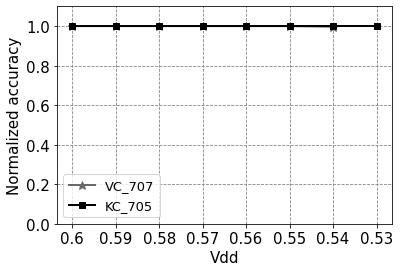

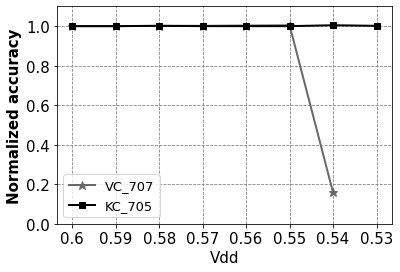

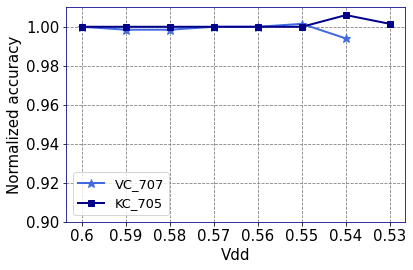

In [37]:
x=datos_b2_p5bit["Voltajes"]
fig = plt.figure(figsize=(20,5), dpi=100)
plt.rcParams.update({'font.size': 15})

fig1, ax1 = plt.subplots()
#ax1= fig.add_subplot(1,3,1)
x_values = range(len(x))
plt.xlabel('Vdd', fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)


plt.xticks(x_values, x)
fig2, ax2 = plt.subplots()
#ax2= fig.add_subplot(1,3,2)
x_values = range(len(x))
plt.xlabel('Vdd', fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15 ,fontweight="bold")

plt.xticks(x_values, x)
fig3, ax3 = plt.subplots()
#ax3= fig.add_subplot(1,3,3)

x_values = range(len(x))
plt.xticks(x_values, x)
plt.xlabel('Vdd', fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)
ax1.set_ylim(0,1.1)
#ax1.set_title("AlexNet errores en 0 en Pesos")
ax1.invert_xaxis()

ax2.set_ylim(0,1.1)
#ax2.set_title("AlexNet errores en 1 en Pesos")
ax2.invert_xaxis()

ax3.set_ylim(0.90,1.01)
#ax3.set_title("AlexNet errores en 0 y 1 en Pesos")
ax3.invert_xaxis()



ax1.plot( datos_b2_p5bit_707["A_w_cero"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax1.plot(datos_707_P_2["Normalize"], color='grey', ls='-', lw='2', marker='D', markersize='5')
ax1.plot(datos_b2_f2_P["A_w_cero"], label='KC_705', color='black', ls='-', lw='2', marker='s', markersize='6')
ax1.grid( color = 'gray', linestyle = 'dashed')
ax1.legend(fontsize=13)


ax2.plot(datos_b2_p5bit_707["A_w_uno"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax2.plot(datos_707_P_2["Normalize"], color='grey', ls='-', lw='2', marker='D', markersize='5')
ax2.plot(datos_b2_f2_P["A_w_uno"], label='KC_705', color='black', ls='-', lw='2', marker='s', markersize='6')
ax2.grid( color = 'gray', linestyle = 'dashed')
ax2.legend(fontsize=13)

ax3.plot(datos_b2_p5bit_707["A_w_uno_cero"],label='VC_707', color='royalblue', ls='-', lw='2', marker='*', markersize='9')
#ax3.plot(datos_707_P_2["Normalize"], color='grey', ls='-', lw='2', marker='D', markersize='5')
ax3.plot(datos_b2_f2_P["A_w_uno_cero"], label='KC_705', color='darkblue', ls='-', lw='2', marker='s', markersize='6')
ax3.grid( color = 'gray', linestyle = 'dashed')
ax3.legend(fontsize=13, loc=3)
ax3.spines['top'].set_color('darkblue')
ax3.spines['left'].set_color('darkblue')
ax3.spines['right'].set_color('darkblue')
ax3.spines['bottom'].set_color('darkblue')




#ax.yaxis.set_minor_formatter('{x:.2f}')

pdfFile=PdfPages("Alexnet_pe5bit_buffer2_0.pdf")
pdfFile.savefig(fig1, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("Alexnet_pe5bit_buffer2_1.pdf")
pdfFile.savefig(fig2,transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("Alexnet_pe5bit_buffer2_0_1.pdf")
pdfFile.savefig(fig3, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()

plt.tight_layout()


# AlexNet Activaciones y Pesos  Buffer 1

In [186]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.ticker as ticker
from pylab import *

datos  = pd.read_excel("analisis_ficheros.xlsx")
datos= datos.set_index("Voltajes")

datos_707_A_P  = pd.read_excel("analisis_ficheros.xlsx", usecols=["Acc_a_w_cero","Acc_a_w_uno","Acc_a_w_uno_cero","Normalize"])/0.8907
datos_A_P=pd.read_excel("analisis_ficheros.xlsx", sheet_name='fichero_705', usecols=["Acc_a_w_cero","Acc_a_w_uno","Acc_a_w_uno_cero", "Normalize"])/0.8907

In [187]:
datos
#datos_707_A_P
#datos_A_P
#df

Acc_cero  A_w_cero  Acc_a_w_cero   Acc_uno   A_w_uno  Acc_a_w_uno  \
Voltajes                                                                      
0.53           NaN       NaN           NaN       NaN       NaN          NaN   
0.54      0.892000  0.890667      0.892000  0.344000  0.885333     0.338667   
0.55      0.890667  0.890667      0.890667  0.610667  0.886667     0.606667   
0.56      0.890667  0.890667      0.890667  0.713333  0.884000     0.710667   
0.57      0.890667  0.890667      0.890667  0.764000  0.889333     0.761333   
0.58      0.890667  0.890667      0.890667  0.890667  0.890667     0.890667   
0.59      0.890667  0.890667      0.890667  0.890667  0.890667     0.890667   
0.60      0.890667  0.890667      0.890667  0.894667  0.890667     0.894667   

          Acc_uno_cero  A_w_uno_cero  Acc_a_w_uno_cero  Normalize  
Voltajes                                                           
0.53               NaN           NaN               NaN   0.890667  
0.54          0.448000      0.888000          0.441333   0.890667  
0.55          0.704000      0.886667          0.698667   0.890667  
0.56          0.753333      0.888000          0.758667   0.890667  
0.57          0.892000      0.893333          0.897333   0.890667  
0.58          0.890667      0.890667          0.890667   0.890667  
0.59          0.890667      0.890667          0.890667   0.890667  
0.60          0.890667      0.890667          0.890667   0.890667

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 2000x500 with 0 Axes>

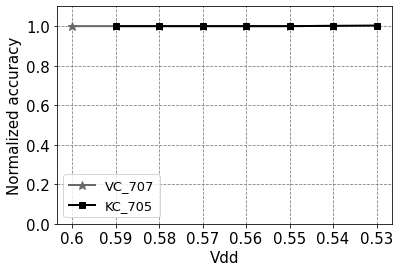

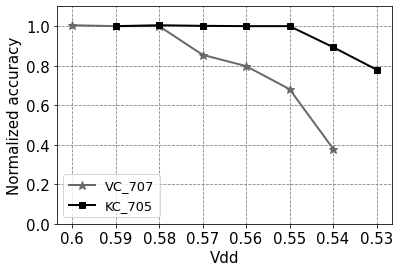

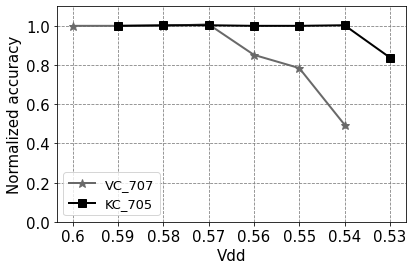

In [499]:
x=datos["Voltajes"]
fig = plt.figure(figsize=(20,5), dpi=100)

plt.rcParams.update({'font.size': 15})

fig1, ax1 = plt.subplots()
#ax1= fig.add_subplot(1,3,1)
x_values = range(len(x))
plt.xlabel('Vdd', fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)


plt.xticks(x_values, x)
fig2, ax2 = plt.subplots()
#ax2= fig.add_subplot(1,3,2)
x_values = range(len(x))
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)

plt.xticks(x_values, x)
fig3, ax3 = plt.subplots()
#ax3= fig.add_subplot(1,3,3)

x_values = range(len(x))
plt.xticks(x_values, x)
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)
ax1.set_ylim(0,1.1)
#ax1.set_title("AlexNet errores en 0 en Pesos y Activaciones", )
ax1.invert_xaxis()

ax2.set_ylim(0,1.1)
#ax2.set_title("AlexNet errores en 0 en Pesos y Activaciones")
ax2.invert_xaxis()

ax3.set_ylim(0,1.1)
#ax3.set_title("AlexNet errores en 0 en Pesos y Activaciones")
ax3.invert_xaxis()



ax1.plot( datos_707_A_P["Acc_a_w_cero"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax1.plot(datos_707_A_P["Normalize"],  color='dimgray', ls='-', lw='2', marker='+', markersize='4')
ax1.plot(datos_A_P["Acc_a_w_cero"], label='KC_705', color='k', ls='-', lw='2', marker='s', markersize='6')
ax1.grid( color = 'gray', linestyle = 'dashed')
ax1.legend(fontsize=13)


ax2.plot(datos_707_A_P["Acc_a_w_uno"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax2.plot(datos_707_A_P["Normalize"], color='grey', ls='-', lw='2', marker='D', markersize='5')
ax2.plot(datos_A_P["Acc_a_w_uno"], label='KC_705', color='k', ls='-', lw='2', marker='s', markersize='6')
ax2.grid( color = 'gray', linestyle = 'dashed')
ax2.legend(fontsize=13)


ax3.plot(datos_707_A_P["Acc_a_w_uno_cero"],label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax3.plot(datos_707_A_P["Normalize"],  color='grey', ls='-', lw='2', marker='D', markersize='5')
ax3.grid( color = 'gray', linestyle = 'dashed')
ax3.plot(datos_A_P["Acc_a_w_uno_cero"], label='KC_705', color='k', ls='-', lw='2', marker='s', markersize='8')
ax3.legend(fontsize=13)

pdfFile=PdfPages("Alexnet_pe_y act_buffer1_0.pdf")
pdfFile.savefig(fig1, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("Alexnet_pe_y_act_buffer1_1.pdf")
pdfFile.savefig(fig2,transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("Alexnet_pe__y_act_buffer1_0_1.pdf")
pdfFile.savefig(fig3, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()

plt.tight_layout()



plt.show

# AlexNet Activaciones y Pesos  Buffer 2

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.ticker as ticker
from pylab import *

datos_b2  = pd.read_excel("analisis_ficheros.xlsx", sheet_name='fichero_707_2parte_buffer')
datos_b2_= datos_b2.set_index("Voltajes")

datos_707_A_P_2  = pd.read_excel("analisis_ficheros.xlsx", sheet_name='fichero_707_2parte_buffer', usecols=["Acc_a_w_cero","Acc_a_w_uno","Acc_a_w_uno_cero", "Normalize"])/0.8907
datos_f2_A_P=pd.read_excel("analisis_ficheros.xlsx", sheet_name='fichero_705', usecols=["Acc_a_w_cero","Acc_a_w_uno","Acc_a_w_uno_cero", "Normalize"])/0.8907


In [2]:
datos_b2
#datos_707_A_P_2
#datos_f2_A_P

Voltajes  Acc_cero  A_w_cero  Acc_a_w_cero   Acc_uno   A_w_uno  \
0      0.53       NaN       NaN           NaN       NaN       NaN   
1      0.54  0.882667  0.117333      0.117333  0.298667  0.117333   
2      0.55  0.889333  0.890667      0.889333  0.502667  0.892000   
3      0.56  0.892000  0.890667      0.892000  0.706667  0.890667   
4      0.57  0.892000  0.890667      0.892000  0.872000  0.892000   
5      0.58  0.892000  0.890667      0.892000  0.892000  0.890667   
6      0.59  0.892000  0.890667      0.892000  0.892000  0.890667   
7      0.60  0.890667  0.890667      0.890667  0.890667  0.890667   

   Acc_a_w_uno  Acc_uno_cero  A_w_uno_cero  Acc_a_w_uno_cero  Normalize  
0          NaN           NaN           NaN               NaN   0.890667  
1     0.117333      0.362667      0.117333          0.117333   0.890667  
2     0.498667      0.618667      0.892000          0.617333   0.890667  
3     0.705333      0.753333      0.890667          0.753333   0.890667  
4     0.873333      0.898667      0.892000          0.898667   0.890667  
5     0.893333      0.892000      0.890667          0.892000   0.890667  
6     0.890667      0.892000      0.890667          0.892000   0.890667  
7     0.890667      0.890667      0.890667          0.890667   0.890667

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 2000x500 with 0 Axes>

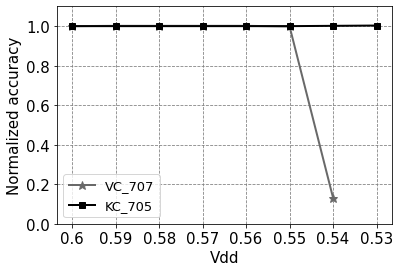

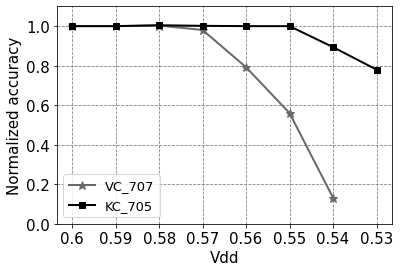

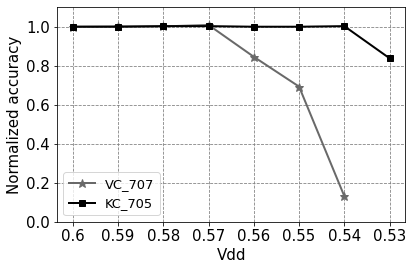

In [5]:
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
x=datos_b2["Voltajes"]
fig = plt.figure(figsize=(20,5), dpi=100)
plt.rcParams.update({'font.size': 15})

fig1, ax1 = plt.subplots()
#ax1= fig.add_subplot(1,3,1)
plt.xticks(x_values, x)
x_values = range(len(x))
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)

fig2, ax2 = plt.subplots()
plt.xticks(x_values, x)
#ax2= fig.add_subplot(1,3,2)
x_values = range(len(x))
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)


fig3, ax3 = plt.subplots()
#ax3= fig.add_subplot(1,3,3)
x_values = range(len(x))
plt.xticks(x_values, x)
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)

ax1.set_ylim(0,1.1)
#ax1.set_title("AlexNet errores en 0 en Pesos y Activaciones")
ax1.invert_xaxis()

ax2.set_ylim(0,1.1)
#ax2.set_title("AlexNet errores en 1 en Pesos y Activaciones")
ax2.invert_xaxis()

ax3.set_ylim(0,1.1)
#ax3.set_title("AlexNet errores en 0 y 1 en Pesos y Activaciones")
ax3.invert_xaxis()



ax1.plot(x_values, datos_707_A_P_2["Acc_a_w_cero"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax1.plot(datos_707_A_P_2["Normalize"], color='grey', ls='-', lw='2', marker='D', markersize='6')
ax1.plot(datos_f2_A_P["Acc_a_w_cero"], label='KC_705', color='k', ls='-', lw='2', marker='s', markersize='6')
ax1.grid( color = 'gray', linestyle = 'dashed')
ax1.legend(fontsize=13)


ax2.plot(x_values,datos_707_A_P_2["Acc_a_w_uno"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax2.plot(datos_707_A_P_2["Normalize"], color='grey', ls='-', lw='2', marker='D', markersize='6')
ax2.plot(datos_f2_A_P["Acc_a_w_uno"], label='KC_705', color='k', ls='-', lw='2', marker='s', markersize='6')
ax2.grid( color = 'gray', linestyle = 'dashed')
ax2.legend(fontsize=13)

ax3.plot(x_values,datos_707_A_P_2["Acc_a_w_uno_cero"],label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax3.plot(datos_707_A_P_2["Normalize"], color='grey', ls='-', lw='2', marker='D', markersize='6')
ax3.grid( color = 'gray', linestyle = 'dashed')
ax3.plot(datos_f2_A_P["Acc_a_w_uno_cero"], label='KC_705', color='k', ls='-', lw='2', marker='s', markersize='6')
ax3.legend(fontsize=13)

pdfFile=PdfPages("Alexnet_pe_y_act_buffer2_0.pdf")
pdfFile.savefig(fig1, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("Alexnet_pe_y_act_buffer2_1.pdf")
pdfFile.savefig(fig2,transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("Alexnet_pe_y_act_buffer2_0_1.pdf")
pdfFile.savefig(fig3, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()

plt.tight_layout()

plt.show

# AlexNet Activaciones y Pesos 5bit Buffer 2

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.ticker as ticker
from pylab import *

datos_b2_5bit  = pd.read_excel("analisis_ficheros.xlsx", sheet_name='fichero_707_weights_5bit')
datos_b2_5bit_= datos_b2_5bit.set_index("Voltajes")

alexnet_b2_5bit_707_A_P_2  = pd.read_excel("analisis_ficheros.xlsx", sheet_name='fichero_707_weights_5bit', usecols=["Acc_a_w_cero","Acc_a_w_uno","Acc_a_w_uno_cero", "Normalize"])/0.8907
alexnet_f2_A_P=pd.read_excel("analisis_ficheros.xlsx", sheet_name='fichero_705', usecols=["Acc_a_w_cero","Acc_a_w_uno","Acc_a_w_uno_cero", "Normalize"])/0.8907


In [52]:
alexnet_b2_5bit_707_A_P_2

Acc_a_w_cero  Acc_a_w_uno  Acc_a_w_uno_cero  Normalize
0           NaN          NaN               NaN   0.999963
1      0.987987     0.215561          0.408667   0.999963
2      0.992478     0.540399          0.667640   0.999963
3      0.995472     0.776917          0.830807   0.999963
4      0.998466     0.881704          0.998466   0.999963
5      0.999963     0.998466          0.998466   0.999963
6      0.999963     0.998466          0.998466   0.999963
7      0.999963     0.999963          0.999963   0.999963

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 2000x500 with 0 Axes>

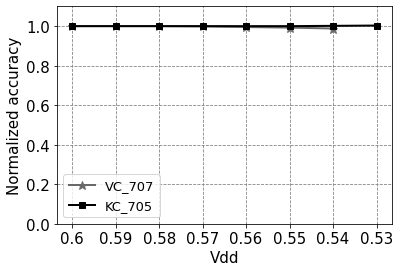

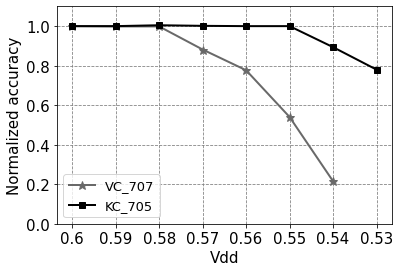

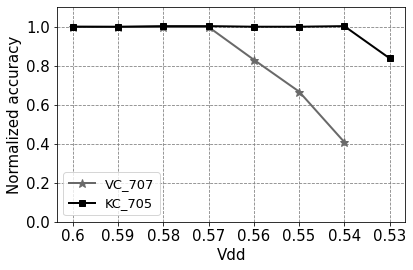

In [53]:
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
x=datos_b2["Voltajes"]
fig = plt.figure(figsize=(20,5), dpi=100)
plt.rcParams.update({'font.size': 15})

fig1, ax1 = plt.subplots()
#ax1= fig.add_subplot(1,3,1)
plt.xticks(x_values, x)
x_values = range(len(x))
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)

fig2, ax2 = plt.subplots()
plt.xticks(x_values, x)
#ax2= fig.add_subplot(1,3,2)
x_values = range(len(x))
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)


fig3, ax3 = plt.subplots()
#ax3= fig.add_subplot(1,3,3)
x_values = range(len(x))
plt.xticks(x_values, x)
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)

ax1.set_ylim(0,1.1)
#ax1.set_title("AlexNet errores en 0 en Pesos y Activaciones")
ax1.invert_xaxis()

ax2.set_ylim(0,1.1)
#ax2.set_title("AlexNet errores en 1 en Pesos y Activaciones")
ax2.invert_xaxis()

ax3.set_ylim(0,1.1)
#ax3.set_title("AlexNet errores en 0 y 1 en Pesos y Activaciones")
ax3.invert_xaxis()



ax1.plot( alexnet_b2_5bit_707_A_P_2["Acc_a_w_cero"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax1.plot(datos_707_A_P_2["Normalize"], color='grey', ls='-', lw='2', marker='D', markersize='6')
ax1.plot(alexnet_f2_A_P["Acc_a_w_cero"], label='KC_705', color='k', ls='-', lw='2', marker='s', markersize='6')
ax1.grid( color = 'gray', linestyle = 'dashed')
ax1.legend(fontsize=13)


ax2.plot(alexnet_b2_5bit_707_A_P_2["Acc_a_w_uno"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax2.plot(datos_707_A_P_2["Normalize"], color='grey', ls='-', lw='2', marker='D', markersize='6')
ax2.plot(alexnet_f2_A_P["Acc_a_w_uno"], label='KC_705', color='k', ls='-', lw='2', marker='s', markersize='6')
ax2.grid( color = 'gray', linestyle = 'dashed')
ax2.legend(fontsize=13)

ax3.plot(alexnet_b2_5bit_707_A_P_2["Acc_a_w_uno_cero"],label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax3.plot(datos_707_A_P_2["Normalize"], color='grey', ls='-', lw='2', marker='D', markersize='6')
ax3.grid( color = 'gray', linestyle = 'dashed')
ax3.plot(alexnet_f2_A_P["Acc_a_w_uno_cero"], label='KC_705', color='k', ls='-', lw='2', marker='s', markersize='6')
ax3.legend(fontsize=13)

pdfFile=PdfPages("Alexnet_pe5bit_y_act_buffer2_0.pdf")
pdfFile.savefig(fig1, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("Alexnet_pe5bit_y_act_buffer2_1.pdf")
pdfFile.savefig(fig2,transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("Alexnet_pe5bit_y_act_buffer2_0_1.pdf")
pdfFile.savefig(fig3, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()

plt.tight_layout()

plt.show

# SqueezeNet  Activaciones  Buffer1

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.ticker as ticker
from pylab import *
Squeez  = pd.read_excel("resultado_SqueezeNet.xlsx")
Squeez_S= Squeez.set_index("Voltajes")

datos_s  = pd.read_excel("resultado_SqueezeNet.xlsx", usecols=["Acc_cero","Acc_uno","Acc_uno_cero","Normalize","mask_0"])/0.9307
datos_s_f2=pd.read_excel("resultado_SqueezeNet.xlsx", sheet_name='fichero_705', usecols=["Acc_cero","Acc_uno","Acc_uno_cero", "Normalize","mask_0"])/0.9307


In [42]:
datos_s
#datos_s
#datos_s_f2

Acc_cero   Acc_uno  Acc_uno_cero  Normalize    mask_0
0       NaN       NaN           NaN        1.0       NaN
1  0.998532  0.131800      0.131800        1.0  0.862469
2  0.999964  0.131800      0.131800        1.0  0.998496
3  0.998532  0.131800      0.133233        1.0  0.999964
4  1.001397  0.217757      0.230651        1.0  0.998532
5  0.999964  0.779342      0.859568        1.0  0.999964
6  0.999964  0.985638      0.999964        1.0  0.999964
7  0.999964  0.999964      0.999964        1.0  0.999964

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 2000x500 with 0 Axes>

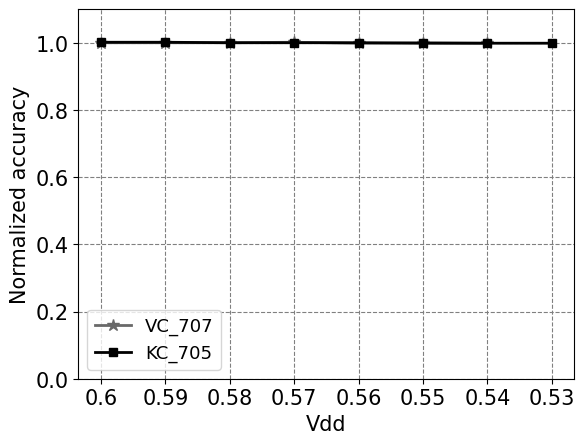

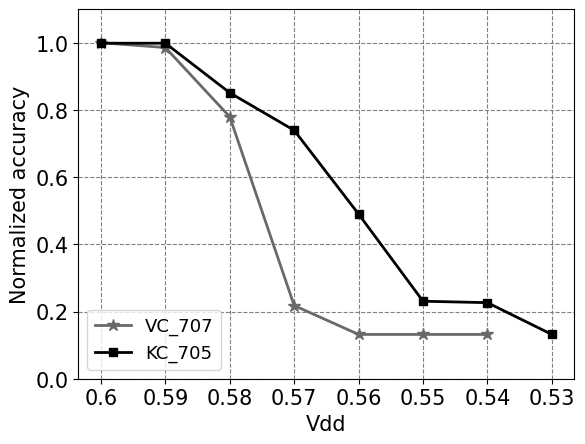

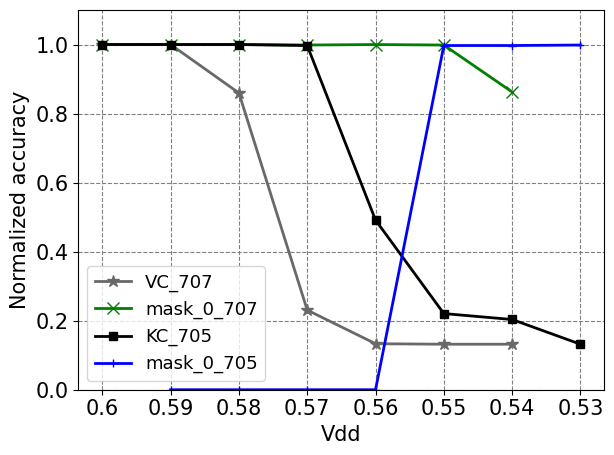

In [44]:
x=datos["Voltajes"]
fig = plt.figure(figsize=(20,5), dpi=100)
plt.rcParams.update({'font.size': 15})

fig.tight_layout
fig1, ax1 = plt.subplots()
#ax1= fig.add_subplot(1,3,1)

x_values = range(len(x))
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)
plt.xticks(x_values, x)
fig2, ax2 = plt.subplots()
#ax2= fig.add_subplot(1,3,2)


x_values = range(len(x))
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)

plt.xticks(x_values, x)
fig3, ax3 = plt.subplots()
#ax3= fig.add_subplot(1,3,3)

x_values = range(len(x))
plt.xticks(x_values, x)
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)
ax1.set_ylim(0,1.1)
#ax1.set_title("SqueezeNet errores en 0 en Activaciones")
ax1.invert_xaxis()

ax2.set_ylim(0,1.1)
#ax2.set_title("SqueezeNet errores en 1 en Activaciones")
ax2.invert_xaxis()

ax3.set_ylim(0,1.1)
#ax3.set_title("SqueezeNet errores en 0 y 1 en Activaciones")
ax3.invert_xaxis()

ax1.plot( datos_s["Acc_cero"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax1.plot(datos_s["Normalize"], color='grey', ls='-', lw='2', marker='D', markersize='6')
ax1.plot(datos_s_f2["Acc_cero"], label='KC_705', color='k', ls='-', lw='2', marker='s', markersize='6')
ax1.grid( color = 'gray', linestyle = 'dashed')
ax1.legend(fontsize=13, loc='lower left')


ax2.plot(datos_s["Acc_uno"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax2.plot(datos_s["Normalize"], color='grey', ls='-', lw='2', marker='D', markersize='6')
ax2.plot(datos_s_f2["Acc_uno"], label='KC_705', color='k', ls='-', lw='2', marker='s', markersize='6')
ax2.grid( color = 'gray', linestyle = 'dashed')
ax2.legend(fontsize=13, loc='lower left')

ax3.plot(datos_s["Acc_uno_cero"],label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
ax3.plot(datos_s["mask_0"],label='mask_0_707', color='g', ls='-', lw='2', marker='x', markersize=9)

#ax3.plot(datos_s["Normalize"], color='grey', ls='-', lw='2', marker='D', markersize='5')
ax3.grid( color = 'gray', linestyle = 'dashed')
ax3.plot(datos_s_f2["Acc_uno_cero"], label='KC_705', color='k', ls='-', lw='2', marker='s', markersize='6')
ax3.plot(datos_s_f2["mask_0"], label='mask_0_705', color="b", ls='-', lw='2', marker='+', markersize=6)
ax3.legend(fontsize=13, loc='lower left')

#pdfFile=PdfPages("Squeezenet_act_0.pdf")
#pdfFile.savefig(fig1, transparent = True, bbox_inches = 'tight', pad_inches = 0)
#pdfFile.close()
#pdfFile=PdfPages("Squeezenet_act_1.pdf")
#pdfFile.savefig(fig2,transparent = True, bbox_inches = 'tight', pad_inches = 0)
#pdfFile.close()
#pdfFile=PdfPages("Squeezenet_act_0_1.pdf")
#pdfFile.savefig(fig3, transparent = True, bbox_inches = 'tight', pad_inches = 0)
#pdfFile.close()

plt.tight_layout()

plt.show

# SqueezeNet Activaciones Buffer2

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.ticker as ticker
from pylab import *
Squeez_a_b2  = pd.read_excel("resultado_SqueezeNet.xlsx", sheet_name='fichero_707_buffer2')
Squeez_act_b2= Squeez_a_b2.set_index("Voltajes")

Squeez_a_b2_707  = pd.read_excel("resultado_SqueezeNet.xlsx", sheet_name='fichero_707_buffer2', usecols=["Acc_cero","Acc_uno","Acc_uno_cero","Normalize"])/0.9307
Squeez_a_b2_705=pd.read_excel("resultado_SqueezeNet.xlsx", sheet_name='fichero_705', usecols=["Acc_cero","Acc_uno","Acc_uno_cero", "Normalize"])/0.9307







In [39]:
#Squeez_a_b2
#Squeez_act_b2
#Squeez_a_b2_707
Squeez_a_b2_705

Acc_cero   Acc_uno  Acc_uno_cero  Normalize
0  0.998532  0.131800      0.131800        1.0
1  0.998532  0.226353      0.203431        1.0
2  0.998532  0.230651      0.220622        1.0
3  0.999964  0.489954      0.491386        1.0
4  0.999964  0.739229      0.997099        1.0
5  0.999964  0.850972      0.999964        1.0
6  1.001397  0.998532      0.999964        1.0
7  1.001397  0.998532      0.999964        1.0

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 2000x500 with 0 Axes>

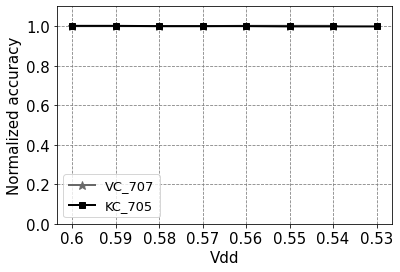

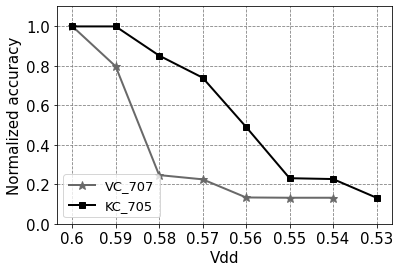

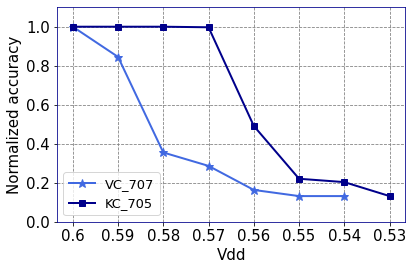

In [40]:
x=Squeez_a_b2["Voltajes"]
fig = plt.figure(figsize=(20,5), dpi=100)
plt.rcParams.update({'font.size': 15})

fig.tight_layout
fig1, ax1 = plt.subplots()
#ax1= fig.add_subplot(1,3,1)

x_values = range(len(x))
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)
plt.xticks(x_values, x)
fig2, ax2 = plt.subplots()
#ax2= fig.add_subplot(1,3,2)


x_values = range(len(x))
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)

plt.xticks(x_values, x)
fig3, ax3 = plt.subplots()
#ax3= fig.add_subplot(1,3,3)

x_values = range(len(x))
plt.xticks(x_values, x)
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)
ax1.set_ylim(0,1.1)
#ax1.set_title("SqueezeNet errores en 0 en Activaciones")
ax1.invert_xaxis()

ax2.set_ylim(0,1.1)
#ax2.set_title("SqueezeNet errores en 1 en Activaciones")
ax2.invert_xaxis()

ax3.set_ylim(0,1.1)
#ax3.set_title("SqueezeNet errores en 0 y 1 en Activaciones")
ax3.invert_xaxis()

ax1.plot( Squeez_a_b2_707["Acc_cero"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax1.plot(Squeez_a_b2_707["Normalize"], color='grey', ls='-', lw='2', marker='D', markersize='6')
ax1.plot(Squeez_a_b2_705["Acc_cero"], label='KC_705', color='k', ls='-', lw='2', marker='s', markersize='6')
ax1.grid( color = 'gray', linestyle = 'dashed')
ax1.legend(fontsize=13, loc='lower left')


ax2.plot(Squeez_a_b2_707["Acc_uno"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax2.plot(Squeez_a_b2_707["Normalize"], color='grey', ls='-', lw='2', marker='D', markersize='6')
ax2.plot(Squeez_a_b2_705["Acc_uno"], label='KC_705', color='k', ls='-', lw='2', marker='s', markersize='6')
ax2.grid( color = 'gray', linestyle = 'dashed')
ax2.legend(fontsize=13, loc='lower left')

ax3.plot(Squeez_a_b2_707["Acc_uno_cero"],label='VC_707', color='royalblue', ls='-', lw='2', marker='*', markersize='9')
#ax3.plot(Squeez_a_b2_707["Normalize"], color='grey', ls='-', lw='2', marker='D', markersize='5')
ax3.plot(Squeez_a_b2_705["Acc_uno_cero"], label='KC_705', color='darkblue', ls='-', lw='2', marker='s', markersize='6')
ax3.grid( color = 'gray', linestyle = 'dashed')
ax3.legend(fontsize=13, loc='lower left')
ax3.spines['top'].set_color('darkblue')
ax3.spines['left'].set_color('darkblue')
ax3.spines['right'].set_color('darkblue')
ax3.spines['bottom'].set_color('darkblue')


pdfFile=PdfPages("Squeezenet_act_buffer2_0.pdf")
pdfFile.savefig(fig1, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("Squeezenet_act_buffer2_1.pdf")
pdfFile.savefig(fig2,transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("Squeezenet_act_buffer2_0_1.pdf")
pdfFile.savefig(fig3, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()

plt.tight_layout()

plt.show

# SqueezeNet Activaciones Buffer2 8 bit actv 4 bit pesos

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.ticker as ticker
from pylab import *
Squeez_a_b2_act_8bit  = pd.read_excel("SqueezeNet_buffer_2_act_8bit_pes_4bit.xlsx", sheet_name='fichero_707_buffer2')
Squeez_a_b2_act_8bit_= Squeez_a_b2_act_8bit.set_index("Voltajes")

Squeez_a_b2_act_8bit_707  = pd.read_excel("SqueezeNet_buffer_2_act_8bit_pes_4bit.xlsx", sheet_name='fichero_707_buffer2', usecols=["Acc_cero","Acc_uno","Acc_uno_cero","Normalize"])/0.9307
Squeez_a_b2_705=pd.read_excel("resultado_SqueezeNet.xlsx", sheet_name='fichero_705', usecols=["Acc_cero","Acc_uno","Acc_uno_cero", "Normalize"])/0.9307




In [23]:
Squeez_a_b2_act_8bit_707

Acc_cero   Acc_uno  Acc_uno_cero  Normalize
0       NaN       NaN           NaN        1.0
1  0.999964  0.131800      0.131800        1.0
2  0.999964  0.131800      0.131800        1.0
3  0.999964  0.131800      0.131800        1.0
4  1.001397  0.206296      0.239246        1.0
5  1.001397  0.124637      0.124637        1.0
6  1.001397  0.489954      0.785072        1.0
7  1.001397  1.001397      1.001397        1.0

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 2000x500 with 0 Axes>

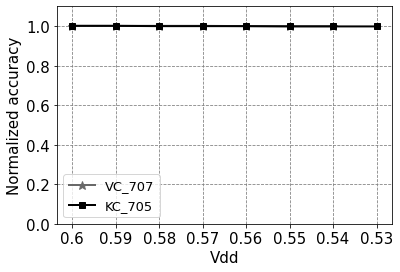

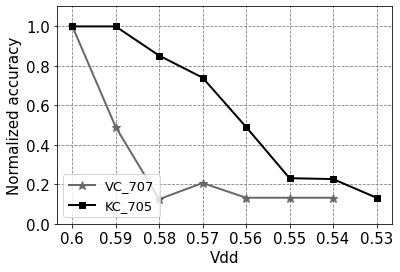

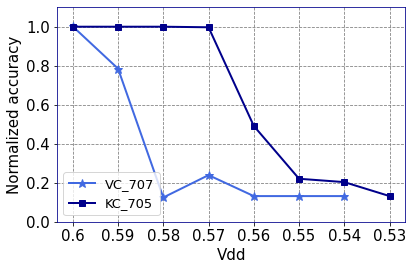

In [24]:
x=Squeez_a_b2_act_8bit["Voltajes"]
fig = plt.figure(figsize=(20,5), dpi=100)
plt.rcParams.update({'font.size': 15})

fig.tight_layout
fig1, ax1 = plt.subplots()
#ax1= fig.add_subplot(1,3,1)

x_values = range(len(x))
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)
plt.xticks(x_values, x)
fig2, ax2 = plt.subplots()
#ax2= fig.add_subplot(1,3,2)


x_values = range(len(x))
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)

plt.xticks(x_values, x)
fig3, ax3 = plt.subplots()
#ax3= fig.add_subplot(1,3,3)

x_values = range(len(x))
plt.xticks(x_values, x)
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)
ax1.set_ylim(0,1.1)
#ax1.set_title("SqueezeNet errores en 0 en Activaciones")
ax1.invert_xaxis()

ax2.set_ylim(0,1.1)
#ax2.set_title("SqueezeNet errores en 1 en Activaciones")
ax2.invert_xaxis()

ax3.set_ylim(0,1.1)
#ax3.set_title("SqueezeNet errores en 0 y 1 en Activaciones")
ax3.invert_xaxis()

ax1.plot( Squeez_a_b2_act_8bit_707["Acc_cero"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
ax1.plot(Squeez_a_b2_705["Acc_cero"], label='KC_705', color='k', ls='-', lw='2', marker='s', markersize='6')
ax1.grid( color = 'gray', linestyle = 'dashed')
ax1.legend(fontsize=13, loc='lower left')


ax2.plot(Squeez_a_b2_act_8bit_707["Acc_uno"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
ax2.plot(Squeez_a_b2_705["Acc_uno"], label='KC_705', color='k', ls='-', lw='2', marker='s', markersize='6')
ax2.grid( color = 'gray', linestyle = 'dashed')
ax2.legend(fontsize=13, loc='lower left')

ax3.plot(Squeez_a_b2_act_8bit_707["Acc_uno_cero"],label='VC_707', color='royalblue', ls='-', lw='2', marker='*', markersize='9')
ax3.plot(Squeez_a_b2_705["Acc_uno_cero"], label='KC_705', color='darkblue', ls='-', lw='2', marker='s', markersize='6')
ax3.grid( color = 'gray', linestyle = 'dashed')
ax3.legend(fontsize=13, loc='lower left')
ax3.spines['top'].set_color('darkblue')
ax3.spines['left'].set_color('darkblue')
ax3.spines['right'].set_color('darkblue')
ax3.spines['bottom'].set_color('darkblue')


pdfFile=PdfPages("Squeezenet_act_8bit_buffer2_0.pdf")
pdfFile.savefig(fig1, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("Squeezenet_act_8bit_buffer2_1.pdf")
pdfFile.savefig(fig2,transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("Squeezenet_act_8bit_buffer2_0_1.pdf")
pdfFile.savefig(fig3, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()

plt.tight_layout()

plt.show

# SqueezeNet Pesos Buffer1

In [648]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.ticker as ticker
from pylab import *
Squeez_p  = pd.read_excel("resultado_SqueezeNet.xlsx")
Squeez_p= Squeez_p.set_index("Voltajes")

Squeez_p_b1_707  = pd.read_excel("resultado_SqueezeNet.xlsx", usecols=["A_w_cero","A_w_uno","A_w_uno_cero","Normalize"])/0.9307
Squeez_p_b1_705=pd.read_excel("resultado_SqueezeNet.xlsx", sheet_name='fichero_705', usecols=["A_w_cero","A_w_uno","A_w_uno_cero", "Normalize"])/0.9307




In [649]:
#Squeez_p 
#Squeez_p_b1_707
#Squeez_p_b1_705


<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 2000x500 with 0 Axes>

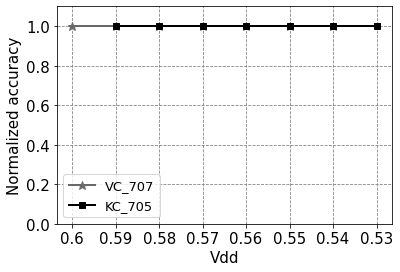

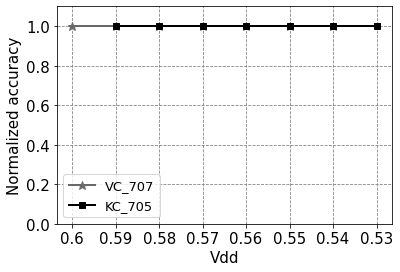

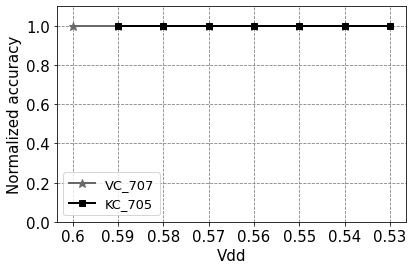

In [650]:
x=datos["Voltajes"]
fig = plt.figure(figsize=(20,5), dpi=100)
plt.rcParams.update({'font.size': 15})

fig.tight_layout
fig1, ax1 = plt.subplots()
#ax1= fig.add_subplot(1,3,1)

x_values = range(len(x))
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)
plt.xticks(x_values, x)
fig2, ax2 = plt.subplots()
#ax2= fig.add_subplot(1,3,2)


x_values = range(len(x))
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)

plt.xticks(x_values, x)
fig3, ax3 = plt.subplots()
#ax3= fig.add_subplot(1,3,3)

x_values = range(len(x))
plt.xticks(x_values, x)
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)
ax1.set_ylim(0,1.1)
#ax1.set_title("SqueezeNet errores en 0 en Activaciones")
ax1.invert_xaxis()

ax2.set_ylim(0,1.1)
#ax2.set_title("SqueezeNet errores en 1 en Activaciones")
ax2.invert_xaxis()

ax3.set_ylim(0,1.1)
#ax3.set_title("SqueezeNet errores en 0 y 1 en Activaciones")
ax3.invert_xaxis()

ax1.plot( Squeez_p_b1_707["A_w_cero"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax1.plot(Squeez_p_b1_707["Normalize"], color='grey', ls='-', lw='2', marker='D', markersize='6')
ax1.plot(Squeez_p_b1_705["A_w_cero"], label='KC_705', color='k', ls='-', lw='2', marker='s', markersize='6')
ax1.grid( color = 'gray', linestyle = 'dashed')
ax1.legend(fontsize=13, loc='lower left')


ax2.plot(Squeez_p_b1_707["A_w_uno"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax2.plot(Squeez_p_b1_707["Normalize"], color='grey', ls='-', lw='2', marker='D', markersize='6')
ax2.plot(Squeez_p_b1_705["A_w_uno"], label='KC_705', color='k', ls='-', lw='2', marker='s', markersize='6')
ax2.grid( color = 'gray', linestyle = 'dashed')
ax2.legend(fontsize=13, loc='lower left')

ax3.plot(Squeez_p_b1_707["A_w_uno_cero"],label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax3.plot(Squeez_p_b1_707["Normalize"], color='grey', ls='-', lw='2', marker='D', markersize='5')
ax3.grid( color = 'gray', linestyle = 'dashed')
ax3.plot(Squeez_p_b1_705["A_w_uno_cero"], label='KC_705', color='k', ls='-', lw='2', marker='s', markersize='6')
ax3.legend(fontsize=13, loc='lower left')

pdfFile=PdfPages("Squeezenet_pe_buffer1_0.pdf")
pdfFile.savefig(fig1, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("Squeezenet_pe_buffer1_1.pdf")
pdfFile.savefig(fig2,transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("Squeezenet_pe_buffer1_0_1.pdf")
pdfFile.savefig(fig3, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()

plt.tight_layout()

plt.show

# SqueezeNet Pesos Buffer2

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.ticker as ticker
from pylab import *
Squeez_p_b2  = pd.read_excel("resultado_SqueezeNet.xlsx", sheet_name='fichero_707_buffer2')
Squeez_p_b2_= Squeez_p_b2.set_index("Voltajes")

Squeez_p_b2_707  = pd.read_excel("resultado_SqueezeNet.xlsx",sheet_name='fichero_707_buffer2', usecols=["A_w_cero","A_w_uno","A_w_uno_cero","Normalize"])/0.9307
Squeez_p_b2_705=pd.read_excel("resultado_SqueezeNet.xlsx", sheet_name='fichero_705', usecols=["A_w_cero","A_w_uno","A_w_uno_cero", "Normalize"])/0.9307




In [42]:
Squeez_p_b2
Squeez_p_b2_707
Squeez_p_b2_705


A_w_cero   A_w_uno  A_w_uno_cero  Normalize
0  0.999964  0.999964      0.999964        1.0
1  0.999964  0.999964      0.999964        1.0
2  0.999964  0.999964      0.999964        1.0
3  0.999964  0.999964      0.999964        1.0
4  0.999964  0.999964      0.999964        1.0
5  0.999964  0.999964      0.999964        1.0
6  0.999964  0.999964      0.999964        1.0
7  0.999964  0.999964      0.999964        1.0

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 2000x500 with 0 Axes>

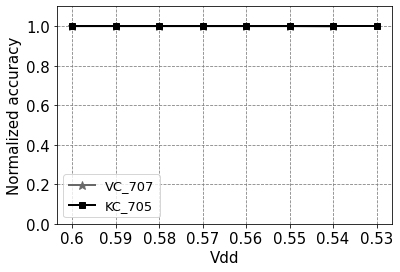

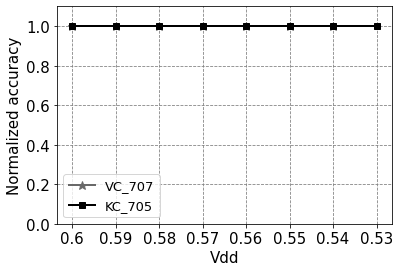

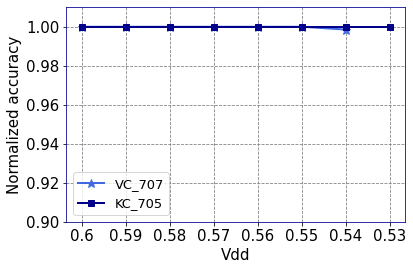

In [43]:
x=Squeez_p_b2["Voltajes"]
fig = plt.figure(figsize=(20,5), dpi=100)
plt.rcParams.update({'font.size': 15})

fig.tight_layout
fig1, ax1 = plt.subplots()
#ax1= fig.add_subplot(1,3,1)

x_values = range(len(x))
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)
plt.xticks(x_values, x)
fig2, ax2 = plt.subplots()
#ax2= fig.add_subplot(1,3,2)


x_values = range(len(x))
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)

plt.xticks(x_values, x)
fig3, ax3 = plt.subplots()
#ax3= fig.add_subplot(1,3,3)

x_values = range(len(x))
plt.xticks(x_values, x)
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)
ax1.set_ylim(0,1.1)
#ax1.set_title("SqueezeNet errores en 0 en Activaciones")
ax1.invert_xaxis()

ax2.set_ylim(0,1.1)
#ax2.set_title("SqueezeNet errores en 1 en Activaciones")
ax2.invert_xaxis()

ax3.set_ylim([0.90,1.01])
#ax3.set_title("SqueezeNet errores en 0 y 1 en Activaciones")
ax3.invert_xaxis()

ax1.plot( Squeez_p_b2_707["A_w_cero"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax1.plot(Squeez_p_b2_707["Normalize"], color='grey', ls='-', lw='2', marker='D', markersize='6')
ax1.plot(Squeez_p_b2_705["A_w_cero"], label='KC_705', color='k', ls='-', lw='2', marker='s', markersize='6')
ax1.grid( color = 'gray', linestyle = 'dashed')
ax1.legend(fontsize=13, loc='lower left')


ax2.plot(Squeez_p_b2_707["A_w_uno"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax2.plot(Squeez_p_b2_707["Normalize"], color='grey', ls='-', lw='2', marker='D', markersize='6')
ax2.plot(Squeez_p_b2_705["A_w_uno"], label='KC_705', color='k', ls='-', lw='2', marker='s', markersize='6')
ax2.grid( color = 'gray', linestyle = 'dashed')
ax2.legend(fontsize=13, loc='lower left')

ax3.plot(Squeez_p_b2_707["A_w_uno_cero"],label='VC_707', color='royalblue', ls='-', lw='2', marker='*', markersize='9')
#ax3.plot(Squeez_p_b2_707["Normalize"], color='grey', ls='-', lw='2', marker='D', markersize='5')
ax3.grid( color = 'gray', linestyle = 'dashed')
ax3.plot(Squeez_p_b2_705["A_w_uno_cero"], label='KC_705', color='darkblue', ls='-', lw='2', marker='s', markersize='6')
ax3.legend(fontsize=13, loc='lower left')
ax3.spines['top'].set_color('darkblue')
ax3.spines['left'].set_color('darkblue')
ax3.spines['right'].set_color('darkblue')
ax3.spines['bottom'].set_color('darkblue')


#plt.ylim(0.95,1.2)

pdfFile=PdfPages("Squeezenet_pe_buffer2_0.pdf")
pdfFile.savefig(fig1, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("Squeezenet_pe_buffer2_1.pdf")
pdfFile.savefig(fig2,transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("Squeezenet_pe_buffer2_0_1.pdf")
pdfFile.savefig(fig3, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()

plt.tight_layout()

plt.show

# SqueezeNet Pesos Buffer2 4 bit parte entera pesos 

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.ticker as ticker
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
from pylab import *

Squeez_p_b2_4bit  = pd.read_excel("SqueezeNet_buffer_2_wgt_4.xlsx", sheet_name='fichero_707_buffer2')
Squeez_p_b2_4bit_= Squeez_p_b2_4bit.set_index("Voltajes")

Squeez_p_b2_4bit_707  = pd.read_excel("SqueezeNet_buffer_2_wgt_4.xlsx",sheet_name='fichero_707_buffer2', usecols=["A_w_cero","A_w_uno","A_w_uno_cero","Normalize"])/0.9307
Squeez_p_b2_705=pd.read_excel("resultado_SqueezeNet.xlsx", sheet_name='fichero_705', usecols=["A_w_cero","A_w_uno","A_w_uno_cero", "Normalize"])/0.9307



In [18]:
Squeez_p_b2_4bit_707

A_w_cero   A_w_uno  A_w_uno_cero  Normalize
0       NaN       NaN           NaN        1.0
1  0.999964  1.001397      0.999964        1.0
2  0.999964  0.999964      0.999964        1.0
3  0.999964  0.999964      0.999964        1.0
4  0.999964  0.999964      0.999964        1.0
5  0.999964  0.999964      0.999964        1.0
6  0.999964  0.999964      0.999964        1.0
7  0.999964  0.999964      0.999964        1.0

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 2000x500 with 0 Axes>

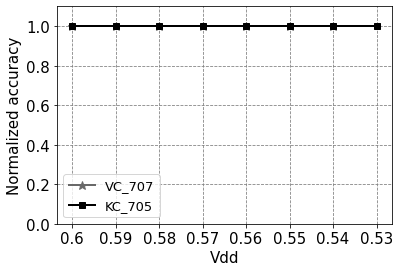

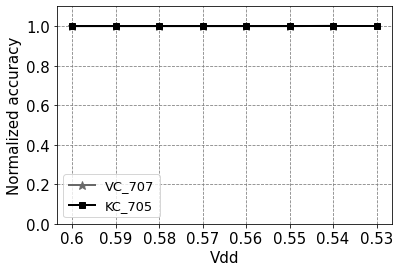

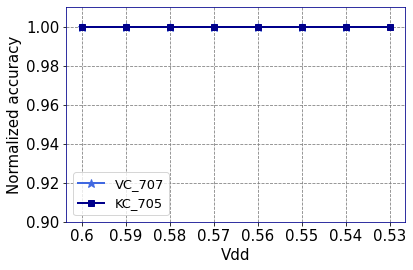

In [19]:
x=Squeez_p_b2_4bit["Voltajes"]
fig = plt.figure(figsize=(20,5), dpi=100)
plt.rcParams.update({'font.size': 15})

fig.tight_layout
fig1, ax1 = plt.subplots()
#ax1= fig.add_subplot(1,3,1)

x_values = range(len(x))
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)
plt.xticks(x_values, x)
fig2, ax2 = plt.subplots()
#ax2= fig.add_subplot(1,3,2)


x_values = range(len(x))
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)

plt.xticks(x_values, x)
fig3, ax3 = plt.subplots()
#ax3= fig.add_subplot(1,3,3)

x_values = range(len(x))
plt.xticks(x_values, x)
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)
ax1.set_ylim(0,1.1)
#ax1.set_title("SqueezeNet errores en 0 en Activaciones")
ax1.invert_xaxis()

ax2.set_ylim(0,1.1)
#ax2.set_title("SqueezeNet errores en 1 en Activaciones")
ax2.invert_xaxis()

ax3.set_ylim([0.90,1.01])
#ax3.set_title("SqueezeNet errores en 0 y 1 en Activaciones")
ax3.invert_xaxis()

ax1.plot( Squeez_p_b2_4bit_707["A_w_cero"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
ax1.plot(Squeez_p_b2_705["A_w_cero"], label='KC_705', color='k', ls='-', lw='2', marker='s', markersize='6')
ax1.grid( color = 'gray', linestyle = 'dashed')
ax1.legend(fontsize=13, loc='lower left')


ax2.plot(Squeez_p_b2_4bit_707["A_w_uno"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
ax2.plot(Squeez_p_b2_705["A_w_uno"], label='KC_705', color='k', ls='-', lw='2', marker='s', markersize='6')
ax2.grid( color = 'gray', linestyle = 'dashed')
ax2.legend(fontsize=13, loc='lower left')

ax3.plot(Squeez_p_b2_4bit_707["A_w_uno_cero"],label='VC_707', color='royalblue', ls='-', lw='2', marker='*', markersize='9')
ax3.grid( color = 'gray', linestyle = 'dashed')
ax3.plot(Squeez_p_b2_705["A_w_uno_cero"], label='KC_705', color='darkblue', ls='-', lw='2', marker='s', markersize='6')
ax3.legend(fontsize=13, loc='lower left')
ax3.spines['top'].set_color('darkblue')
ax3.spines['left'].set_color('darkblue')
ax3.spines['right'].set_color('darkblue')
ax3.spines['bottom'].set_color('darkblue')


#plt.ylim(0.95,1.2)

pdfFile=PdfPages("Squeezenet_pe_4bit_buffer2_0.pdf")
pdfFile.savefig(fig1, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("Squeezenet_pe_4bit_buffer2_1.pdf")
pdfFile.savefig(fig2,transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("Squeezenet_4bitu_pe_buffer2_0_1.pdf")
pdfFile.savefig(fig3, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()

plt.tight_layout()

plt.show

# SqueezeNet  Activaciones y Pesos  Buffer1

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.ticker as ticker
from pylab import *
Squeez_a_p_b1  = pd.read_excel("resultado_SqueezeNet.xlsx")
Squeez_act_p_b1= Squeez_a_p_b1.set_index("Voltajes")

Squeez_a_p_b1_707  = pd.read_excel("resultado_SqueezeNet.xlsx", usecols=["Acc_a_w_cero","Acc_a_w_uno","Acc_a_w_uno_cero","Normalize"])/0.9307
Squeez_a_p_b1_705=pd.read_excel("resultado_SqueezeNet.xlsx", sheet_name='fichero_705', usecols=["Acc_a_w_cero","Acc_a_w_uno","Acc_a_w_uno_cero", "Normalize"])/0.9307


In [129]:
Squeez_act_p_b1
Squeez_a_p_b1_707
Squeez_a_p_b1_705

Acc_a_w_cero  Acc_a_w_uno  Acc_a_w_uno_cero  Normalize
0      0.998532     0.131800          0.131800        1.0
1      0.998532     0.226353          0.203431        1.0
2      0.998532     0.230651          0.220622        1.0
3      0.999964     0.489954          0.491386        1.0
4      0.999964     0.739229          0.997099        1.0
5      0.999964     0.850972          0.999964        1.0
6      1.001397     0.998532          0.999964        1.0
7      1.001397     0.998532          0.999964        1.0

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 2000x500 with 0 Axes>

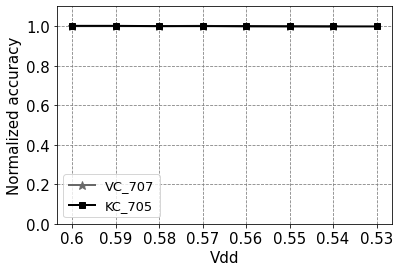

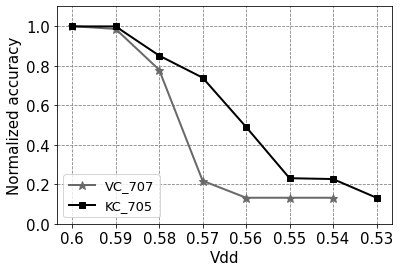

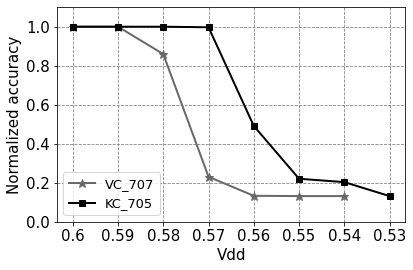

In [130]:
x=Squeez_a_p_b1["Voltajes"]
fig = plt.figure(figsize=(20,5), dpi=100)
plt.rcParams.update({'font.size': 15})

fig1, ax1 = plt.subplots()
#ax1= fig.add_subplot(1,3,1)
x_values = range(len(x))
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)

plt.xticks(x_values, x)
#ax2= fig.add_subplot(1,3,2)
fig2, ax2 = plt.subplots()
x_values = range(len(x))
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)

plt.xticks(x_values, x)
fig3, ax3 = plt.subplots()
#ax3= fig.add_subplot(1,3,3)
x_values = range(len(x))
plt.xticks(x_values, x)
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)

ax1.set_ylim(0,1.1)
#ax1.set_title("SqueezeNet errores en 0 en Activaciones")
ax1.invert_xaxis()

ax2.set_ylim(0,1.1)
#ax2.set_title("SqueezeNet errores en 1 en Activaciones")
ax2.invert_xaxis()

ax3.set_ylim(0,1.1)
#ax3.set_title("SqueezeNet errores en 0 y 1 en Activaciones")
ax3.invert_xaxis()

ax1.plot( Squeez_a_p_b1_707["Acc_a_w_cero"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax1.plot(Squeez_a_p_b1_707["Normalize"], color='grey', ls='-', lw='2', marker='D', markersize='6')
ax1.plot(Squeez_a_p_b1_705["Acc_a_w_cero"], label='KC_705', color='k', ls='-', lw='2', marker='s', markersize='6')
ax1.grid( color = 'gray', linestyle = 'dashed')
ax1.legend(fontsize=13, loc='lower left')


ax2.plot(Squeez_a_p_b1_707["Acc_a_w_uno"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax2.plot(Squeez_a_p_b1_707["Normalize"], color='grey', ls='-', lw='2', marker='D', markersize='6')
ax2.plot(Squeez_a_p_b1_705["Acc_a_w_uno"], label='KC_705', color='k', ls='-', lw='2', marker='s', markersize='6')
ax2.grid( color = 'gray', linestyle = 'dashed')
ax2.legend(fontsize=13, loc='lower left')

ax3.plot(Squeez_a_p_b1_707["Acc_a_w_uno_cero"],label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax3.plot(Squeez_a_p_b1_707["Normalize"], color='grey', ls='-', lw='2', marker='D', markersize='5')
ax3.plot(Squeez_a_p_b1_705["Acc_a_w_uno_cero"], label='KC_705', color='k', ls='-', lw='2', marker='s', markersize='6')
ax3.grid( color = 'gray', linestyle = 'dashed')
ax3.legend(fontsize=13, loc='lower left')



pdfFile=PdfPages("Squeezenet_pe_y_act_buffer1_0.pdf")
pdfFile.savefig(fig1, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("Squeezenet_pe_y_act_buffer1_1.pdf")
pdfFile.savefig(fig2,transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("Squeezenet_pe_y_act_buffer1_1_0.pdf")
pdfFile.savefig(fig3, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()

plt.tight_layout()


plt.show

# SqueezeNet Activaciones y Pesos Buffer2

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.ticker as ticker
from pylab import *
Squeez_a_p_b2  = pd.read_excel("resultado_SqueezeNet.xlsx", sheet_name='fichero_707_buffer2')
Squeez_act_p_b2= Squeez_a_p_b2.set_index("Voltajes")

Squeez_a_p_b2_707  = pd.read_excel("resultado_SqueezeNet.xlsx", sheet_name='fichero_707_buffer2', usecols=["Acc_a_w_cero","Acc_a_w_uno","Acc_a_w_uno_cero","Normalize"])/0.9307
Squeez_a_p_b2_705=pd.read_excel("resultado_SqueezeNet.xlsx", sheet_name='fichero_705', usecols=["Acc_a_w_cero","Acc_a_w_uno","Acc_a_w_uno_cero", "Normalize"])/0.9307


In [132]:
Squeez_act_p_b2
Squeez_a_p_b2_707
Squeez_a_p_b2_705

Acc_a_w_cero  Acc_a_w_uno  Acc_a_w_uno_cero  Normalize
0      0.998532     0.131800          0.131800        1.0
1      0.998532     0.226353          0.203431        1.0
2      0.998532     0.230651          0.220622        1.0
3      0.999964     0.489954          0.491386        1.0
4      0.999964     0.739229          0.997099        1.0
5      0.999964     0.850972          0.999964        1.0
6      1.001397     0.998532          0.999964        1.0
7      1.001397     0.998532          0.999964        1.0

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 2000x500 with 0 Axes>

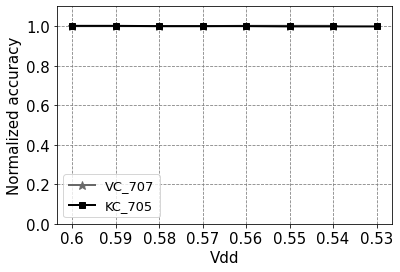

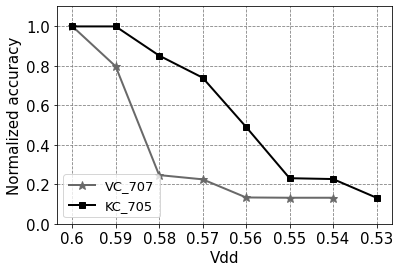

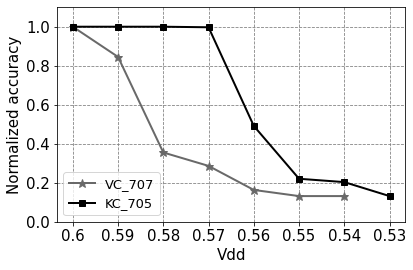

In [133]:
x=Squeez_a_p_b2["Voltajes"]
fig = plt.figure(figsize=(20,5), dpi=100)
plt.rcParams.update({'font.size': 15})

fig1, ax1 = plt.subplots()
#ax1= fig.add_subplot(1,3,1)
x_values = range(len(x))
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)

plt.xticks(x_values, x)
#ax2= fig.add_subplot(1,3,2)
fig2, ax2 = plt.subplots()
x_values = range(len(x))
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)

plt.xticks(x_values, x)
fig3, ax3 = plt.subplots()
#ax3= fig.add_subplot(1,3,3)
x_values = range(len(x))
plt.xticks(x_values, x)
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)

ax1.set_ylim(0,1.1)
#ax1.set_title("SqueezeNet errores en 0 en Activaciones")
ax1.invert_xaxis()

ax2.set_ylim(0,1.1)
#ax2.set_title("SqueezeNet errores en 1 en Activaciones")
ax2.invert_xaxis()

ax3.set_ylim(0,1.1)
#ax3.set_title("SqueezeNet errores en 0 y 1 en Activaciones")
ax3.invert_xaxis()

ax1.plot( Squeez_a_p_b2_707["Acc_a_w_cero"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax1.plot(Squeez_a_p_b2_707["Normalize"], color='grey', ls='-', lw='2', marker='D', markersize='6')
ax1.plot(Squeez_a_p_b2_705["Acc_a_w_cero"], label='KC_705', color='k', ls='-', lw='2', marker='s', markersize='6')
ax1.grid( color = 'gray', linestyle = 'dashed')
ax1.legend(fontsize=13, loc='lower left')


ax2.plot(Squeez_a_p_b2_707["Acc_a_w_uno"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax2.plot(Squeez_a_p_b2_707["Normalize"], color='grey', ls='-', lw='2', marker='D', markersize='6')
ax2.plot(Squeez_a_p_b2_705["Acc_a_w_uno"], label='KC_705', color='k', ls='-', lw='2', marker='s', markersize='6')
ax2.grid( color = 'gray', linestyle = 'dashed')
ax2.legend(fontsize=13, loc='lower left')

ax3.plot(Squeez_a_p_b2_707["Acc_a_w_uno_cero"],label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax3.plot(Squeez_a_p_b2_707["Normalize"], color='grey', ls='-', lw='2', marker='D', markersize='5')
ax3.grid( color = 'gray', linestyle = 'dashed')
ax3.plot(Squeez_a_p_b2_705["Acc_a_w_uno_cero"], label='KC_705', color='k', ls='-', lw='2', marker='s', markersize='6')
ax3.legend(fontsize=13, loc='lower left')



pdfFile=PdfPages("Squeezenet_pe_y_act_buffer2_0.pdf")
pdfFile.savefig(fig1, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("Squeezenet_pe_y_act_buffer2_1.pdf")
pdfFile.savefig(fig2,transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("Squeezenet_pe_y_act_buffer2_1_0.pdf")
pdfFile.savefig(fig3, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()

plt.tight_layout()


plt.show

# MobileNet Activaciones  Buffer1

In [597]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.ticker as ticker
from pylab import *
datos_Mo  = pd.read_excel("resultado_MobileNet.xlsx")
df= datos_Mo.set_index("Voltajes")
datos_M  = pd.read_excel("resultado_MobileNet.xlsx", usecols=["Acc_cero","Acc_uno","Acc_uno_cero","Normalize"])/0.8813
datos_f2_M_=pd.read_excel("resultado_MobileNet.xlsx", sheet_name='fichero_705', usecols=["Acc_cero","Acc_uno","Acc_uno_cero","Normalize"])/0.8813



In [598]:
#datos_Mo
#df
datos_M
#datos_f2_M_


Acc_cero   Acc_uno  Acc_uno_cero  Normalize
0       NaN       NaN           NaN        1.0
1  0.833617  0.139188      0.143727        1.0
2  0.856311  0.163395      0.240554        1.0
3  0.972805  0.414539      0.721661        1.0
4  0.995499  0.760997      0.841182        1.0
5  1.001551  0.959189      0.993986        1.0
6  1.000038  0.986422      1.000038        1.0
7  1.000038  0.998525      1.000038        1.0

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 2000x500 with 0 Axes>

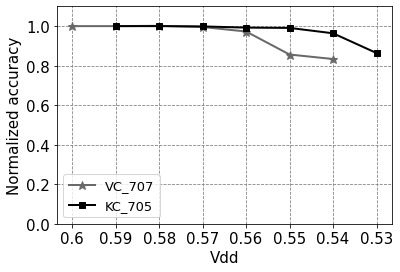

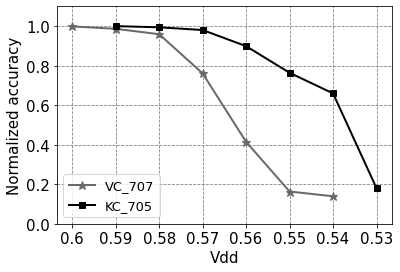

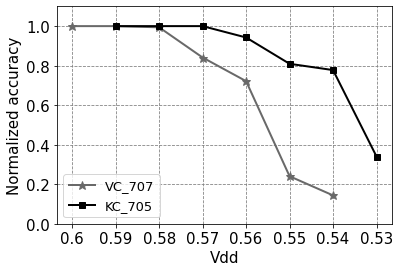

In [599]:
x=datos["Voltajes"]
fig = plt.figure(figsize=(20,5), dpi=100)
plt.rcParams.update({'font.size': 15})

fig1, ax1 = plt.subplots()
#ax1= fig.add_subplot(1,3,1)
plt.xticks(x_values, x)
x_values = range(len(x))
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy',fontsize=15)


fig2, ax2 = plt.subplots()
#ax2= fig.add_subplot(1,3,2)
plt.xticks(x_values, x)
x_values = range(len(x))
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy',fontsize=15)

fig3, ax3 = plt.subplots()
#ax3= fig.add_subplot(1,3,3)
plt.xticks(x_values, x)
x_values = range(len(x))
plt.xticks(x_values, x)
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy',fontsize=15)

ax1.set_ylim(0,1.1)
#ax1.set_title("MobileNet errores en 0 en activaciones")
ax1.invert_xaxis()

ax2.set_ylim(0,1.1)
#ax2.set_title("MobileNet errores en 1 en activaciones")
ax2.invert_xaxis()

ax3.set_ylim(0,1.1)
#ax3.set_title("MobileNet errores en 1 y 0 en activaciones")
ax3.invert_xaxis()




ax1.plot(datos_M["Acc_cero"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax1.plot(datos_M["Normalize"], color='grey', ls='-', lw='2', marker='D', markersize='6')
ax1.plot(datos_f2_M_["Acc_cero"], label='KC_705', color='k', ls='-', lw='2', marker='s', markersize='6')
ax1.grid( color = 'gray', linestyle = 'dashed')
ax1.legend(fontsize=13, loc='lower left')


ax2.plot(datos_M["Acc_uno"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax2.plot(datos_M["Normalize"],  color='grey', ls='-', lw='2', marker='D', markersize='6')
ax2.plot(datos_f2_M_["Acc_uno"], label='KC_705', color='k', ls='-', lw='2', marker='s', markersize='6')
ax2.grid( color = 'gray', linestyle = 'dashed')
ax2.legend(fontsize=13, loc='lower left')

ax3.plot(datos_M["Acc_uno_cero"],label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax3.plot(datos_M["Normalize"],  color='grey', ls='-', lw='2', marker='D', markersize='6')
ax3.plot(datos_f2_M_["Acc_uno_cero"], label='KC_705', color='k', ls='-', lw='2', marker='s', markersize='6')
ax3.grid( color = 'gray', linestyle = 'dashed')
ax3.legend(fontsize=13, loc='lower left')

plt.ylabel('Normalized accuracy', fontsize=15)
pdfFile=PdfPages("Mobilenet_act_0.pdf")
pdfFile.savefig(fig1, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("Mobilenet_act_1.pdf")
pdfFile.savefig(fig2,transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("Mobilenet_act_0_1.pdf")
pdfFile.savefig(fig3, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()

plt.show

# MobileNet Pesos Buffer1

In [651]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.ticker as ticker
from pylab import *
datos_Mo  = pd.read_excel("resultado_MobileNet.xlsx")
datos_Mo= datos_Mo.set_index("Voltajes")
MobileN_p_b1_707  = pd.read_excel("resultado_MobileNet.xlsx", usecols=["A_w_cero","A_w_uno","A_w_uno_cero","Normalize"])/0.8813
MobileN_p_b1_705 =pd.read_excel("resultado_MobileNet.xlsx", sheet_name='fichero_705', usecols=["A_w_cero","A_w_uno","A_w_uno_cero","Normalize"])/0.8813



In [653]:
#datos_Mo
MobileN_p_b1_707
#MobileN_p_b1_705

A_w_cero   A_w_uno  A_w_uno_cero  Normalize
0       NaN       NaN           NaN        1.0
1  0.986422  0.989447      0.984909        1.0
2  1.000038  0.992473      1.000038        1.0
3  1.001551  1.000038      1.001551        1.0
4  1.000038  1.000038      1.000038        1.0
5  1.000038  1.000038      1.000038        1.0
6  1.000038  1.000038      1.000038        1.0
7  1.000038  1.000038      1.000038        1.0

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 2000x500 with 0 Axes>

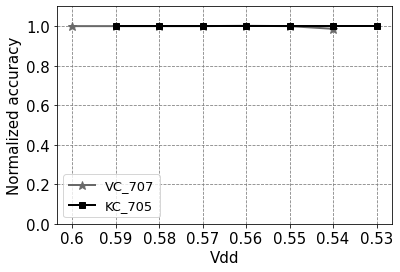

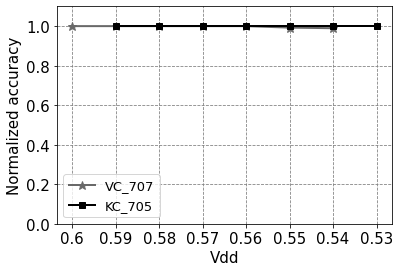

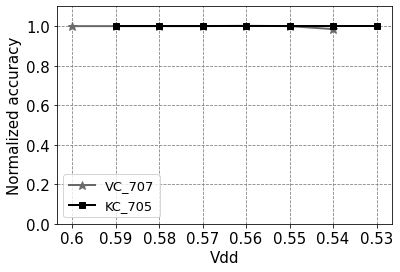

In [657]:
x=datos["Voltajes"]
fig = plt.figure(figsize=(20,5), dpi=100)
plt.rcParams.update({'font.size': 15})

fig1, ax1 = plt.subplots()
#ax1= fig.add_subplot(1,3,1)
plt.xticks(x_values, x)
x_values = range(len(x))
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy',fontsize=15)


fig2, ax2 = plt.subplots()
#ax2= fig.add_subplot(1,3,2)
plt.xticks(x_values, x)
x_values = range(len(x))
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy',fontsize=15)

fig3, ax3 = plt.subplots()
#ax3= fig.add_subplot(1,3,3)
plt.xticks(x_values, x)
x_values = range(len(x))
plt.xticks(x_values, x)
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy',fontsize=15)

ax1.set_ylim(0,1.1)
#ax1.set_title("MobileNet errores en 0 en activaciones")
ax1.invert_xaxis()

ax2.set_ylim(0,1.1)
#ax2.set_title("MobileNet errores en 1 en activaciones")
ax2.invert_xaxis()

ax3.set_ylim(0,1.1)
#ax3.set_title("MobileNet errores en 1 y 0 en activaciones")
ax3.invert_xaxis()




ax1.plot(MobileN_p_b1_707["A_w_cero"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax1.plot(MobileN_p_b1_707["Normalize"], color='grey', ls='-', lw='2', marker='D', markersize='6')
ax1.plot(MobileN_p_b1_705["A_w_cero"], label='KC_705', color='k', ls='-', lw='2', marker='s', markersize='6')
ax1.grid( color = 'gray', linestyle = 'dashed')
ax1.legend(fontsize=13, loc='lower left')


ax2.plot(MobileN_p_b1_707["A_w_uno"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax2.plot(MobileN_p_b1_707["Normalize"],  color='grey', ls='-', lw='2', marker='D', markersize='6')
ax2.plot(MobileN_p_b1_705["A_w_uno"], label='KC_705', color='k', ls='-', lw='2', marker='s', markersize='6')
ax2.grid( color = 'gray', linestyle = 'dashed')
ax2.legend(fontsize=13, loc='lower left')

ax3.plot(MobileN_p_b1_707["A_w_uno_cero"],label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax3.plot(MobileN_p_b1_707["Normalize"],  color='grey', ls='-', lw='2', marker='D', markersize='6')
ax3.plot(MobileN_p_b1_705["A_w_uno_cero"], label='KC_705', color='k', ls='-', lw='2', marker='s', markersize='6')
ax3.grid( color = 'gray', linestyle = 'dashed')
ax3.legend(fontsize=13, loc='lower left')
plt.ylabel('Normalized accuracy', fontsize=15)

pdfFile=PdfPages("Mobilenet_pe_buffer1_0.pdf")
pdfFile.savefig(fig1, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("Mobilenet_pe_buffer1_1.pdf")
pdfFile.savefig(fig2,transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("Mobilenet_pe_buffer1_0_1.pdf")
pdfFile.savefig(fig3, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()

plt.show

# MobileNet Activaciones y Pesos Buffer1

In [661]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.ticker as ticker
from pylab import *
datos_Mo  = pd.read_excel("resultado_MobileNet.xlsx")
datos_Mo= datos_Mo.set_index("Voltajes")
MobileN_a_p_b1_707  = pd.read_excel("resultado_MobileNet.xlsx", usecols=["Acc_a_w_cero","Acc_a_w_uno","Acc_a_w_uno_cero","Normalize"])/0.8813
MobileN_a_p_b1_705 =pd.read_excel("resultado_MobileNet.xlsx", sheet_name='fichero_705', usecols=["Acc_a_w_cero","Acc_a_w_uno","Acc_a_w_uno_cero","Normalize"])/0.8813


In [662]:
MobileN_a_p_b1_707
#MobileN_a_p_b1_705

Acc_a_w_cero  Acc_a_w_uno  Acc_a_w_uno_cero  Normalize
0           NaN          NaN               NaN        1.0
1      0.827565     0.140701          0.142214        1.0
2      0.851772     0.164908          0.237528        1.0
3      0.969779     0.414539          0.711071        1.0
4      0.995499     0.760997          0.841182        1.0
5      1.001551     0.959189          0.993986        1.0
6      1.000038     0.986422          1.000038        1.0
7      1.000038     0.998525          1.000038        1.0

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 2000x500 with 0 Axes>

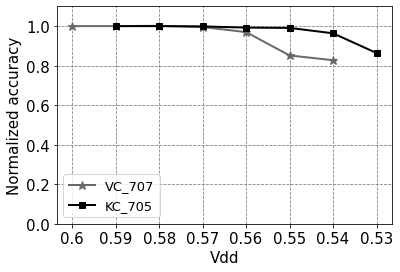

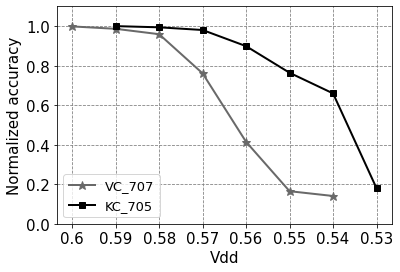

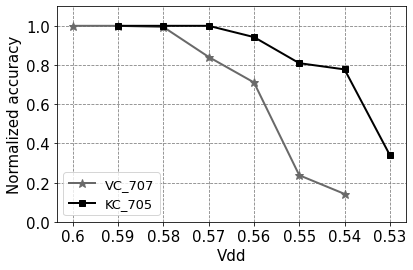

In [667]:
x=datos["Voltajes"]
fig = plt.figure(figsize=(20,5), dpi=100)
plt.rcParams.update({'font.size': 15})

fig1, ax1 = plt.subplots()
#ax1= fig.add_subplot(1,3,1)
x_values = range(len(x))
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)

plt.xticks(x_values, x)
#ax2= fig.add_subplot(1,3,2)
fig2, ax2 = plt.subplots()
x_values = range(len(x))
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)

plt.xticks(x_values, x)
fig3, ax3 = plt.subplots()
#ax3= fig.add_subplot(1,3,3)
x_values = range(len(x))
plt.xticks(x_values, x)
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)

ax1.set_ylim(0,1.1)
#ax1.set_title("MobileNet errores en 0 en Activaciones")
ax1.invert_xaxis()

ax2.set_ylim(0,1.1)
#ax2.set_title("MobileNet errores en 1 en Activaciones")
ax2.invert_xaxis()

ax3.set_ylim(0,1.1)
#ax3.set_title("MobileNet errores en 0 y 1 en Activaciones")
ax3.invert_xaxis()

ax1.plot( MobileN_a_p_b1_707["Acc_a_w_cero"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax1.plot(MobileN_a_p_b1_707["Normalize"], color='grey', ls='-', lw='2', marker='D', markersize='6')
ax1.plot(MobileN_a_p_b1_705["Acc_a_w_cero"], label='KC_705', color='k', ls='-', lw='2', marker='s', markersize='6')
ax1.grid( color = 'gray', linestyle = 'dashed')
ax1.legend(fontsize=13, loc='lower left')


ax2.plot(MobileN_a_p_b1_707["Acc_a_w_uno"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax2.plot(MobileN_a_p_b1_707["Normalize"], color='grey', ls='-', lw='2', marker='D', markersize='6')
ax2.plot(MobileN_a_p_b1_705["Acc_a_w_uno"], label='KC_705', color='k', ls='-', lw='2', marker='s', markersize='6')
ax2.grid( color = 'gray', linestyle = 'dashed')
ax2.legend(fontsize=13, loc='lower left')

ax3.plot(MobileN_a_p_b1_707["Acc_a_w_uno_cero"],label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax3.plot(MobileN_a_p_b1_707["Normalize"], color='grey', ls='-', lw='2', marker='D', markersize='5')
ax3.grid( color = 'gray', linestyle = 'dashed')
ax3.plot(MobileN_a_p_b1_705["Acc_a_w_uno_cero"], label='KC_705', color='k', ls='-', lw='2', marker='s', markersize='6')
ax3.legend(fontsize=13, loc='lower left')



pdfFile=PdfPages("MobileNet_pe_y_act_buffer1_0.pdf")
pdfFile.savefig(fig1, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("MobileNet_pe_y_act_buffer1_1.pdf")
pdfFile.savefig(fig2,transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("MobileNet_pe_y_act_buffer1_0_1.pdf")
pdfFile.savefig(fig3, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()

plt.tight_layout()


plt.show

# MobileNet Activaciones Buffer2

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.ticker as ticker
from pylab import *
MobileNet_a_b2  = pd.read_excel("resultado_MobileNet.xlsx" , sheet_name='fichero_707_buffer2')
MobileNet_act_b2= MobileNet_a_b2.set_index("Voltajes")

MobileNet_a_b2__707  = pd.read_excel("resultado_MobileNet.xlsx", sheet_name='fichero_707_buffer2', usecols=["Acc_cero","Acc_uno","Acc_uno_cero","Normalize"])/0.8813
MobileNet_a_b2_705=pd.read_excel("resultado_MobileNet.xlsx", sheet_name='fichero_705', usecols=["Acc_cero","Acc_uno","Acc_uno_cero","Normalize"])/0.8813



In [53]:
#MobileNet_act_b2
MobileNet_a_b2__707
#MobileNet_a_b2_705

Acc_cero   Acc_uno  Acc_uno_cero  Normalize
0       NaN       NaN           NaN        1.0
1  0.820001  0.139188      0.139188        1.0
2  0.836643  0.139188      0.145240        1.0
3  0.860850  0.225425      0.499262        1.0
4  0.993986  0.735277      0.800333        1.0
5  0.993986  0.833617      0.957676        1.0
6  0.998525  0.906237      0.997012        1.0
7  1.000038  1.000038      1.000038        1.0

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 2000x500 with 0 Axes>

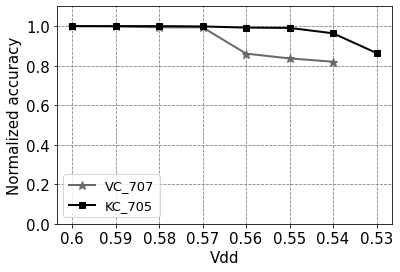

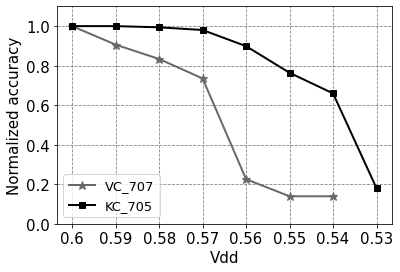

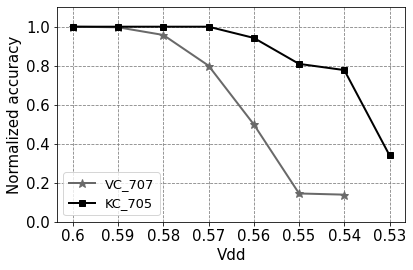

In [54]:
x=MobileNet_a_b2["Voltajes"]
fig = plt.figure(figsize=(20,5), dpi=100)
plt.rcParams.update({'font.size': 15})

fig1, ax1 = plt.subplots()
#ax1= fig.add_subplot(1,3,1)
x_values = range(len(x))
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)

plt.xticks(x_values, x)
#ax2= fig.add_subplot(1,3,2)
fig2, ax2 = plt.subplots()
x_values = range(len(x))
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)

plt.xticks(x_values, x)
fig3, ax3 = plt.subplots()
#ax3= fig.add_subplot(1,3,3)
x_values = range(len(x))
plt.xticks(x_values, x)
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)

ax1.set_ylim(0,1.1)
#ax1.set_title("MobileNet errores en 0 en Activaciones")
ax1.invert_xaxis()

ax2.set_ylim(0,1.1)
#ax2.set_title("MobileNet errores en 1 en Activaciones")
ax2.invert_xaxis()

ax3.set_ylim(0,1.1)
#ax3.set_title("MobileNet errores en 0 y 1 en Activaciones")
ax3.invert_xaxis()

ax1.plot( MobileNet_a_b2__707["Acc_cero"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax1.plot(MobileNet_a_b2__707["Normalize"], color='grey', ls='-', lw='2', marker='D', markersize='6')
ax1.plot(MobileNet_a_b2_705["Acc_cero"], label='KC_705', color='k', ls='-', lw='2', marker='s', markersize='6')
ax1.grid( color = 'gray', linestyle = 'dashed')
ax1.legend(fontsize=13, loc='lower left')


ax2.plot(MobileNet_a_b2__707["Acc_uno"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax2.plot(MobileNet_a_b2__707["Normalize"], color='grey', ls='-', lw='2', marker='D', markersize='6')
ax2.plot(MobileNet_a_b2_705["Acc_uno"], label='KC_705', color='k', ls='-', lw='2', marker='s', markersize='6')
ax2.grid( color = 'gray', linestyle = 'dashed')
ax2.legend(fontsize=13, loc='lower left')

ax3.plot(MobileNet_a_b2__707["Acc_uno_cero"],label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax3.plot(MobileNet_a_b2__707["Normalize"], color='grey', ls='-', lw='2', marker='D', markersize='5')
ax3.grid( color = 'gray', linestyle = 'dashed')
ax3.plot(MobileNet_a_b2_705["Acc_uno_cero"], label='KC_705', color='k', ls='-', lw='2', marker='s', markersize='6')
ax3.legend(fontsize=13, loc='lower left')



pdfFile=PdfPages("MobileNet_act_buffer2_0.pdf")
pdfFile.savefig(fig1, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("MobileNet_act_buffer2_1.pdf")
pdfFile.savefig(fig2,transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("MobileNet_act_buffer2_0_1.pdf")
pdfFile.savefig(fig3, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()

plt.tight_layout()


plt.show

# MobileNet Pesos   Buffer2

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.ticker as ticker
from pylab import *
MobileNet_b2  = pd.read_excel("resultado_MobileNet.xlsx" , sheet_name='fichero_707_buffer2')
MobileNet_b2_= MobileNet_b2.set_index("Voltajes")
MobileNet_b2_707  = pd.read_excel("resultado_MobileNet.xlsx", sheet_name='fichero_707_buffer2', usecols=["A_w_cero","A_w_uno","A_w_uno_cero","Normalize"])/0.8813
MobileNet_b2_705=pd.read_excel("resultado_MobileNet.xlsx", sheet_name='fichero_705', usecols=["A_w_cero","A_w_uno","A_w_uno_cero","Normalize"])/0.8813



#datos_b2  = pd.read_excel("analisis_ficheros.xlsx", sheet_name='fichero_707_2parte_buffer')
#datos_b2= datos_b2.set_index("Voltajes")
#
#datos_707_P_2  = pd.read_excel("analisis_ficheros.xlsx", sheet_name='fichero_707_2parte_buffer', usecols=["A_w_cero","A_w_uno","A_w_uno_cero", "Normalize"])/0.8907
#datos_f2_P=pd.read_excel("analisis_ficheros.xlsx", sheet_name='fichero_705', usecols=["A_w_cero","A_w_uno","A_w_uno_cero", "Normalize"])/0.8907



In [59]:
MobileNet_b2
#MobileNet_b2_707
#MobileNet_b2_705


Voltajes  Acc_cero  A_w_cero  Acc_a_w_cero   Acc_uno   A_w_uno  \
0      0.53       NaN       NaN           NaN       NaN       NaN   
1      0.54  0.722667  0.766667      0.724000  0.122667  0.117333   
2      0.55  0.737333  0.869333      0.737333  0.122667  0.837333   
3      0.56  0.758667  0.869333      0.777333  0.198667  0.836000   
4      0.57  0.876000  0.878667      0.877333  0.648000  0.868000   
5      0.58  0.876000  0.881333      0.876000  0.734667  0.881333   
6      0.59  0.880000  0.881333      0.880000  0.798667  0.881333   
7      0.60  0.881333  0.881333      0.881333  0.881333  0.881333   

   Acc_a_w_uno  Acc_uno_cero  A_w_uno_cero  Acc_a_w_uno_cero  Normalize  
0          NaN           NaN           NaN               NaN     0.8813  
1     0.117333      0.122667      0.117333          0.117333     0.8813  
2     0.122667      0.128000      0.869333          0.126667     0.8813  
3     0.162667      0.440000      0.869333          0.405333     0.8813  
4     0.640000      0.705333      0.878667          0.702667     0.8813  
5     0.734667      0.844000      0.881333          0.844000     0.8813  
6     0.798667      0.878667      0.881333          0.878667     0.8813  
7     0.881333      0.881333      0.881333          0.881333     0.8813

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 2000x500 with 0 Axes>

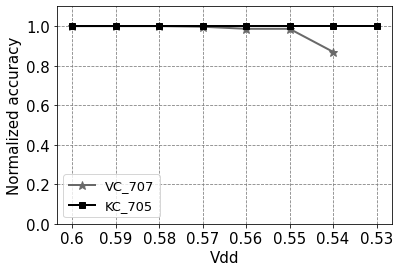

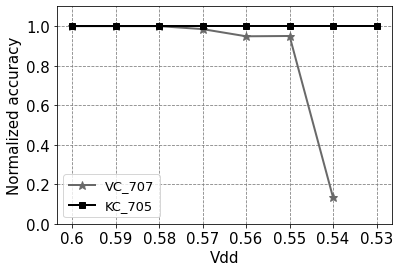

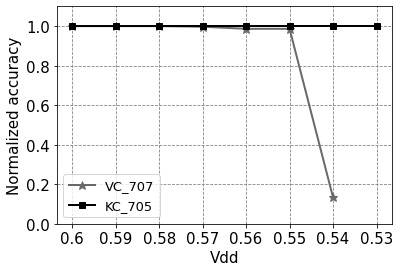

In [60]:
x=MobileNet_b2["Voltajes"]
fig = plt.figure(figsize=(20,5), dpi=100)
plt.rcParams.update({'font.size': 15})

fig1, ax1 = plt.subplots()
#ax1= fig.add_subplot(1,3,1)
plt.xticks(x_values, x)
x_values = range(len(x))
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy',fontsize=15)


fig2, ax2 = plt.subplots()
#ax2= fig.add_subplot(1,3,2)
plt.xticks(x_values, x)
x_values = range(len(x))
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy',fontsize=15)

fig3, ax3 = plt.subplots()
#ax3= fig.add_subplot(1,3,3)
plt.xticks(x_values, x)
x_values = range(len(x))
plt.xticks(x_values, x)
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy',fontsize=15)

ax1.set_ylim(0,1.1)
#ax1.set_title("MobileNet errores en 0 en activaciones")
ax1.invert_xaxis()

ax2.set_ylim(0,1.1)
#ax2.set_title("MobileNet errores en 1 en activaciones")
ax2.invert_xaxis()

ax3.set_ylim(0,1.1)
#ax3.set_title("MobileNet errores en 1 y 0 en activaciones")
ax3.invert_xaxis()




ax1.plot(MobileNet_b2_707["A_w_cero"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax1.plot(MobileNet_b2_707["Normalize"], color='grey', ls='-', lw='2', marker='D', markersize='6')
ax1.plot(MobileNet_b2_705["A_w_cero"], label='KC_705', color='k', ls='-', lw='2', marker='s', markersize='6')
ax1.grid( color = 'gray', linestyle = 'dashed')
ax1.legend(fontsize=13, loc='lower left')


ax2.plot(MobileNet_b2_707["A_w_uno"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax2.plot(datos_M["Normalize"],  color='grey', ls='-', lw='2', marker='D', markersize='6')
ax2.plot(MobileNet_b2_705["A_w_uno"], label='KC_705', color='k', ls='-', lw='2', marker='s', markersize='6')
ax2.grid( color = 'gray', linestyle = 'dashed')
ax2.legend(fontsize=13, loc='lower left')

ax3.plot(MobileNet_b2_707["A_w_uno_cero"],label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax3.plot(MobileNet_b2_707["Normalize"],  color='grey', ls='-', lw='2', marker='D', markersize='6')
ax3.plot(MobileNet_b2_705["A_w_uno_cero"], label='KC_705', color='k', ls='-', lw='2', marker='s', markersize='6')
ax3.grid( color = 'gray', linestyle = 'dashed')
ax3.legend(fontsize=13, loc='lower left')
plt.ylabel('Normalized accuracy', fontsize=15)

pdfFile=PdfPages("Mobilenet_pe_0.pdf")
pdfFile.savefig(fig1, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("Mobilenet_pe_1.pdf")
pdfFile.savefig(fig2,transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("Mobilenet_pe_0_1.pdf")
pdfFile.savefig(fig3, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()

plt.show

# MobileNet Activaciones y Pesos Buffer2

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.ticker as ticker
from pylab import *
MobileNet_a_p_b2  = pd.read_excel("resultado_MobileNet.xlsx" , sheet_name='fichero_707_buffer2')
MobileNet_ac_p_b2= MobileNet_a_p_b2.set_index("Voltajes")
MobileNet_a_p_b2_707  = pd.read_excel("resultado_MobileNet.xlsx", sheet_name='fichero_707_buffer2', usecols=["Acc_a_w_cero","Acc_a_w_uno","Acc_a_w_uno_cero","Normalize"])/0.8813
MobileNet_a_p_b2_705=pd.read_excel("resultado_MobileNet.xlsx", sheet_name='fichero_705', usecols=["Acc_a_w_cero","Acc_a_w_uno","Acc_a_w_uno_cero","Normalize"])/0.8813


In [62]:
#MobileNet_ac_p_b2
MobileNet_a_p_b2_707
#MobileNet_a_p_b2_705

Acc_a_w_cero  Acc_a_w_uno  Acc_a_w_uno_cero  Normalize
0           NaN          NaN               NaN        1.0
1      0.821514     0.133137          0.133137        1.0
2      0.836643     0.139188          0.143727        1.0
3      0.882030     0.184576          0.459927        1.0
4      0.995499     0.726200          0.797307        1.0
5      0.993986     0.833617          0.957676        1.0
6      0.998525     0.906237          0.997012        1.0
7      1.000038     1.000038          1.000038        1.0

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 2000x500 with 0 Axes>

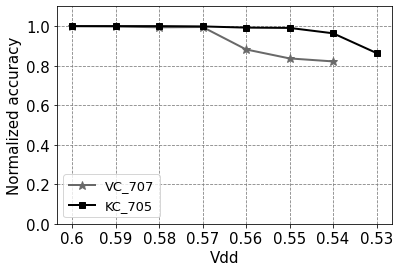

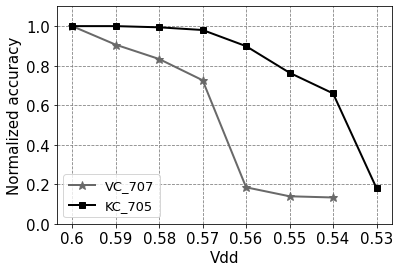

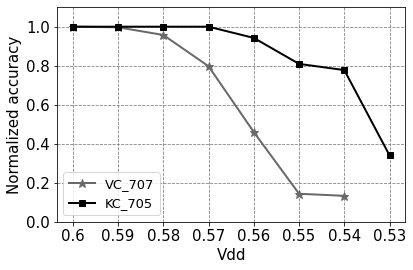

In [63]:
x=MobileNet_a_p_b2["Voltajes"]
fig = plt.figure(figsize=(20,5), dpi=100)
plt.rcParams.update({'font.size': 15})

fig1, ax1 = plt.subplots()
#ax1= fig.add_subplot(1,3,1)
x_values = range(len(x))
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)

plt.xticks(x_values, x)
#ax2= fig.add_subplot(1,3,2)
fig2, ax2 = plt.subplots()
x_values = range(len(x))
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)

plt.xticks(x_values, x)
fig3, ax3 = plt.subplots()
#ax3= fig.add_subplot(1,3,3)
x_values = range(len(x))
plt.xticks(x_values, x)
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)

ax1.set_ylim(0,1.1)
#ax1.set_title("MobileNet errores en 0 en Activaciones")
ax1.invert_xaxis()

ax2.set_ylim(0,1.1)
#ax2.set_title("MobileNet errores en 1 en Activaciones")
ax2.invert_xaxis()

ax3.set_ylim(0,1.1)
#ax3.set_title("MobileNet errores en 0 y 1 en Activaciones")
ax3.invert_xaxis()

ax1.plot( MobileNet_a_p_b2_707["Acc_a_w_cero"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax1.plot(MobileNet_a_p_b2_707["Normalize"], color='grey', ls='-', lw='2', marker='D', markersize='6')
ax1.plot(MobileNet_a_p_b2_705["Acc_a_w_cero"], label='KC_705', color='k', ls='-', lw='2', marker='s', markersize='6')
ax1.grid( color = 'gray', linestyle = 'dashed')
ax1.legend(fontsize=13, loc='lower left')


ax2.plot(MobileNet_a_p_b2_707["Acc_a_w_uno"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax2.plot(MobileNet_a_p_b2_707["Normalize"], color='grey', ls='-', lw='2', marker='D', markersize='6')
ax2.plot(MobileNet_a_p_b2_705["Acc_a_w_uno"], label='KC_705', color='k', ls='-', lw='2', marker='s', markersize='6')
ax2.grid( color = 'gray', linestyle = 'dashed')
ax2.legend(fontsize=13, loc='lower left')

ax3.plot(MobileNet_a_p_b2_707["Acc_a_w_uno_cero"],label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize='9')
#ax3.plot(MobileNet_a_p_b2_707["Normalize"], color='grey', ls='-', lw='2', marker='D', markersize='5')
ax3.grid( color = 'gray', linestyle = 'dashed')
ax3.plot(MobileNet_a_p_b2_705["Acc_a_w_uno_cero"], label='KC_705', color='k', ls='-', lw='2', marker='s', markersize='6')
ax3.legend(fontsize=13, loc='lower left')



pdfFile=PdfPages("MobileNet_pe_y_act_buffer2_0.pdf")
pdfFile.savefig(fig1, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("MobileNet_pe_y_act_buffer2_1.pdf")
pdfFile.savefig(fig2,transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("MobileNet_pe_y_act_buffer2_0_1.pdf")
pdfFile.savefig(fig3, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()

plt.tight_layout()


plt.show

# DenseNet Activaciones primera parte del Buffer

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.ticker as ticker
from pylab import *

DenseNet_  = pd.read_excel("resultado_DenseNet.xlsx")
DenseNet= DenseNet_.set_index("Voltajes")

DenseNet_707  = pd.read_excel("resultado_DenseNet.xlsx", usecols=["Acc_cero","Acc_uno","Acc_uno_cero", "Normalize"])/0.9160
DenseNet_705=pd.read_excel("resultado_DenseNet.xlsx", sheet_name='fichero_705', usecols=["Acc_cero","Acc_uno","Acc_uno_cero", "Normalize"])/0.9160


In [12]:
DenseNet
#DenseNet_707
#DenseNet_705


Acc_cero  A_w_cero  Acc_a_w_cero   Acc_uno   A_w_uno  Acc_a_w_uno  \
Voltajes                                                                      
0.53           NaN       NaN           NaN       NaN       NaN          NaN   
0.54      0.910667     0.916      0.910667  0.517333  0.914667     0.513333   
0.55      0.916000     0.916      0.916000  0.804000  0.914667     0.804000   
0.56      0.916000     0.916      0.916000  0.902667  0.916000     0.902667   
0.57      0.916000     0.916      0.916000  0.918667  0.916000     0.918667   
0.58      0.916000     0.916      0.916000  0.916000  0.916000     0.916000   
0.59      0.916000     0.916      0.916000  0.913333  0.916000     0.913333   
0.60      0.916000     0.916      0.916000  0.916000  0.916000     0.916000   

          Acc_uno_cero  A_w_uno_cero  Acc_a_w_uno_cero  Normalize  
Voltajes                                                           
0.53               NaN           NaN               NaN      0.916  
0.54          0.636000         0.916          0.636000      0.916  
0.55          0.893333         0.916          0.893333      0.916  
0.56          0.913333         0.916          0.913333      0.916  
0.57          0.914667         0.916          0.914667      0.916  
0.58          0.913333         0.916          0.913333      0.916  
0.59          0.916000         0.916          0.916000      0.916  
0.60          0.916000         0.916          0.916000      0.916

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 2000x500 with 0 Axes>

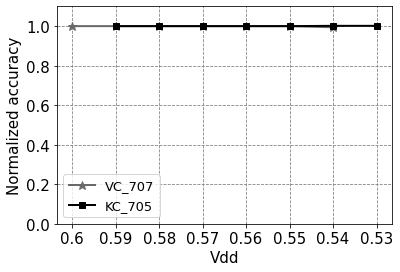

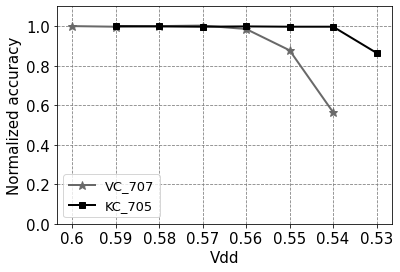

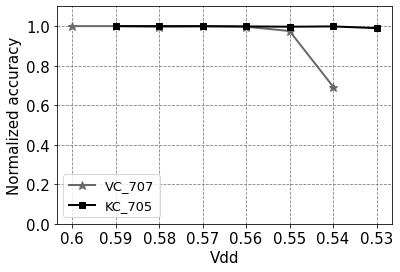

In [31]:
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
x=DenseNet_["Voltajes"]
fig = plt.figure(figsize=(20,5), dpi=100)
plt.rcParams.update({'font.size': 15})

fig1, ax1 = plt.subplots()
#ax1= fig.add_subplot(1,3,1)
x_values = range(len(x))
plt.xlabel('Vdd', fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)
plt.xticks(x_values, x)

fig2, ax2 = plt.subplots()
#ax2= fig.add_subplot(1,3,2)
x_values = range(len(x))
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)
plt.xticks(x_values, x)

fig3, ax3 = plt.subplots()
#ax3= fig.add_subplot(1,3,3)
x_values = range(len(x))
plt.xlabel('Vdd', fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)
plt.xticks(x_values, x)


ax1.set_ylim(0,1.1)
#ax1.set_title("DenseNet errores en 0 en activaciones")
ax1.invert_xaxis()

ax2.set_ylim(0,1.1)
#ax2.set_title("DenseNet errores en 1 en activaciones")
ax2.invert_xaxis()

ax3.set_ylim(0,1.1)
#ax3.set_title("DenseNet errores en 1 y 0 en activaciones")
ax3.invert_xaxis()



ax1.plot(DenseNet_707["Acc_cero"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize=9)
#ax1.plot(DenseNet_707["Normalize"], color='dimgray', ls='-', lw='2', marker='D', markersize='6')
ax1.plot(DenseNet_705["Acc_cero"], label='KC_705', color="k", ls='-', lw='2', marker='s', markersize=6)
ax1.grid( color = 'gray', linestyle = 'dashed')
ax1.legend(fontsize=13)


ax2.plot(DenseNet_707["Acc_uno"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize=9)
#ax2.plot(DenseNet_707["Normalize"],  color='dimgray', ls='-', lw='2', marker='D', markersize='6')
ax2.plot(DenseNet_705["Acc_uno"], label='KC_705', color="k", ls='-', lw='2', marker='s', markersize=6)
ax2.grid( color = 'gray', linestyle = 'dashed')
ax2.legend(fontsize=13)

ax3.plot(DenseNet_707["Acc_uno_cero"],label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize=9)
#ax3.plot(DenseNet_707["Normalize"],  color='dimgray', ls='-', lw='2', marker='D', markersize='6')
ax3.plot(DenseNet_705["Acc_uno_cero"], label='KC_705', color="k", ls='-', lw='2', marker='s', markersize=6)
ax3.grid( color = 'gray', linestyle = 'dashed')
ax3.legend(fontsize=13)



pdfFile=PdfPages("Densenet_act_0.pdf")
pdfFile.savefig(fig1, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("Densenet_act_1.pdf")
pdfFile.savefig(fig2,transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("Densenet_act_0_1.pdf")
pdfFile.savefig(fig3, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()




plt.show

# DenseNet Pesos  Buffer 1

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.ticker as ticker
from pylab import *
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
DenseNet_P_  = pd.read_excel("resultado_DenseNet.xlsx")
DenseNet_p= DenseNet_P_.set_index("Voltajes")



DenseNet_P_b1_707  = pd.read_excel("resultado_DenseNet.xlsx", usecols=["A_w_cero","A_w_uno","A_w_uno_cero", "Normalize"])/0.9133
DenseNet_P_b1_705=pd.read_excel("resultado_DenseNet.xlsx", sheet_name='fichero_705', usecols=["A_w_cero","A_w_uno","A_w_uno_cero", "Normalize"])/0.9133




In [39]:
#DenseNet_P
DenseNet_P_b1_707
#DenseNet_P_b1_705

A_w_cero   A_w_uno  A_w_uno_cero  Normalize
0       NaN       NaN           NaN   1.002956
1  1.002956  1.001496      1.002956   1.002956
2  1.002956  1.001496      1.002956   1.002956
3  1.002956  1.002956      1.002956   1.002956
4  1.002956  1.002956      1.002956   1.002956
5  1.002956  1.002956      1.002956   1.002956
6  1.002956  1.002956      1.002956   1.002956
7  1.002956  1.002956      1.002956   1.002956

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 2000x500 with 0 Axes>

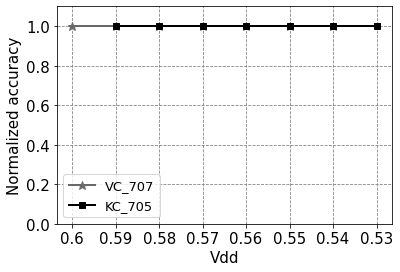

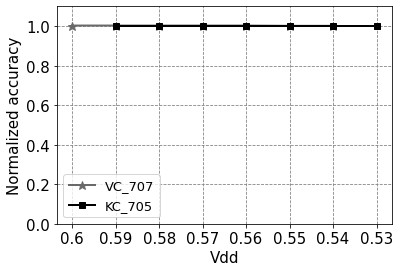

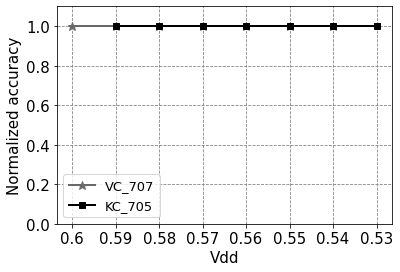

In [40]:
x=DenseNet_P_["Voltajes"]
fig = plt.figure(figsize=(20,5), dpi=100)
plt.rcParams.update({'font.size': 15})

fig1, ax1 = plt.subplots()
#ax1= fig.add_subplot(1,3,1)
x_values = range(len(x))
plt.xlabel('Vdd', fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)
plt.xticks(x_values, x)

fig2, ax2 = plt.subplots()
#ax2= fig.add_subplot(1,3,2)
x_values = range(len(x))
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)
plt.xticks(x_values, x)

fig3, ax3 = plt.subplots()
#ax3= fig.add_subplot(1,3,3)
x_values = range(len(x))
plt.xlabel('Vdd', fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)
plt.xticks(x_values, x)


ax1.set_ylim(0,1.1)
#ax1.set_title("DenseNet errores en 0 en activaciones")
ax1.invert_xaxis()

ax2.set_ylim(0,1.1)
#ax2.set_title("DenseNet errores en 1 en activaciones")
ax2.invert_xaxis()

ax3.set_ylim(0,1.1)
#ax3.set_title("DenseNet errores en 1 y 0 en activaciones")
ax3.invert_xaxis()



ax1.plot(DenseNet_P_b1_707["A_w_cero"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize=9)
#ax1.plot(DenseNet_P_b1_707["Normalize"], color='dimgray', ls='-', lw='2', marker='D', markersize='6')
ax1.plot(DenseNet_P_b1_705["A_w_cero"], label='KC_705', color="k", ls='-', lw='2', marker='s', markersize=6)
ax1.grid( color = 'gray', linestyle = 'dashed')
ax1.legend(fontsize=13)


ax2.plot(DenseNet_P_b1_707["A_w_uno"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize=9)
#ax2.plot(DenseNet_P_b1_707["Normalize"],  color='dimgray', ls='-', lw='2', marker='D', markersize='6')
ax2.plot(DenseNet_P_b1_705["A_w_uno"], label='KC_705', color="k", ls='-', lw='2', marker='s', markersize=6)
ax2.grid( color = 'gray', linestyle = 'dashed')
ax2.legend(fontsize=13)

ax3.plot(DenseNet_P_b1_707["A_w_uno_cero"],label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize=9)
#ax3.plot(DenseNet_P_b1_707["Normalize"],  color='dimgray', ls='-', lw='2', marker='D', markersize='6')
ax3.plot(DenseNet_P_b1_705["A_w_uno_cero"], label='KC_705', color="k", ls='-', lw='2', marker='s', markersize=6)
ax3.grid( color = 'gray', linestyle = 'dashed')
ax3.legend(fontsize=13)



pdfFile=PdfPages("Densenet_pes_b1_0.pdf")
pdfFile.savefig(fig1, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("Densenet_pes_b1_1.pdf")
pdfFile.savefig(fig2,transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("Densenet_pes_b1_0_1.pdf")
pdfFile.savefig(fig3, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()


plt.show

# DenseNet Activaciones y Pesos Buffer 1

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.ticker as ticker
from pylab import *
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
DenseNet_p_a_b1  = pd.read_excel("resultado_DenseNet.xlsx")
DenseNet_p_y_a_b1= DenseNet_p_a_b1.set_index("Voltajes")

DenseNet_P_A_b1_707  = pd.read_excel("resultado_DenseNet.xlsx", usecols=["Acc_a_w_cero","Acc_a_w_uno","Acc_a_w_uno_cero", "Normalize"])/0.9133
DenseNet_P_A_b1_705=pd.read_excel("resultado_DenseNet.xlsx", sheet_name='fichero_705', usecols=["Acc_a_w_cero","Acc_a_w_uno","Acc_a_w_uno_cero", "Normalize"])/0.9133



In [47]:
#DenseNet_p_y_a_b1
#DenseNet_P_A_b1_707
DenseNet_P_A_b1_705


Acc_a_w_cero  Acc_a_w_uno  Acc_a_w_uno_cero  Normalize
0      1.004416     0.867185          0.992737   1.002956
1      1.004416     1.000037          1.001496   1.002956
2      1.002956     1.000037          1.000037   1.002956
3      1.002956     1.001496          1.001496   1.002956
4      1.002956     1.000037          1.002956   1.002956
5      1.002956     1.001496          1.002956   1.002956
6      1.002956     1.002956          1.002956   1.002956
7           NaN          NaN               NaN   1.002956

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 2000x500 with 0 Axes>

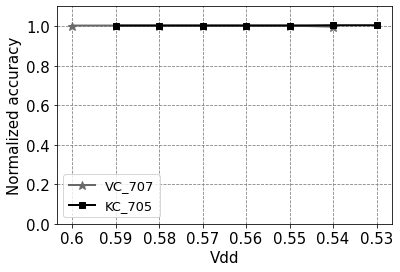

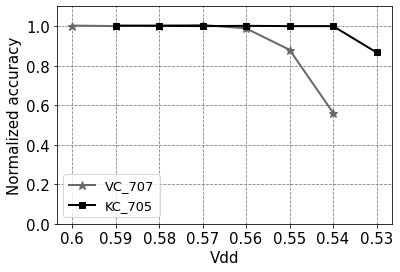

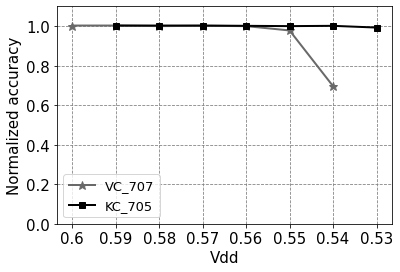

In [98]:
x=DenseNet_P_["Voltajes"]
fig = plt.figure(figsize=(20,5), dpi=100)
plt.rcParams.update({'font.size': 15})

fig1, ax1 = plt.subplots()
#ax1= fig.add_subplot(1,3,1)
x_values = range(len(x))
plt.xlabel('Vdd', fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)
plt.xticks(x_values, x)

fig2, ax2 = plt.subplots()
#ax2= fig.add_subplot(1,3,2)
x_values = range(len(x))
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)
plt.xticks(x_values, x)

fig3, ax3 = plt.subplots()
#ax3= fig.add_subplot(1,3,3)
x_values = range(len(x))
plt.xlabel('Vdd', fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)
plt.xticks(x_values, x)


ax1.set_ylim(0,1.1)
#ax1.set_title("DenseNet errores en 0 en activaciones")
ax1.invert_xaxis()

ax2.set_ylim(0,1.1)
#ax2.set_title("DenseNet errores en 1 en activaciones")
ax2.invert_xaxis()

ax3.set_ylim(0,1.1)
#ax3.set_title("DenseNet errores en 1 y 0 en activaciones")
ax3.invert_xaxis()



ax1.plot(DenseNet_P_A_b1_707["Acc_a_w_cero"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize=9)
#ax1.plot(DenseNet_P_A_b1_707["Normalize"], color='dimgray', ls='-', lw='2', marker='D', markersize='6')
ax1.plot(DenseNet_P_A_b1_705["Acc_a_w_cero"], label='KC_705', color="k", ls='-', lw='2', marker='s', markersize=6)
ax1.grid( color = 'gray', linestyle = 'dashed')
ax1.legend(fontsize=13)


ax2.plot(DenseNet_P_A_b1_707["Acc_a_w_uno"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize=9)
#ax2.plot(v["Normalize"],  color='dimgray', ls='-', lw='2', marker='D', markersize='6')
ax2.plot(DenseNet_P_A_b1_705["Acc_a_w_uno"], label='KC_705', color="k", ls='-', lw='2', marker='s', markersize=6)
ax2.grid( color = 'gray', linestyle = 'dashed')
ax2.legend(fontsize=13)

ax3.plot(DenseNet_P_A_b1_707["Acc_a_w_uno_cero"],label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize=9)
#ax3.plot(DenseNet_P_A_b1_707["Normalize"],  color='dimgray', ls='-', lw='2', marker='D', markersize='6')
ax3.plot(DenseNet_P_A_b1_705["Acc_a_w_uno_cero"], label='KC_705', color="k", ls='-', lw='2', marker='s', markersize=6)
ax3.grid( color = 'gray', linestyle = 'dashed')
ax3.legend(fontsize=13)



pdfFile=PdfPages("Densenet_pes_y_act_buffer1_0.pdf")
pdfFile.savefig(fig1, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("Densenet_pes_y_act_buffer1_1.pdf")
pdfFile.savefig(fig2,transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("Densenet_pes_y_act_buffer1_0_1.pdf")
pdfFile.savefig(fig3, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()


plt.show

# Tarea pendiente Crear un modulo para graficar
# la graficas se guarden en una carpeta para ellas

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.ticker as ticker
from pylab import *
from matplotlib.backends.backend_pdf import PdfPages, PdfFile

def Graficar:(dicrecc_excel,tipo_graf):
        with open(dicrecc_excel + '.xlsx', 'rb') as f:
        data = f.read()
        
        if tipo_graf==activ:
            ##### llamo a una funcion que grafica las graficas de activaciones
        elif  tipo_graf==pesos:
            ##### llamo a una funcion que grafica las graficas de pesos
        elif  tipo_graf== act_pesos
              ### llamo a una funcion que grafica las graficas de pesos
            
            
            
        
        
        
    

# DenseNet Pesos Buffer 2

In [95]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.ticker as ticker
from pylab import *
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
DenNet_P_b2  = pd.read_excel("resultado_DenseNet.xlsx", sheet_name='fichero_707_buffer2')
DenseNet_p_b2= DenNet_P_b2.set_index("Voltajes")



DenNet_P_b2_707  = pd.read_excel("resultado_DenseNet.xlsx", sheet_name='fichero_707_buffer2', usecols=["A_w_cero","A_w_uno","A_w_uno_cero", "Normalize"])/0.9133
DenNet_P_b2_705=pd.read_excel("resultado_DenseNet.xlsx", sheet_name='fichero_705', usecols=["A_w_cero","A_w_uno","A_w_uno_cero", "Normalize"])/0.9133



#MobileNet_b2  = pd.read_excel("resultado_MobileNet.xlsx" , sheet_name='fichero_707_buffer2')
#MobileNet_b2= MobileNet_b2.set_index("Voltajes")
#MobileNet_b2_707  = pd.read_excel("resultado_MobileNet.xlsx", sheet_name='fichero_707_buffer2', usecols=["A_w_cero","A_w_uno","A_w_uno_cero","Normalize"])/0.8813
#MobileNet_b2_705=pd.read_excel("resultado_MobileNet.xlsx", sheet_name='fichero_705', usecols=["A_w_cero","A_w_uno","A_w_uno_cero","Normalize"])/0.8813
#


In [96]:
DenseNet_p_b2
#DenNet_P_b2_707
#DenNet_P_b2_705

Acc_cero  A_w_cero  Acc_a_w_cero   Acc_uno   A_w_uno  Acc_a_w_uno  \
Voltajes                                                                      
0.53           NaN       NaN           NaN       NaN       NaN          NaN   
0.54      0.920000  0.117333      0.117333  0.368000  0.117333     0.117333   
0.55      0.917333  0.917333      0.917333  0.632000  0.914667     0.621333   
0.56      0.914667  0.917333      0.916000  0.896000  0.914667     0.897333   
0.57      0.916000  0.917333      0.917333  0.918667  0.916000     0.920000   
0.58      0.916000  0.916000      0.916000  0.916000  0.916000     0.916000   
0.59      0.916000  0.916000      0.916000  0.916000  0.916000     0.916000   
0.60      0.916000  0.916000      0.916000  0.916000  0.916000     0.916000   

          Acc_uno_cero  A_w_uno_cero  Acc_a_w_uno_cero  Normalize  
Voltajes                                                           
0.53               NaN           NaN               NaN     0.9133  
0.54          0.516000      0.117333          0.117333     0.9133  
0.55          0.740000      0.917333          0.741333     0.9133  
0.56          0.913333      0.917333          0.913333     0.9133  
0.57          0.917333      0.917333          0.920000     0.9133  
0.58          0.914667      0.916000          0.914667     0.9133  
0.59          0.916000      0.916000          0.916000     0.9133  
0.60          0.916000      0.916000          0.916000     0.9160

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 2000x500 with 0 Axes>

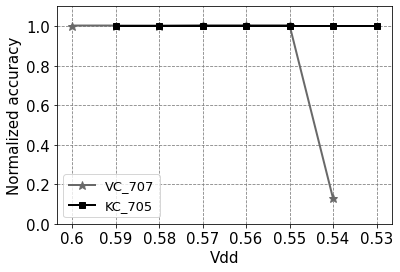

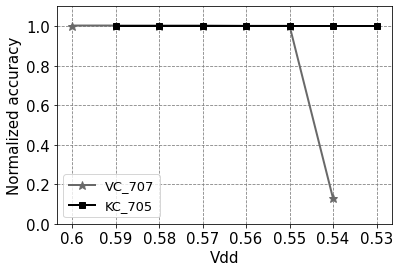

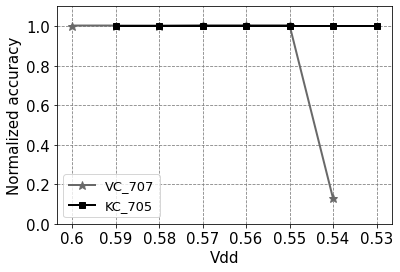

In [98]:
x=DenNet_P_b2["Voltajes"]
fig = plt.figure(figsize=(20,5), dpi=100)
plt.rcParams.update({'font.size': 15})

fig1, ax1 = plt.subplots()
#ax1= fig.add_subplot(1,3,1)
x_values = range(len(x))
plt.xlabel('Vdd', fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)
plt.xticks(x_values, x)

fig2, ax2 = plt.subplots()
#ax2= fig.add_subplot(1,3,2)
x_values = range(len(x))
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)
plt.xticks(x_values, x)

fig3, ax3 = plt.subplots()
#ax3= fig.add_subplot(1,3,3)
x_values = range(len(x))
plt.xlabel('Vdd', fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)
plt.xticks(x_values, x)


ax1.set_ylim(0,1.1)
#ax1.set_title("DenseNet errores en 0 en activaciones")
ax1.invert_xaxis()

ax2.set_ylim(0,1.1)
#ax2.set_title("DenseNet errores en 1 en activaciones")
ax2.invert_xaxis()

ax3.set_ylim(0,1.1)
#ax3.set_title("DenseNet errores en 1 y 0 en activaciones")
ax3.invert_xaxis()



ax1.plot(DenNet_P_b2_707["A_w_cero"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize=9)
#ax1.plot(DenNet_P_b2_707["Normalize"], color='dimgray', ls='-', lw='2', marker='D', markersize='6')
ax1.plot(DenNet_P_b2_705["A_w_cero"], label='KC_705', color="k", ls='-', lw='2', marker='s', markersize=6)
ax1.grid( color = 'gray', linestyle = 'dashed')
ax1.legend(fontsize=13)


ax2.plot(DenNet_P_b2_707["A_w_uno"], label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize=9)
#ax2.plot(DenNet_P_b2_707["Normalize"],  color='dimgray', ls='-', lw='2', marker='D', markersize='6')
ax2.plot(DenNet_P_b2_705["A_w_uno"], label='KC_705', color="k", ls='-', lw='2', marker='s', markersize=6)
ax2.grid( color = 'gray', linestyle = 'dashed')
ax2.legend(fontsize=13)

ax3.plot(DenNet_P_b2_707["A_w_uno_cero"],label='VC_707', color='dimgrey', ls='-', lw='2', marker='*', markersize=9)
#ax3.plot(DenseNet_P_b1_707["Normalize"],  color='dimgray', ls='-', lw='2', marker='D', markersize='6')
ax3.plot(DenNet_P_b2_705["A_w_uno_cero"], label='KC_705', color="k", ls='-', lw='2', marker='s', markersize=6)
ax3.grid( color = 'gray', linestyle = 'dashed')
ax3.legend(fontsize=13)



pdfFile=PdfPages("Densenet_pes_b2_0.pdf")
pdfFile.savefig(fig1, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("Densenet_pes_b2_1.pdf")
pdfFile.savefig(fig2,transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("Densenet_pes_b2_0_1.pdf")
pdfFile.savefig(fig3, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()


plt.show

# VGG16 Activaciones  Buffer 1

In [585]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.ticker as ticker
from pylab import *
from IPython.display import display,HTML
import cufflinks as cf
import plotly.offline as py



VGG16  = pd.read_excel("resultado_VGG16.xlsx")
VGG16= VGG16.set_index("Voltajes")

VGG16_707  = pd.read_excel("resultado_VGG16.xlsx", usecols=["Acc_cero","Acc_uno","Acc_uno_cero","Normalize"])/0.805
#df= df.dropna()
VGG16_705 =pd.read_excel("resultado_VGG16.xlsx", sheet_name='fichero_705', usecols=["Acc_cero","Acc_uno","Acc_uno_cero","Normalize"])/0.805

#cf.set_config_file(sharing='public',theme='white',offline=True) # write cf.getThemes() to find all themes available

In [586]:
VGG16
#VGG16_707
#VGG16_705

Acc_cero  A_w_cero  Acc_a_w_cero   Acc_uno   A_w_uno  Acc_a_w_uno  \
Voltajes                                                                      
0.53           NaN       NaN           NaN       NaN       NaN          NaN   
0.54      0.802667  0.805333      0.802667  0.117333  0.805333     0.117333   
0.55      0.802667  0.805333      0.802667  0.117333  0.805333     0.117333   
0.56      0.805333  0.805333      0.805333  0.120000  0.805333     0.120000   
0.57      0.805333  0.805333      0.805333  0.242667  0.805333     0.242667   
0.58      0.805333  0.805333      0.805333  0.625333  0.805333     0.625333   
0.59      0.805333  0.805333      0.805333  0.681333  0.805333     0.681333   
0.60      0.805333  0.805333      0.805333  0.805333  0.805333     0.805333   

          Acc_uno_cero  A_w_uno_cero  Acc_a_w_uno_cero  Normalize  
Voltajes                                                           
0.53               NaN           NaN               NaN        NaN  
0.54          0.117333      0.805333          0.117333     0.8053  
0.55          0.117333      0.805333          0.117333     0.8053  
0.56          0.169333      0.805333          0.169333     0.8053  
0.57          0.182667      0.805333          0.182667     0.8053  
0.58          0.674667      0.805333          0.674667     0.8053  
0.59          0.805333      0.805333          0.805333     0.8053  
0.60          0.805333      0.805333          0.805333     0.8053

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 2000x500 with 0 Axes>

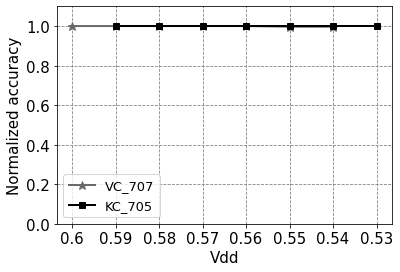

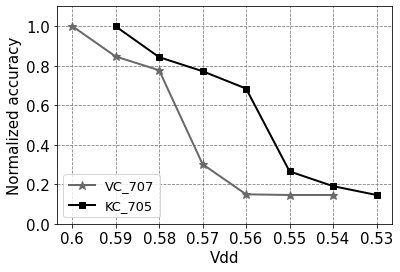

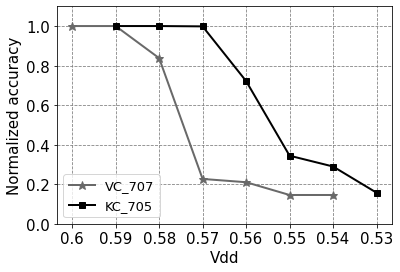

In [600]:
x=datos["Voltajes"]
fig = plt.figure(figsize=(20,5), dpi=100)
plt.rcParams.update({'font.size': 15})

fig1, ax1 = plt.subplots()
#ax1= fig.add_subplot(1,3,1)
x_values = range(len(x))
plt.xlabel('Vdd', fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)
plt.xticks(x_values, x)

fig2, ax2 = plt.subplots()
#ax2= fig.add_subplot(1,3,2)
x_values = range(len(x))
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)
plt.xticks(x_values, x)

fig3, ax3 = plt.subplots()
#ax3= fig.add_subplot(1,3,3)
x_values = range(len(x))
plt.xticks(x_values, x)
plt.xlabel('Vdd', fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)

ax1.set_ylim(0,1.1)
#ax1.set_title("VGG16 errores en 0 en activaciones")
ax1.invert_xaxis()

ax2.set_ylim(0,1.1)
#ax2.set_title("VGG16 errores en 1 en activaciones")
ax2.invert_xaxis()

ax3.set_ylim(0,1.1)
#ax3.set_title("VGG16 errores en 1 y 0 en activaciones")
ax3.invert_xaxis()



ax1.plot(VGG16_707["Acc_cero"], label='VC_707', color='dimgray', ls='-', lw='2', marker='*', markersize=9)
#ax1.plot(VGG16_707["Normalize"], color='dimgray', ls='-', lw='2', marker='D', markersize='6')
ax1.plot(VGG16_705["Acc_cero"], label='KC_705', color="k", ls='-', lw='2', marker='s', markersize=6)
ax1.grid( color = 'gray', linestyle = 'dashed')
ax1.legend(fontsize=13, loc='lower left')


ax2.plot(VGG16_707["Acc_uno"], label='VC_707', color='dimgray', ls='-', lw='2', marker='*', markersize=9)
#ax2.plot(VGG16_707["Normalize"],  color='dimgray', ls='-', lw='2', marker='D', markersize='6')
ax2.plot(VGG16_705["Acc_uno"], label='KC_705', color="k", ls='-', lw='2', marker='s', markersize=6)
ax2.grid( color = 'gray', linestyle = 'dashed')
ax2.legend(fontsize=13, loc='lower left')

ax3.plot(VGG16_707["Acc_uno_cero"],label='VC_707', color='dimgray', ls='-', lw='2', marker='*', markersize=9)
#ax3.plot(VGG16_707["Normalize"],  color='dimgray', ls='-', lw='2', marker='D', markersize='6')
ax3.plot(VGG16_705["Acc_uno_cero"], label='KC_705', color="k", ls='-', lw='2', marker='s', markersize=6)
ax3.grid( color = 'gray', linestyle = 'dashed')
ax3.legend(fontsize=13, loc='lower left')



pdfFile=PdfPages("VGG16_act_0.pdf")
pdfFile.savefig(fig1, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("VGG16_act_1.pdf")
pdfFile.savefig(fig2,transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("VGG16_act_0_1.pdf")
pdfFile.savefig(fig3, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()


plt.show

# VGG16 Pesos  Buffer 1

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.ticker as ticker
from pylab import *
from IPython.display import display,HTML
import cufflinks as cf
import plotly.offline as py



VGG16_p_b1  = pd.read_excel("resultado_VGG16.xlsx")
VGG16_pe_b1= VGG16_p_b1.set_index("Voltajes")

VGG16_p_b1_707  = pd.read_excel("resultado_VGG16.xlsx", usecols=["A_w_cero","A_w_uno","A_w_uno_cero","Normalize"])/0.8053
#df= df.dropna()
VGG16_p_b1_705 =pd.read_excel("resultado_VGG16.xlsx", sheet_name='fichero_705', usecols=["A_w_cero","A_w_uno","A_w_uno_cero","Normalize"])/0.8053

#cf.set_config_file(sharing='public',theme='white',offline=True) # write cf.getThemes() to find all themes availa

In [58]:
#VGG16_pe_b1
#VGG16_p_b1_707
VGG16_p_b1_705

A_w_cero   A_w_uno  A_w_uno_cero  Normalize
0  1.000041  1.000041      1.000041        1.0
1  1.000041  1.000041      1.000041        1.0
2  1.000041  1.000041      1.000041        1.0
3  1.000041  1.000041      1.000041        1.0
4  1.000041  1.000041      1.000041        1.0
5  1.000041  1.000041      1.000041        1.0
6  1.000041  1.000041      1.000041        1.0
7       NaN       NaN           NaN        1.0

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 2000x500 with 0 Axes>

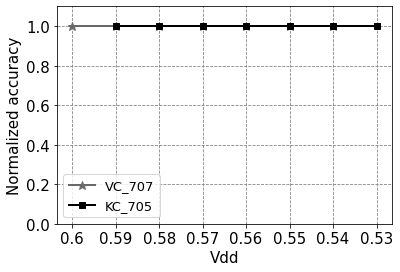

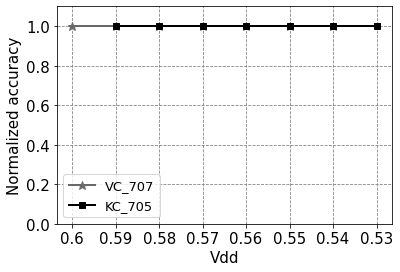

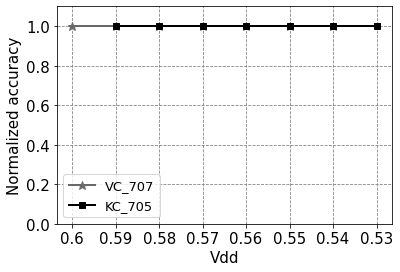

In [60]:
x=VGG16_p_b1["Voltajes"]
fig = plt.figure(figsize=(20,5), dpi=100)
plt.rcParams.update({'font.size': 15})

fig1, ax1 = plt.subplots()
#ax1= fig.add_subplot(1,3,1)
x_values = range(len(x))
plt.xlabel('Vdd', fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)
plt.xticks(x_values, x)

fig2, ax2 = plt.subplots()
#ax2= fig.add_subplot(1,3,2)
x_values = range(len(x))
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)
plt.xticks(x_values, x)

fig3, ax3 = plt.subplots()
#ax3= fig.add_subplot(1,3,3)
x_values = range(len(x))
plt.xticks(x_values, x)
plt.xlabel('Vdd', fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)

ax1.set_ylim(0,1.1)
#ax1.set_title("VGG16 errores en 0 en activaciones")
ax1.invert_xaxis()

ax2.set_ylim(0,1.1)
#ax2.set_title("VGG16 errores en 1 en activaciones")
ax2.invert_xaxis()

ax3.set_ylim(0,1.1)
#ax3.set_title("VGG16 errores en 1 y 0 en activaciones")
ax3.invert_xaxis()



ax1.plot(VGG16_p_b1_707["A_w_cero"], label='VC_707', color='dimgray', ls='-', lw='2', marker='*', markersize=9)
#ax1.plot(VGG16_p_b1_707["Normalize"], color='dimgray', ls='-', lw='2', marker='D', markersize='6')
ax1.plot(VGG16_p_b1_705["A_w_cero"], label='KC_705', color="k", ls='-', lw='2', marker='s', markersize=6)
ax1.grid( color = 'gray', linestyle = 'dashed')
ax1.legend(fontsize=13, loc='lower left')


ax2.plot(VGG16_p_b1_707["A_w_uno"], label='VC_707', color='dimgray', ls='-', lw='2', marker='*', markersize=9)
#ax2.plot(VGG16_p_b1_707["Normalize"],  color='dimgray', ls='-', lw='2', marker='D', markersize='6')
ax2.plot(VGG16_p_b1_705["A_w_uno"], label='KC_705', color="k", ls='-', lw='2', marker='s', markersize=6)
ax2.grid( color = 'gray', linestyle = 'dashed')
ax2.legend(fontsize=13, loc='lower left')

ax3.plot(VGG16_p_b1_707["A_w_uno_cero"],label='VC_707', color='dimgray', ls='-', lw='2', marker='*', markersize=9)
#ax3.plot(VGG16_p_b1_707["Normalize"],  color='dimgray', ls='-', lw='2', marker='D', markersize='6')
ax3.plot(VGG16_p_b1_705["A_w_uno_cero"], label='KC_705', color="k", ls='-', lw='2', marker='s', markersize=6)
ax3.grid( color = 'gray', linestyle = 'dashed')
ax3.legend(fontsize=13, loc='lower left')



pdfFile=PdfPages("VGG16_pes_buffer1_0.pdf")
pdfFile.savefig(fig1, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("VGG16_pes_buffer1_1.pdf")
pdfFile.savefig(fig2,transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("VGG16_pes_buffer1_0_1.pdf")
pdfFile.savefig(fig3, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()


plt.show

# VGG16 Pesos y Activaciones Buffer 1

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.ticker as ticker
from pylab import *
from IPython.display import display,HTML
import cufflinks as cf
import plotly.offline as py



VGG16_pa_b1  = pd.read_excel("resultado_VGG16.xlsx")
VGG16_p_a_b1= VGG16_pa_b1.set_index("Voltajes")

VGG16_p_a_b1_707  = pd.read_excel("resultado_VGG16.xlsx", usecols=["Acc_a_w_cero","Acc_a_w_uno","Acc_a_w_uno_cero","Normalize"])/0.8053
#df= df.dropna()
VGG16_p_a_b1_705 =pd.read_excel("resultado_VGG16.xlsx", sheet_name='fichero_705', usecols=["Acc_a_w_cero","Acc_a_w_uno","Acc_a_w_uno_cero","Normalize"])/0.8053

#cf.set_config_file(sharing='public',theme='white',offline=True) # write cf.getThemes() to find all themes availa

In [68]:
#VGG16_p_a_b1
#VGG16_p_a_b1_707
VGG16_p_a_b1_705

Acc_a_w_cero  Acc_a_w_uno  Acc_a_w_uno_cero  Normalize
0      1.000041     0.145701          0.157291        1.0
1      1.000041     0.190405          0.289747        1.0
2      1.000041     0.264912          0.344385        1.0
3      1.000041     0.683803          0.721884        1.0
4      1.000041     0.771555          0.998386        1.0
5      1.000041     0.842750          1.000041        1.0
6      1.000041     0.998386          1.000041        1.0
7           NaN          NaN               NaN        1.0

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 2000x500 with 0 Axes>

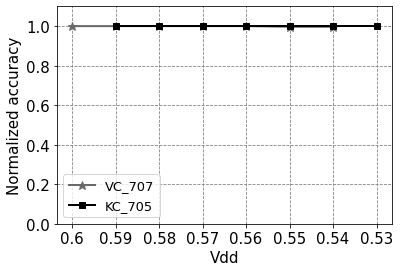

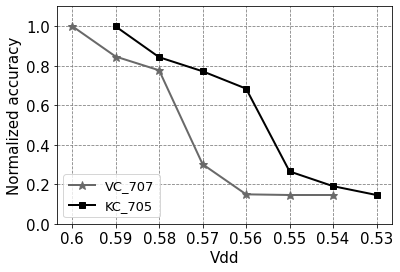

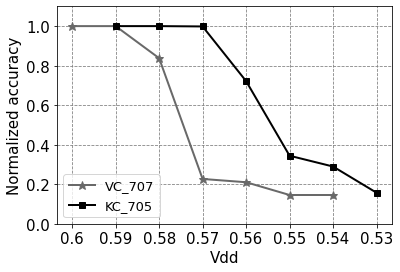

In [70]:
x=VGG16_p_b1["Voltajes"]
fig = plt.figure(figsize=(20,5), dpi=100)
plt.rcParams.update({'font.size': 15})

fig1, ax1 = plt.subplots()
#ax1= fig.add_subplot(1,3,1)
x_values = range(len(x))
plt.xlabel('Vdd', fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)
plt.xticks(x_values, x)

fig2, ax2 = plt.subplots()
#ax2= fig.add_subplot(1,3,2)
x_values = range(len(x))
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)
plt.xticks(x_values, x)

fig3, ax3 = plt.subplots()
#ax3= fig.add_subplot(1,3,3)
x_values = range(len(x))
plt.xticks(x_values, x)
plt.xlabel('Vdd', fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)

ax1.set_ylim(0,1.1)
#ax1.set_title("VGG16 errores en 0 en activaciones")
ax1.invert_xaxis()

ax2.set_ylim(0,1.1)
#ax2.set_title("VGG16 errores en 1 en activaciones")
ax2.invert_xaxis()

ax3.set_ylim(0,1.1)
#ax3.set_title("VGG16 errores en 1 y 0 en activaciones")
ax3.invert_xaxis()



ax1.plot(VGG16_p_a_b1_707["Acc_a_w_cero"], label='VC_707', color='dimgray', ls='-', lw='2', marker='*', markersize=9)
#ax1.plot(VGG16_p_a_b1_707["Normalize"], color='dimgray', ls='-', lw='2', marker='D', markersize='6')
ax1.plot(VGG16_p_a_b1_705["Acc_a_w_cero"], label='KC_705', color="k", ls='-', lw='2', marker='s', markersize=6)
ax1.grid( color = 'gray', linestyle = 'dashed')
ax1.legend(fontsize=13, loc='lower left')


ax2.plot(VGG16_p_a_b1_707["Acc_a_w_uno"], label='VC_707', color='dimgray', ls='-', lw='2', marker='*', markersize=9)
#ax2.plot(VGG16_p_a_b1_707["Normalize"],  color='dimgray', ls='-', lw='2', marker='D', markersize='6')
ax2.plot(VGG16_p_a_b1_705["Acc_a_w_uno"], label='KC_705', color="k", ls='-', lw='2', marker='s', markersize=6)
ax2.grid( color = 'gray', linestyle = 'dashed')
ax2.legend(fontsize=13, loc='lower left')

ax3.plot(VGG16_p_a_b1_707["Acc_a_w_uno_cero"],label='VC_707', color='dimgray', ls='-', lw='2', marker='*', markersize=9)
#ax3.plot(VGG16_p_a_b1_707["Normalize"],  color='dimgray', ls='-', lw='2', marker='D', markersize='6')
ax3.plot(VGG16_p_a_b1_705["Acc_a_w_uno_cero"], label='KC_705', color="k", ls='-', lw='2', marker='s', markersize=6)
ax3.grid( color = 'gray', linestyle = 'dashed')
ax3.legend(fontsize=13, loc='lower left')



pdfFile=PdfPages("VGG16_pes_y_act_buffer1_0.pdf")
pdfFile.savefig(fig1, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("VGG16_pes_y_act_buffer1_1.pdf")
pdfFile.savefig(fig2,transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("VGG16_pes_y_act_buffer1_0_1.pdf")
pdfFile.savefig(fig3, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()


plt.show

# ZFNet Activaciones  Buffer 1

In [588]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.ticker as ticker
from pylab import *
from IPython.display import display,HTML
import cufflinks as cf
import plotly.offline as py



ZFNet  = pd.read_excel("resultado_ZFNet.xlsx")
ZFNet= ZFNet.set_index("Voltajes")

ZFNet_707  = pd.read_excel("resultado_ZFNet.xlsx", usecols=["Acc_cero","Acc_uno","Acc_uno_cero","Normalize"])/0.8333
#df= df.dropna()
ZFNet_705 =pd.read_excel("resultado_ZFNet.xlsx", sheet_name='fichero_705', usecols=["Acc_cero","Acc_uno","Acc_uno_cero","Normalize"])/0.8333
#cf.set_config_file(sharing='public',theme='white',offline=True) # write cf.getThemes() to find all themes available

In [589]:
ZFNet
#ZFNet_707
#ZFNet_705

Acc_cero  A_w_cero  Acc_a_w_cero   Acc_uno   A_w_uno  Acc_a_w_uno  \
Voltajes                                                                      
0.53           NaN       NaN           NaN       NaN       NaN          NaN   
0.54      0.836000  0.833333      0.836000  0.117333  0.833333     0.117333   
0.55      0.830667  0.833333      0.830667  0.132000  0.833333     0.132000   
0.56      0.832000  0.833333      0.832000  0.130667  0.833333     0.130667   
0.57      0.833333  0.833333      0.833333  0.590667  0.833333     0.590667   
0.58      0.833333  0.833333      0.833333  0.714667  0.833333     0.714667   
0.59      0.833333  0.833333      0.833333  0.833333  0.833333     0.833333   
0.60      0.833333  0.833333      0.833333  0.832000  0.833333     0.832000   

          Acc_uno_cero  A_w_uno_cero  Acc_a_w_uno_cero  Normalize  
Voltajes                                                           
0.53               NaN           NaN               NaN     0.8333  
0.54          0.132000      0.833333          0.126667     0.8333  
0.55          0.216000      0.833333          0.216000     0.8333  
0.56          0.318667      0.833333          0.318667     0.8333  
0.57          0.689333      0.833333          0.689333     0.8333  
0.58          0.714667      0.833333          0.714667     0.8333  
0.59          0.833333      0.833333          0.833333     0.8333  
0.60          0.833333      0.833333          0.833333     0.8333

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 2000x500 with 0 Axes>

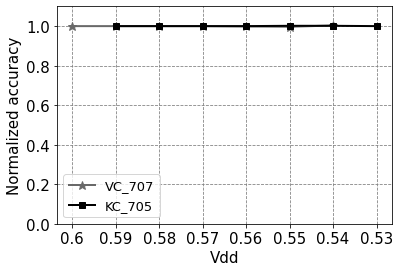

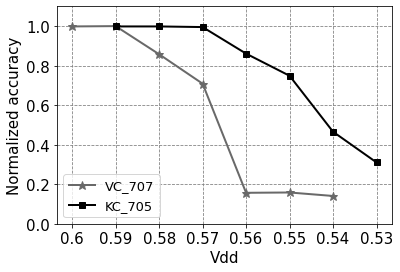

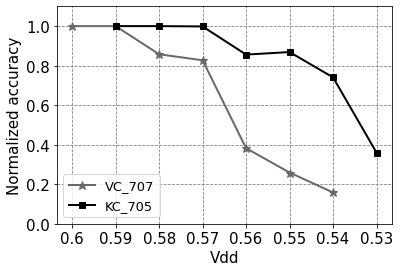

In [596]:
x=datos["Voltajes"]
fig = plt.figure(figsize=(20,5), dpi=100)
plt.rcParams.update({'font.size': 15})

fig1, ax1 = plt.subplots()
#ax1= fig.add_subplot(1,3,1)
x_values = range(len(x))
plt.xlabel('Vdd', fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)
plt.xticks(x_values, x)

fig2, ax2 = plt.subplots()
#ax2= fig.add_subplot(1,3,2)
x_values = range(len(x))
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)
plt.xticks(x_values, x)

fig3, ax3 = plt.subplots()
#ax3= fig.add_subplot(1,3,3)
x_values = range(len(x))
plt.xticks(x_values, x)
plt.xlabel('Vdd', fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)

ax1.set_ylim(0,1.1)
#ax1.set_title("ZFNet errores en 0 en activaciones")
ax1.invert_xaxis()

ax2.set_ylim(0,1.1)
#ax2.set_title("ZFNet errores en 1 en activaciones")
ax2.invert_xaxis()

ax3.set_ylim(0,1.1)
#ax3.set_title("ZFNet errores en 1 y 0 en activaciones")
ax3.invert_xaxis()



ax1.plot(ZFNet_707["Acc_cero"], label='VC_707', color='dimgray', ls='-', lw='2', marker='*', markersize=9)
#ax1.plot(ZFNet_707["Normalize"], color='dimgray', ls='-', lw='2', marker='D', markersize='6')
ax1.plot(ZFNet_705["Acc_cero"], label='KC_705', color="k", ls='-', lw='2', marker='s', markersize=6)
ax1.grid( color = 'gray', linestyle = 'dashed')
ax1.legend(fontsize=13, loc='lower left')


ax2.plot(ZFNet_707["Acc_uno"], label='VC_707', color='dimgray', ls='-', lw='2', marker='*', markersize=9)
#ax2.plot(ZFNet_707["Normalize"],  color='dimgray', ls='-', lw='2', marker='D', markersize='6')
ax2.plot(ZFNet_705["Acc_uno"], label='KC_705', color="k", ls='-', lw='2', marker='s', markersize=6)
ax2.grid( color = 'gray', linestyle = 'dashed')
ax2.legend(fontsize=13, loc='lower left')

ax3.plot(ZFNet_707["Acc_uno_cero"],label='VC_707', color='dimgray', ls='-', lw='2', marker='*', markersize=9)
#ax3.plot(ZFNet_707["Normalize"],  color='dimgray', ls='-', lw='2', marker='D', markersize='6')
ax3.plot(ZFNet_705["Acc_uno_cero"], label='KC_705', color="k", ls='-', lw='2', marker='s', markersize=6)
ax3.grid( color = 'gray', linestyle = 'dashed')
ax3.legend(fontsize=13, loc='lower left')



pdfFile=PdfPages("ZFNet_act_0.pdf")
pdfFile.savefig(fig1, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("ZFNet_act_1.pdf")
pdfFile.savefig(fig2,transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("ZFNet_act_0_1.pdf")
pdfFile.savefig(fig3, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()


plt.show

# ZFNet pesos Buffer 1

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.ticker as ticker
from pylab import *
from IPython.display import display,HTML
import cufflinks as cf
import plotly.offline as py



ZFNet_p_b1  = pd.read_excel("resultado_ZFNet.xlsx")
ZFNet_pe_b1= ZFNet_p_b1.set_index("Voltajes")

ZFNet_p_b1_707  = pd.read_excel("resultado_ZFNet.xlsx", usecols=["A_w_cero","A_w_uno","A_w_uno_cero","Normalize"])/0.8333
#df= df.dropna()
ZFNet_p_b1_705 =pd.read_excel("resultado_ZFNet.xlsx", sheet_name='fichero_705', usecols=["A_w_cero","A_w_uno","A_w_uno_cero","Normalize"])/0.8333
#cf.set_config_file(sharing='public',theme='white',offline=True) # write cf.getThemes() to find all themes available

In [93]:
#ZFNet_pe_b1
ZFNet_p_b1_707
#ZFNet_p_b1_705

A_w_cero  A_w_uno  A_w_uno_cero  Normalize
0       NaN      NaN           NaN        1.0
1   1.00004  1.00004       1.00004        1.0
2   1.00004  1.00004       1.00004        1.0
3   1.00004  1.00004       1.00004        1.0
4   1.00004  1.00004       1.00004        1.0
5   1.00004  1.00004       1.00004        1.0
6   1.00004  1.00004       1.00004        1.0
7   1.00004  1.00004       1.00004        1.0

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 2000x500 with 0 Axes>

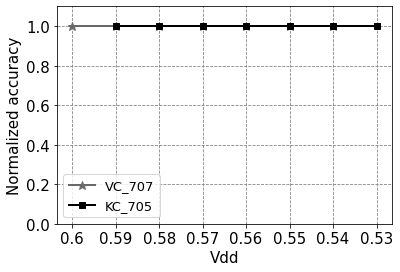

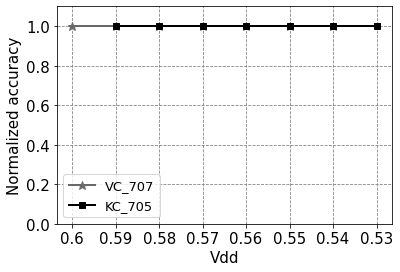

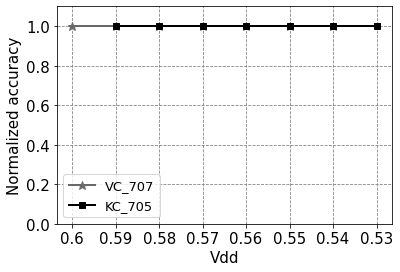

In [94]:
x=ZFNet_p_b1["Voltajes"]
fig = plt.figure(figsize=(20,5), dpi=100)
plt.rcParams.update({'font.size': 15})

fig1, ax1 = plt.subplots()
#ax1= fig.add_subplot(1,3,1)
x_values = range(len(x))
plt.xlabel('Vdd', fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)
plt.xticks(x_values, x)

fig2, ax2 = plt.subplots()
#ax2= fig.add_subplot(1,3,2)
x_values = range(len(x))
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)
plt.xticks(x_values, x)

fig3, ax3 = plt.subplots()
#ax3= fig.add_subplot(1,3,3)
x_values = range(len(x))
plt.xticks(x_values, x)
plt.xlabel('Vdd', fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)

ax1.set_ylim(0,1.1)
#ax1.set_title("ZFNet errores en 0 en activaciones")
ax1.invert_xaxis()

ax2.set_ylim(0,1.1)
#ax2.set_title("ZFNet errores en 1 en activaciones")
ax2.invert_xaxis()

ax3.set_ylim(0,1.1)
#ax3.set_title("ZFNet errores en 1 y 0 en activaciones")
ax3.invert_xaxis()



ax1.plot(ZFNet_p_b1_707["A_w_cero"], label='VC_707', color='dimgray', ls='-', lw='2', marker='*', markersize=9)
#ax1.plot(ZFNet_p_b1_707["Normalize"], color='dimgray', ls='-', lw='2', marker='D', markersize='6')
ax1.plot(ZFNet_p_b1_705["A_w_cero"], label='KC_705', color="k", ls='-', lw='2', marker='s', markersize=6)
ax1.grid( color = 'gray', linestyle = 'dashed')
ax1.legend(fontsize=13, loc='lower left')


ax2.plot(ZFNet_p_b1_707["A_w_uno"], label='VC_707', color='dimgray', ls='-', lw='2', marker='*', markersize=9)
#ax2.plot(ZFNet_p_b1_707["Normalize"],  color='dimgray', ls='-', lw='2', marker='D', markersize='6')
ax2.plot(ZFNet_p_b1_705["A_w_uno"], label='KC_705', color="k", ls='-', lw='2', marker='s', markersize=6)
ax2.grid( color = 'gray', linestyle = 'dashed')
ax2.legend(fontsize=13, loc='lower left')

ax3.plot(ZFNet_p_b1_707["A_w_uno_cero"],label='VC_707', color='dimgray', ls='-', lw='2', marker='*', markersize=9)
#ax3.plot(ZFNet_p_b1_707["Normalize"],  color='dimgray', ls='-', lw='2', marker='D', markersize='6')
ax3.plot(ZFNet_p_b1_705["A_w_uno_cero"], label='KC_705', color="k", ls='-', lw='2', marker='s', markersize=6)
ax3.grid( color = 'gray', linestyle = 'dashed')
ax3.legend(fontsize=13, loc='lower left')



pdfFile=PdfPages("ZFNet_pe_buffer1_0.pdf")
pdfFile.savefig(fig1, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("ZFNet_pe_buffer1_1.pdf")
pdfFile.savefig(fig2,transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("ZFNet_pe_buffer1_0_1.pdf")
pdfFile.savefig(fig3, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()


plt.show

# ZFNet pesos y activaciones Buffer 1

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.ticker as ticker
from pylab import *
from IPython.display import display,HTML
import cufflinks as cf
import plotly.offline as py



ZFNet_p_a_b1  = pd.read_excel("resultado_ZFNet.xlsx")
ZFNet_pe_a_b1= ZFNet_p_a_b1.set_index("Voltajes")

ZFNet_p_a_b1_707  = pd.read_excel("resultado_ZFNet.xlsx", usecols=["Acc_a_w_cero","Acc_a_w_uno","Acc_a_w_uno_cero","Normalize"])/0.8333
#df= df.dropna()
ZFNet_p_a_b1_705 =pd.read_excel("resultado_ZFNet.xlsx", sheet_name='fichero_705', usecols=["Acc_a_w_cero","Acc_a_w_uno","Acc_a_w_uno_cero","Normalize"])/0.8333
#cf.set_config_file(sharing='public',theme='white',offline=True) # write cf.getThemes() to find all themes available

In [96]:
#ZFNet_p_a_b1
#ZFNet_p_a_b1_707
ZFNet_p_a_b1_705

Acc_a_w_cero  Acc_a_w_uno  Acc_a_w_uno_cero  Normalize
0       1.00004     0.312012          0.358414        1.0
1       1.00164     0.465619          0.742430        1.0
2       1.00164     0.752030          0.870435        1.0
3       1.00004     0.862435          0.856034        1.0
4       1.00004     0.995240          0.998440        1.0
5       1.00004     0.998440          1.000040        1.0
6       1.00004     0.998440          1.000040        1.0
7           NaN          NaN               NaN        1.0

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 2000x500 with 0 Axes>

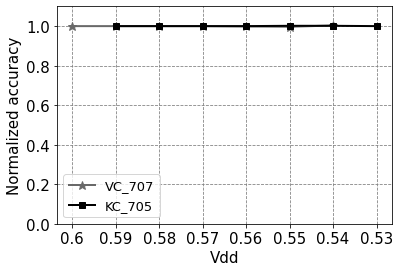

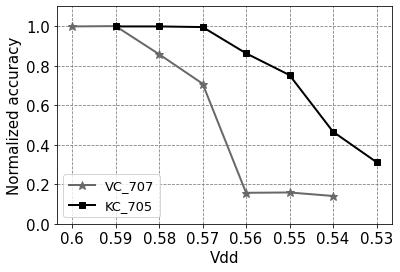

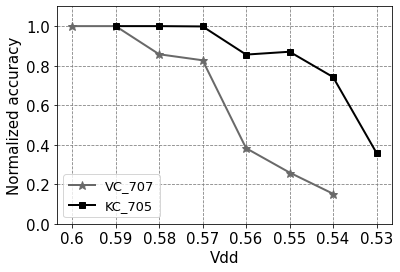

In [97]:
x=ZFNet_p_a_b1["Voltajes"]
fig = plt.figure(figsize=(20,5), dpi=100)
plt.rcParams.update({'font.size': 15})

fig1, ax1 = plt.subplots()
#ax1= fig.add_subplot(1,3,1)
x_values = range(len(x))
plt.xlabel('Vdd', fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)
plt.xticks(x_values, x)

fig2, ax2 = plt.subplots()
#ax2= fig.add_subplot(1,3,2)
x_values = range(len(x))
plt.xlabel('Vdd',fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)
plt.xticks(x_values, x)

fig3, ax3 = plt.subplots()
#ax3= fig.add_subplot(1,3,3)
x_values = range(len(x))
plt.xticks(x_values, x)
plt.xlabel('Vdd', fontsize=15)
plt.ylabel('Normalized accuracy', fontsize=15)

ax1.set_ylim(0,1.1)
#ax1.set_title("ZFNet errores en 0 en activaciones")
ax1.invert_xaxis()

ax2.set_ylim(0,1.1)
#ax2.set_title("ZFNet errores en 1 en activaciones")
ax2.invert_xaxis()

ax3.set_ylim(0,1.1)
#ax3.set_title("ZFNet errores en 1 y 0 en activaciones")
ax3.invert_xaxis()



ax1.plot(ZFNet_p_a_b1_707["Acc_a_w_cero"], label='VC_707', color='dimgray', ls='-', lw='2', marker='*', markersize=9)
#ax1.plot(ZFNet_p_a_b1_707["Normalize"], color='dimgray', ls='-', lw='2', marker='D', markersize='6')
ax1.plot(ZFNet_p_a_b1_705["Acc_a_w_cero"], label='KC_705', color="k", ls='-', lw='2', marker='s', markersize=6)
ax1.grid( color = 'gray', linestyle = 'dashed')
ax1.legend(fontsize=13, loc='lower left')


ax2.plot(ZFNet_p_a_b1_707["Acc_a_w_uno"], label='VC_707', color='dimgray', ls='-', lw='2', marker='*', markersize=9)
#ax2.plot(ZFNet_p_a_b1_707["Normalize"],  color='dimgray', ls='-', lw='2', marker='D', markersize='6')
ax2.plot(ZFNet_p_a_b1_705["Acc_a_w_uno"], label='KC_705', color="k", ls='-', lw='2', marker='s', markersize=6)
ax2.grid( color = 'gray', linestyle = 'dashed')
ax2.legend(fontsize=13, loc='lower left')

ax3.plot(ZFNet_p_a_b1_707["Acc_a_w_uno_cero"],label='VC_707', color='dimgray', ls='-', lw='2', marker='*', markersize=9)
#ax3.plot(ZFNet_p_a_b1_707["Normalize"],  color='dimgray', ls='-', lw='2', marker='D', markersize='6')
ax3.plot(ZFNet_p_a_b1_705["Acc_a_w_uno_cero"], label='KC_705', color="k", ls='-', lw='2', marker='s', markersize=6)
ax3.grid( color = 'gray', linestyle = 'dashed')
ax3.legend(fontsize=13, loc='lower left')



pdfFile=PdfPages("ZFNet_pe_y_act_buffer1_0.pdf")
pdfFile.savefig(fig1, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("ZFNet_pe_y_act_buffer1_1.pdf")
pdfFile.savefig(fig2,transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
pdfFile=PdfPages("ZFNet_pe_y_act_buffer1_0_1.pdf")
pdfFile.savefig(fig3, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()


plt.show

# Tareas para la noche y maña

1_ hacer la introducción del documento
2_ marcar las ideas escenciales que irán en cada parte 
mañana
3- Hacer el código para las Activaciones y pesos
la idea es guardar en una variable el buffer de activaciones y en otra el buffer d elos pesos , paso el de activaciones en la funcion con activaciones true y el de pesos en otra con wehigt true 
entonces los pasos a chec acc and loos diferentes y luego hay que ver como s efuncionan, analizar como funciona la funcion che accurancy para cada caso.
Lunes subir todas las gráficas con los nombre bien
y tener el documento preliminar listo y espero en Dios que a los tutores le agrade.
4- Hacer un modulo con el codigo que se repite.
5 Hacer modulo o una función para graficar